This subject of this project is the housing crisis in Ireland.
- Is this also the case in other countries within the UK & Ireland?
- Is housing increasing or decreasing in line with population growth?
- Will current trends in houses being built be able to accomodate the population over time?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import dns
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

In [3]:
import getpass
import glob
from copy import deepcopy

In [4]:
# Data cleaning libraries
import string

In [5]:
import requests
from datetime import datetime
import re
import json
import xml.etree.ElementTree as ET

In [6]:
import warnings

# turn off slice warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

In [7]:
plt.rcParams['figure.figsize'] = [12, 8]

# Data Ingestion

## IE Data First

In [8]:
# https://data.gov.ie/dataset/ndq01-new-dwelling-completions/resource/8fdc8f87-88ca-43f7-aa16-dbc3a52cacde
df_ie_ndq1_orig = pd.read_csv('./datasets/ie/NDQ01.csv')

# https://data.gov.ie/dataset/ndq03-new-dwelling-completions/resource/45701f7f-1192-406f-980f-a8ee23862147
df_ie_ndq3_orig = pd.read_csv('./datasets/ie/NDQ03.csv')

# https://data.gov.ie/dataset/ndq05-new-dwelling-completion/resource/108d82d0-43f1-4574-9e47-bb54f078fd84
df_ie_ndq5_orig = pd.read_csv('./datasets/ie/NDQ05.csv')

# https://data.gov.ie/dataset/ndq06-new-dwelling-completion/resource/0b5041bb-9f52-4b54-8c8d-0000306e74e2
df_ie_ndq6_orig = pd.read_csv('./datasets/ie/NDQ06.csv')

# UK data

In [9]:
# https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/ukhousebuildingpermanentdwellingsstartedandcompleted
df_uk_con_output_orig = pd.read_excel('./datasets/uk/outputukhousebuilding.xlsx')

# Population data

# Data Cleansing & Preparation

# IE functions

In [10]:
def extract_year_and_qtr(df, qtr_col_name):
    """
    Add docstring
    """
    
    df['year'] = df[qtr_col_name].str[:4].astype('int64')
    df['qtr'] = df[qtr_col_name].str[-2:]
    return df

## IE Data

In [11]:
df_ie_ndq1 = deepcopy(df_ie_ndq1_orig)

In [12]:
df_ie_ndq1.head()

,STATISTIC,STATISTIC Label,TLIST(Q1),Quarter,C02342V02816,Type of House,UNIT,VALUE
0,NDQ01,New Dwelling Completions,20111,2011Q1,06,Single house,Number,1156
1,NDQ01,New Dwelling Completions,20111,2011Q1,07,Scheme house,Number,447
2,NDQ01,New Dwelling Completions,20111,2011Q1,08,Apartment,Number,272
3,NDQ01,New Dwelling Completions,20111,2011Q1,-,All house types,Number,1875
4,NDQ01,New Dwelling Completions,20112,2011Q2,06,Single house,Number,1194


In [13]:
df_ie_ndq1.nunique()

STATISTIC            2
STATISTIC Label      2
TLIST(Q1)           49
Quarter             49
C02342V02816         4
Type of House        4
UNIT                 1
VALUE              372
dtype: int64

In [14]:
df_ie_ndq1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATISTIC        392 non-null    object
 1   STATISTIC Label  392 non-null    object
 2   TLIST(Q1)        392 non-null    int64 
 3   Quarter          392 non-null    object
 4   C02342V02816     392 non-null    object
 5   Type of House    392 non-null    object
 6   UNIT             392 non-null    object
 7   VALUE            392 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 24.6+ KB


In [15]:
df_ie_ndq1.describe()

,TLIST(Q1),VALUE
count,392.000000,392.000000
mean,20168.795918,1735.971939
std,35.388949,1685.422138
min,20111.000000,39.000000
25%,20141.000000,628.000000
50%,20171.000000,1180.500000
75%,20201.000000,2415.000000
max,20231.000000,9143.000000


In [16]:
df_ie_ndq1 = extract_year_and_qtr(df_ie_ndq1, 'Quarter')

In [17]:
df_ie_ndq1['STATISTIC Label'].unique()

array(['New Dwelling Completions',
       'Seasonally Adjusted New Dwelling Completions'], dtype=object)

In [18]:
# Statistic & Statistic Label represent the same data, so we can drop STATISTC and keep the label
df_ie_ndq1.pivot_table(index='STATISTIC Label',  columns='STATISTIC', values='VALUE', aggfunc='sum')

STATISTIC,NDQ01,NDQ01C02
STATISTIC Label,,
New Dwelling Completions,339994.0,NaN
Seasonally Adjusted New Dwelling Completions,NaN,340507.0


In [19]:
descriptions = {}
descriptions['new dwellings'] = df_ie_ndq1[df_ie_ndq1['STATISTIC Label'] == 'New Dwelling Completions']['VALUE'].describe()
descriptions['seasonally adjusted'] = df_ie_ndq1[df_ie_ndq1['STATISTIC Label'] == 'Seasonally Adjusted New Dwelling Completions']['VALUE'].describe()

In [20]:
print(pd.DataFrame(descriptions))

       new dwellings  seasonally adjusted
count     196.000000           196.000000
mean     1734.663265          1737.280612
std      1702.961122          1672.059497
min        39.000000            40.000000
25%       624.250000           650.000000
50%      1158.500000          1187.000000
75%      2358.500000          2443.250000
max      9143.000000          8185.000000


[]

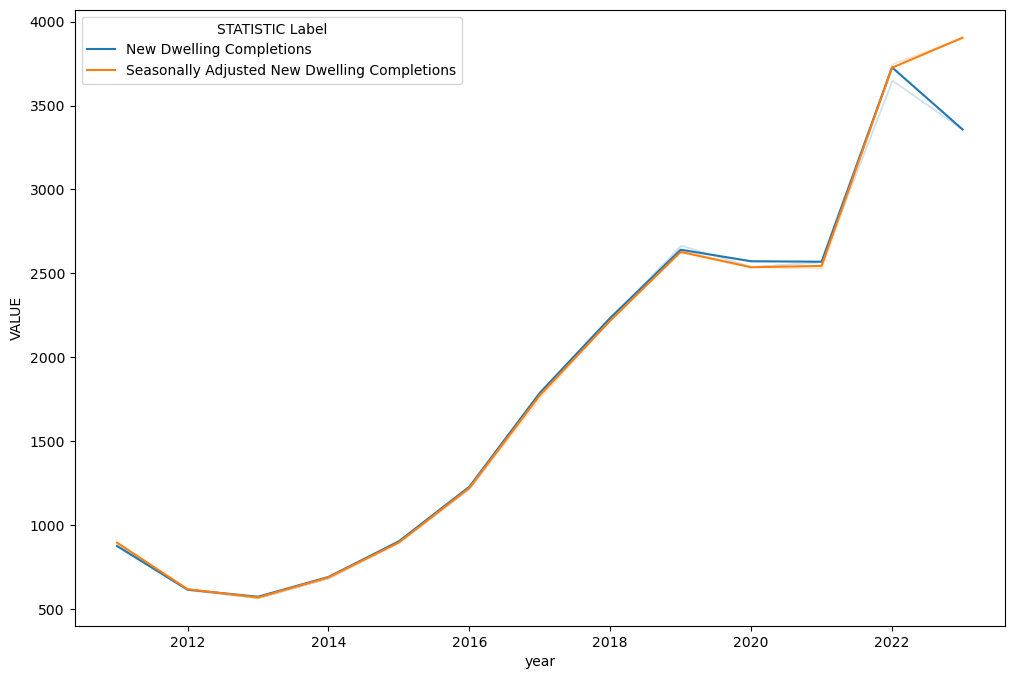

In [21]:
sns.lineplot(data=df_ie_ndq1, x='year', y='VALUE', hue='STATISTIC Label', errorbar=('ci', False))
plt.plot()

In [22]:
df_ie_ndq1.groupby(['STATISTIC Label'])['VALUE'].sum()

STATISTIC Label
New Dwelling Completions                        339994
Seasonally Adjusted New Dwelling Completions    340507
Name: VALUE, dtype: int64

In [23]:
# Type of House is mapped to C02342V02816, so we can drop C02342V02816.
df_ie_ndq1.pivot_table(index='Type of House',  columns='C02342V02816', values='VALUE', aggfunc='sum', fill_value=0)

C02342V02816,-,06,07,08
Type of House,,,,
All house types,340248,0,0,0
Apartment,0,0,0,65615
Scheme house,0,0,171317,0
Single house,0,103321,0,0


In [24]:
# The sum of Apartment, Scheme house and Single house equals All house types
df_ie_ndq1[df_ie_ndq1['Type of House']!='All house types'].pivot_table(index='Type of House',  columns='C02342V02816', values='VALUE', aggfunc='sum', fill_value=0).sum().sum()

340253

What is the difference between New & Seasonally adjusted?  
Looks like seasonally adjusted has some applied logic where New is the raw numbers.  
- For now focus on new until I can justify the selection.

In [25]:
df_ie_ndq1 = df_ie_ndq1[df_ie_ndq1['STATISTIC Label'] == 'New Dwelling Completions']

In [26]:
df_ie_ndq1['type_comp'] = df_ie_ndq1['Type of House'].apply(lambda x: 'All' if x != "All house types" else x)

In [27]:
df_ndq1_temp = df_ie_ndq1.pivot_table(index='Quarter',  columns='type_comp', values='VALUE', aggfunc='sum', fill_value=0)
df_ndq1_temp.head()

type_comp,All,All house types
Quarter,,
2011Q1,1875,1875
2011Q2,1791,1791
2011Q3,1687,1687
2011Q4,1641,1641
2012Q1,1131,1131


In [28]:
df_ndq1_temp['diff'] = df_ndq1_temp['All'] - df_ndq1_temp['All house types']
df_ndq1_temp[df_ndq1_temp['diff'] != 0]

type_comp,All,All house types,diff
Quarter,,,


In [29]:
assert((df_ndq1_temp['All'] == df_ndq1_temp['All house types']).all())

In [30]:
# UNIT is an unnecessary column as there is just a single value 'Number'.
df_ie_ndq1.pivot_table(index='UNIT',  columns='Type of House', values='VALUE', aggfunc='sum', fill_value=0)

Type of House,All house types,Apartment,Scheme house,Single house
UNIT,,,,
Number,169997,32826,85622,51549


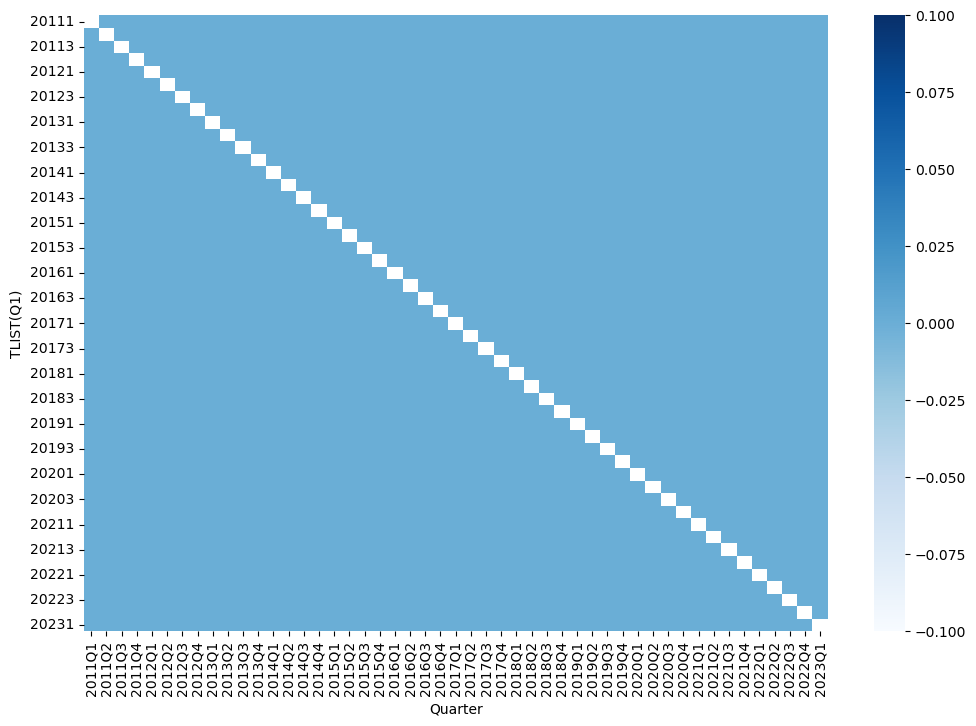

In [31]:
# TLIST(Q1) appears to be the same as Quarter as there is a 1 to 1 relationship
df_qtr_pivot = df_ie_ndq1.pivot_table(index='TLIST(Q1)',  columns='Quarter', values='VALUE', aggfunc='sum', fill_value=0)
mask = df_qtr_pivot > 1
sns.heatmap(df_qtr_pivot, cmap="Blues", mask=mask)
plt.show()

In [32]:
# Test that all the values in TLIST(Q1) are the same as in Quarter but with an added Q in the second last position
assert((df_ie_ndq1['Quarter'].str.replace('Q', '').astype('str') == df_ie_ndq1['TLIST(Q1)'].astype('str')).all())

In [33]:
list_cols_to_drop = ['STATISTIC', 'TLIST(Q1)', 'C02342V02816', 'UNIT', 'type_comp']

In [34]:
df_ie_ndq1_clean = df_ie_ndq1.drop(list_cols_to_drop, axis=1)

In [35]:
df_ie_ndq1_clean.head()

,STATISTIC Label,Quarter,Type of House,VALUE,year,qtr
0,New Dwelling Completions,2011Q1,Single house,1156,2011,Q1
1,New Dwelling Completions,2011Q1,Scheme house,447,2011,Q1
2,New Dwelling Completions,2011Q1,Apartment,272,2011,Q1
3,New Dwelling Completions,2011Q1,All house types,1875,2011,Q1
4,New Dwelling Completions,2011Q2,Single house,1194,2011,Q2


In [36]:
# I don't think I'll end up needing this but keep it for now and decide when joining the dataframes.
df_ie_ndq1_pivot = df_ie_ndq1_clean.pivot_table(index=['Quarter', 'year', 'qtr'], columns='Type of House', values='VALUE', aggfunc='sum', fill_value=0).reset_index()

In [37]:
df_ie_ndq1_pivot.head()

Type of House,Quarter,year,qtr,All house types,Apartment,Scheme house,Single house
0,2011Q1,2011,Q1,1875,272,447,1156
1,2011Q2,2011,Q2,1791,217,380,1194
2,2011Q3,2011,Q3,1687,185,305,1197
3,2011Q4,2011,Q4,1641,148,226,1267
4,2012Q1,2012,Q1,1131,123,211,797


In [38]:
df_ie_ndq1_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Quarter          49 non-null     object
 1   year             49 non-null     int64 
 2   qtr              49 non-null     object
 3   All house types  49 non-null     int64 
 4   Apartment        49 non-null     int64 
 5   Scheme house     49 non-null     int64 
 6   Single house     49 non-null     int64 
dtypes: int64(5), object(2)
memory usage: 2.8+ KB


In [39]:
df_ie_ndq1_pivot.describe()

Type of House,year,All house types,Apartment,Scheme house,Single house
count,49.000000,49.000000,49.000000,49.000000,49.000000
mean,2016.632653,3469.326531,669.918367,1747.387755,1052.020408
std,3.574760,2176.803538,712.878988,1328.234242,256.445941
min,2011.000000,889.000000,39.000000,174.000000,625.000000
25%,2014.000000,1570.000000,170.000000,433.000000,868.000000
50%,2017.000000,3000.000000,445.000000,1643.000000,1076.000000
75%,2020.000000,4951.000000,730.000000,2832.000000,1207.000000
max,2023.000000,9143.000000,2781.000000,4832.000000,1531.000000


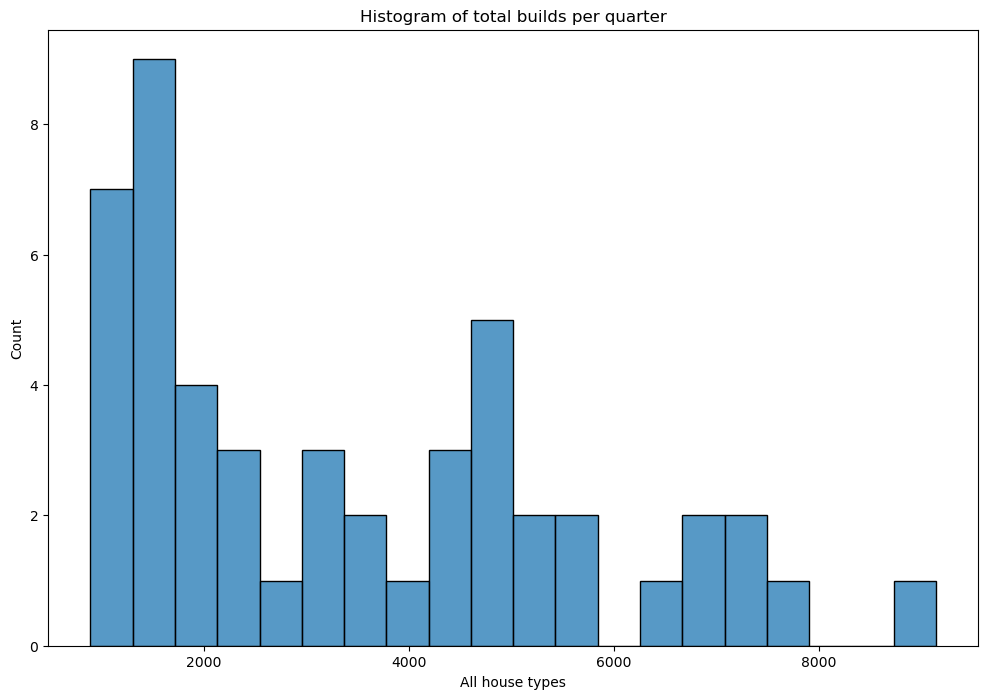

In [40]:
sns.histplot(data=df_ie_ndq1_pivot, x='All house types', bins=20).set_title("Histogram of total builds per quarter")
plt.show()

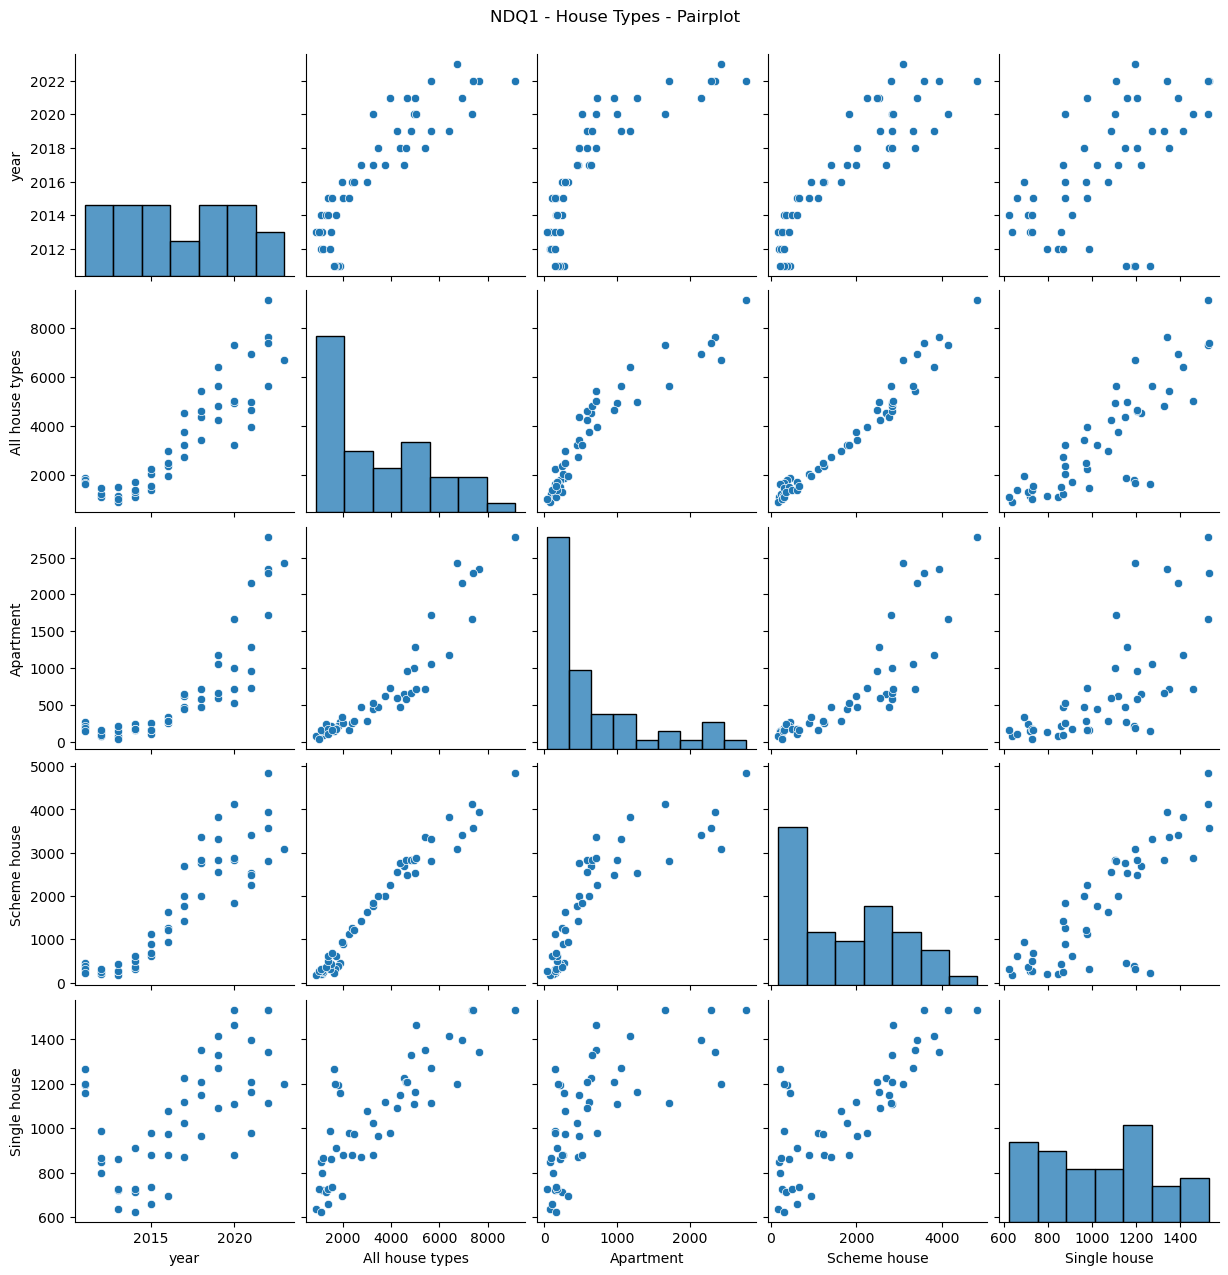

In [41]:
pp = sns.pairplot(data=df_ie_ndq1_pivot)
pp.fig.suptitle("NDQ1 - House Types - Pairplot", y=1.02)
plt.show()

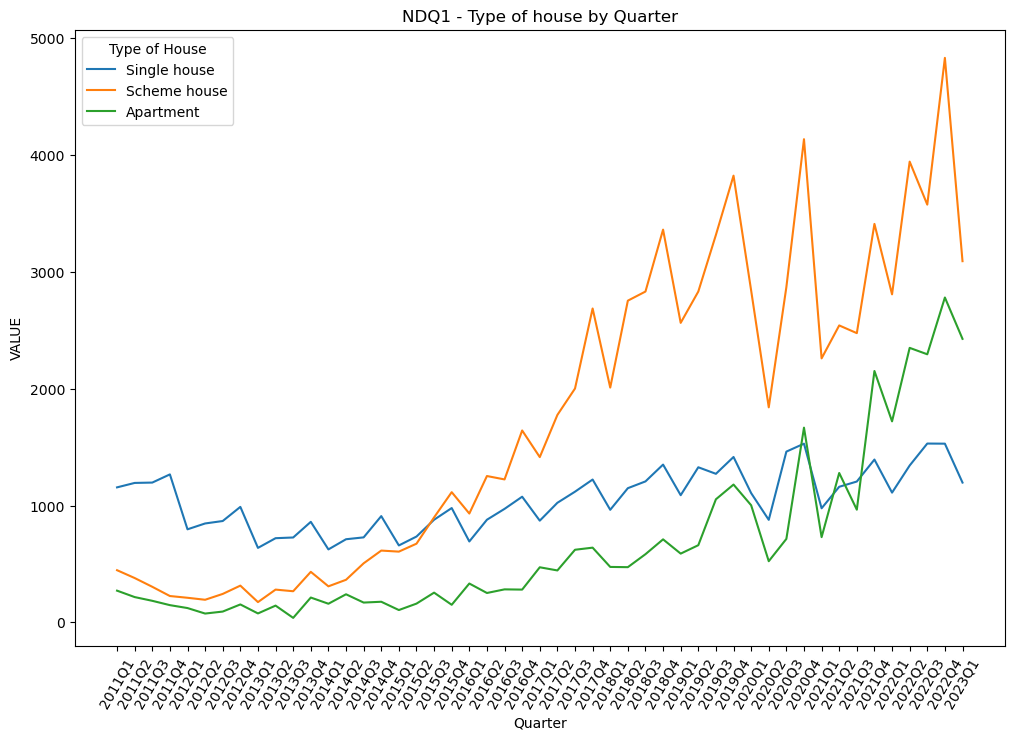

In [42]:
lp = sns.lineplot(data=df_ie_ndq1_clean[df_ie_ndq1_clean['Type of House'] != 'All house types'], x='Quarter', y='VALUE', hue='Type of House')
lp.set_title('NDQ1 - Type of house by Quarter')
plt.xticks(rotation=60)
plt.show()

Scheme houses took a sharp drop from 2019 to 2021 then a shrap rise and another sharp drop.  
- Could this be due to missing data or just is it a reflection of reality?
- Correction, this is due to COVID. (https://www.irishtimes.com/business/construction/over-20-000-new-homes-completed-in-2020-despite-covid-disruption-1.4476058)   
The downturn in Q2 & Q3 was across all segments but apartments recovered in Q4.  

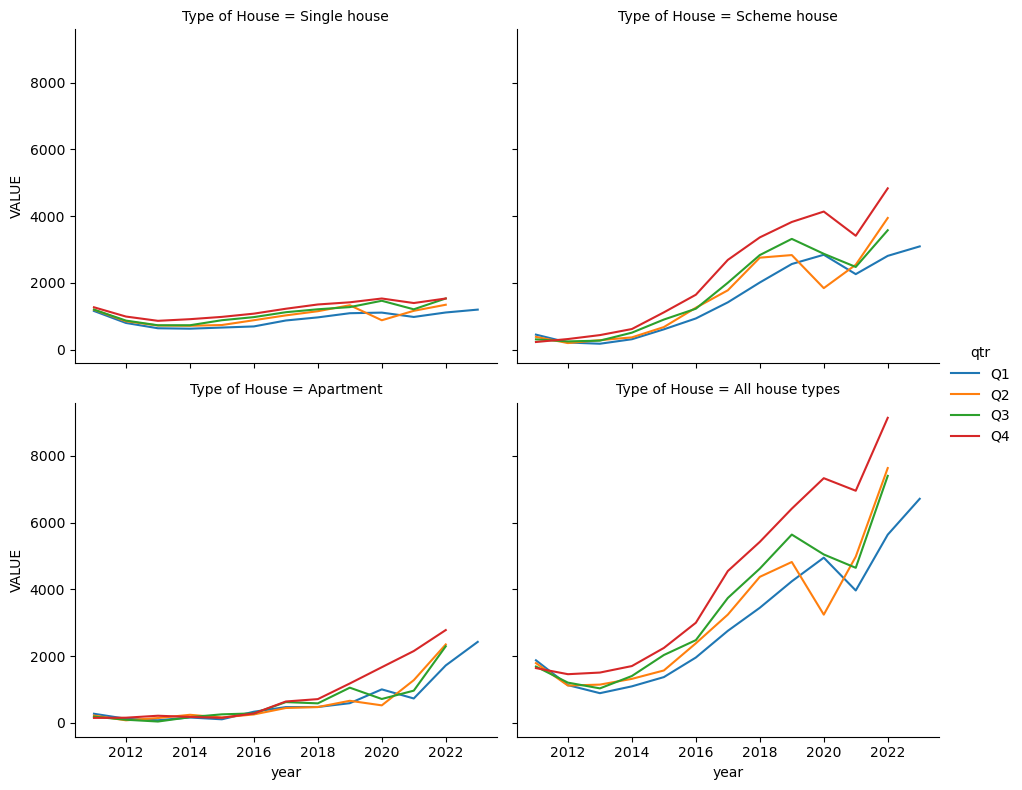

In [43]:
sns.relplot(data=df_ie_ndq1_clean, kind='line', x='year', y='VALUE', hue='qtr',
            col='Type of House', col_wrap=2, height=4, aspect=1.2, legend=True)
plt.show()

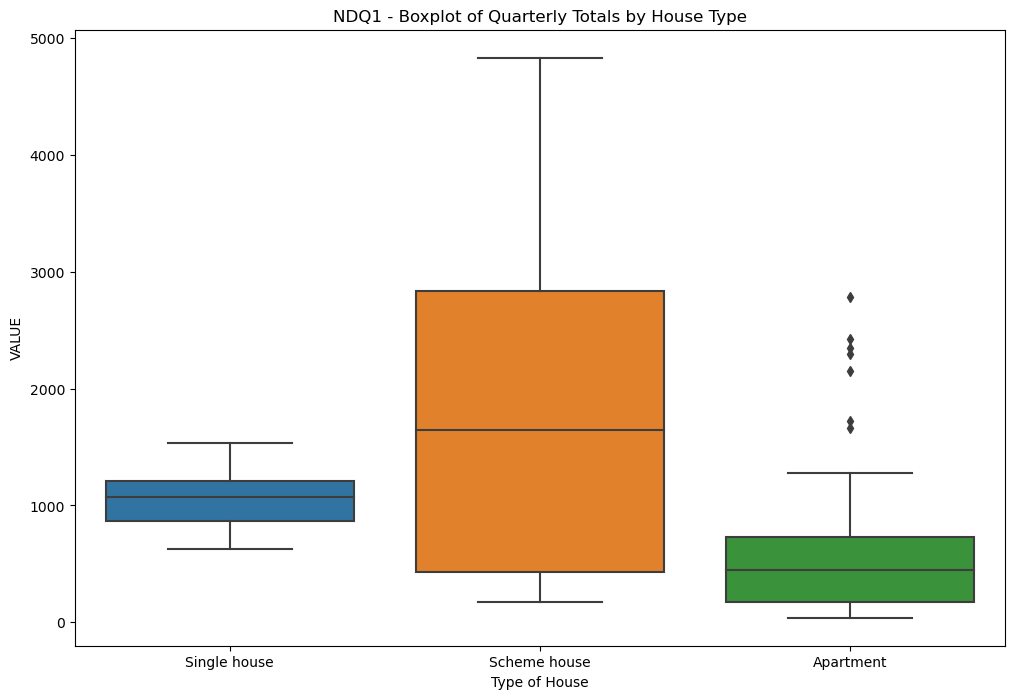

In [44]:
bp = sns.boxplot(data=df_ie_ndq1_clean[df_ie_ndq1_clean['Type of House'] != 'All house types'], x='Type of House', y='VALUE')
bp.set_title("NDQ1 - Boxplot of Quarterly Totals by House Type")
plt.show()

In [45]:
df_boxplot_stats = df_ie_ndq1_clean[df_ie_ndq1_clean['Type of House'] != 'All house types'].groupby(['Type of House'])['VALUE'].describe().transpose()
print(df_boxplot_stats)

Type of House    Apartment  Scheme house  Single house
count            49.000000     49.000000     49.000000
mean            669.918367   1747.387755   1052.020408
std             712.878988   1328.234242    256.445941
min              39.000000    174.000000    625.000000
25%             170.000000    433.000000    868.000000
50%             445.000000   1643.000000   1076.000000
75%             730.000000   2832.000000   1207.000000
max            2781.000000   4832.000000   1531.000000


In [46]:
iqr = df_boxplot_stats.loc['75%', 'Apartment'] - df_boxplot_stats.loc['25%', 'Apartment']
upper_whisker = (1.5 * iqr) + df_boxplot_stats.loc['75%', 'Apartment']
print(upper_whisker)

1570.0


Outliers are the most recent quarters prior to now.  
Outliers will be included as they represent an upwards trend in the data.

In [47]:
df_ie_ndq1_pivot[df_ie_ndq1_pivot['Apartment'] >= upper_whisker]

Type of House,Quarter,year,qtr,All house types,Apartment,Scheme house,Single house
39,2020Q4,2020,Q4,7333,1667,4136,1530
43,2021Q4,2021,Q4,6957,2152,3411,1394
44,2022Q1,2022,Q1,5640,1721,2808,1111
45,2022Q2,2022,Q2,7637,2350,3944,1343
46,2022Q3,2022,Q3,7402,2295,3576,1531
47,2022Q4,2022,Q4,9143,2781,4832,1530
48,2023Q1,2023,Q1,6716,2427,3092,1197


In [48]:
df_ndq1_house_totals = df_ie_ndq1_clean.groupby(['Type of House'])['VALUE'].sum()

In [49]:
df_ndq1_house_totals.head()

Type of House
All house types    169997
Apartment           32826
Scheme house        85622
Single house        51549
Name: VALUE, dtype: int64

## IE DF no.2

In [50]:
df_ie_ndq3 = deepcopy(df_ie_ndq3_orig)

In [51]:
df_ie_ndq3.head(10)

,STATISTIC,STATISTIC Label,TLIST(Q1),Quarter,C02342V02816,Type of House,C02106V02545,Urban and Rural,UNIT,VALUE
0,NDQ03,New Dwelling Completions,20111,2011Q1,-,All house types,1,Urban areas,Number,841
1,NDQ03,New Dwelling Completions,20111,2011Q1,-,All house types,5,Rural areas,Number,1033
2,NDQ03,New Dwelling Completions,20111,2011Q1,06,Single house,1,Urban areas,Number,152
3,NDQ03,New Dwelling Completions,20111,2011Q1,06,Single house,5,Rural areas,Number,1004
4,NDQ03,New Dwelling Completions,20111,2011Q1,07,Scheme house,1,Urban areas,Number,422
5,NDQ03,New Dwelling Completions,20111,2011Q1,07,Scheme house,5,Rural areas,Number,25
6,NDQ03,New Dwelling Completions,20111,2011Q1,08,Apartment,1,Urban areas,Number,267
7,NDQ03,New Dwelling Completions,20111,2011Q1,08,Apartment,5,Rural areas,Number,4
8,NDQ03,New Dwelling Completions,20112,2011Q2,-,All house types,1,Urban areas,Number,706
9,NDQ03,New Dwelling Completions,20112,2011Q2,-,All house types,5,Rural areas,Number,1081


In [52]:
df_ie_ndq3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATISTIC        392 non-null    object
 1   STATISTIC Label  392 non-null    object
 2   TLIST(Q1)        392 non-null    int64 
 3   Quarter          392 non-null    object
 4   C02342V02816     392 non-null    object
 5   Type of House    392 non-null    object
 6   C02106V02545     392 non-null    int64 
 7   Urban and Rural  392 non-null    object
 8   UNIT             392 non-null    object
 9   VALUE            392 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 30.8+ KB


In [53]:
df_ie_ndq3.describe()

,TLIST(Q1),C02106V02545,VALUE
count,392.000000,392.000000,392.000000
mean,20168.795918,3.000000,867.270408
std,35.388949,2.002556,1217.629605
min,20111.000000,1.000000,0.000000
25%,20141.000000,1.000000,72.500000
50%,20171.000000,3.000000,508.000000
75%,20201.000000,5.000000,1010.250000
max,20231.000000,5.000000,7804.000000


In [54]:
df_ie_ndq3.nunique()

STATISTIC            1
STATISTIC Label      1
TLIST(Q1)           49
Quarter             49
C02342V02816         4
Type of House        4
C02106V02545         2
Urban and Rural      2
UNIT                 1
VALUE              307
dtype: int64

In [55]:
df_ie_ndq3 = extract_year_and_qtr(df_ie_ndq3, 'Quarter')

In [56]:
# Check if all house types is equal to the sum of urban and rural areas
df_ie_ndq3['type_comp'] = df_ie_ndq3['Type of House'].apply(lambda x: 'All' if x != "All house types" else x)

In [57]:
df_ndq3_temp = df_ie_ndq3.pivot_table(index=['Quarter', 'Urban and Rural'],  columns='type_comp', values='VALUE', aggfunc='sum', fill_value=0)
df_ndq3_temp.head()

type_comp                 All  All house types
Quarter Urban and Rural                       
2011Q1  Rural areas      1033             1033
        Urban areas       841              841
2011Q2  Rural areas      1081             1081
        Urban areas       706              706
2011Q3  Rural areas      1085             1085

In [58]:
df_ndq3_temp['diff'] = df_ndq3_temp['All'] - df_ndq3_temp['All house types']
df_ndq3_temp

type_comp                 All  All house types  diff
Quarter Urban and Rural                             
2011Q1  Rural areas      1033             1033     0
        Urban areas       841              841     0
2011Q2  Rural areas      1081             1081     0
        Urban areas       706              706     0
2011Q3  Rural areas      1085             1085     0
...                       ...              ...   ...
2022Q3  Urban areas      6087             6087     0
2022Q4  Rural areas      1339             1339     0
        Urban areas      7804             7804     0
2023Q1  Rural areas       967              967     0
        Urban areas      5749             5749     0

[98 rows x 3 columns]

In [59]:
df_ndq3_temp[df_ndq3_temp['diff']!=0]

,type_comp,All,All house types,diff
Quarter,Urban and Rural,,,


In [60]:
# Totals are equal
df_ie_ndq3.pivot_table(index='UNIT',  columns='type_comp', values='VALUE', aggfunc='sum', fill_value=0)

type_comp,All,All house types
UNIT,,
Number,169985,169985


In [61]:
df_ndq3_house_totals = df_ie_ndq3.groupby(['Type of House'])['VALUE'].sum()

In [62]:
# Approx half of each house type from ndq1 is included in ndq3 - including totals.
df_ndq3_temp = pd.concat([df_ndq1_house_totals, df_ndq3_house_totals], axis=1)
df_ndq3_temp.columns = ['ndq1', 'ndq3']
df_ndq3_temp['diff'] = df_ndq3_temp['ndq1'] - df_ndq3_temp['ndq3']
df_ndq3_temp['diff %'] = df_ndq3_temp['diff'] / df_ndq3_temp['ndq1']
print(df_ndq3_temp)

                   ndq1    ndq3  diff    diff %
Type of House                                  
All house types  169997  169985    12  0.000071
Apartment         32826   32819     7  0.000213
Scheme house      85622   85621     1  0.000012
Single house      51549   51545     4  0.000078


In [63]:
# Urban and Rural is mapped to C02106V02545, so we can drop C02106V02545.
df_ie_ndq3.pivot_table(index='Urban and Rural',  columns='C02106V02545', values='VALUE', aggfunc='sum', fill_value=0)

C02106V02545,1,5
Urban and Rural,,
Rural areas,0,87864
Urban areas,252106,0


In [64]:
# Add C02106V02545 to the existing drop_cols list as the other columns are also present.
list_cols_to_drop.append('C02106V02545')

In [65]:
df_ie_ndq3_clean = df_ie_ndq3.drop(list_cols_to_drop, axis=1)

In [66]:
df_ie_ndq3_clean['house_area'] = df_ie_ndq3_clean['Type of House'].str.strip() +"-"+ df_ie_ndq3_clean['Urban and Rural'].str.strip()


In [67]:
df_ie_ndq3_clean.head()

,STATISTIC Label,Quarter,Type of House,Urban and Rural,VALUE,year,qtr,house_area
0,New Dwelling Completions,2011Q1,All house types,Urban areas,841,2011,Q1,All house types-Urban areas
1,New Dwelling Completions,2011Q1,All house types,Rural areas,1033,2011,Q1,All house types-Rural areas
2,New Dwelling Completions,2011Q1,Single house,Urban areas,152,2011,Q1,Single house-Urban areas
3,New Dwelling Completions,2011Q1,Single house,Rural areas,1004,2011,Q1,Single house-Rural areas
4,New Dwelling Completions,2011Q1,Scheme house,Urban areas,422,2011,Q1,Scheme house-Urban areas


In [68]:
df_ie_ndq3_clean = df_ie_ndq3_clean[df_ie_ndq3_clean['Type of House']!='All house types']

In [69]:
df_ie_ndq3_pivot = df_ie_ndq3_clean.pivot_table(index=['Quarter'], columns=['house_area'], values='VALUE', aggfunc='sum', fill_value=0).reset_index()


In [70]:
df_ie_ndq3_pivot.head()

house_area,Quarter,Apartment-Rural areas,Apartment-Urban areas,Scheme house-Rural areas,Scheme house-Urban areas,Single house-Rural areas,Single house-Urban areas
0,2011Q1,4,267,25,422,1004,152
1,2011Q2,1,215,24,355,1056,136
2,2011Q3,0,185,37,268,1048,149
3,2011Q4,1,147,20,206,1131,136
4,2012Q1,5,118,12,199,699,98


In [71]:
df_ie_ndq3_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Quarter                   49 non-null     object
 1   Apartment-Rural areas     49 non-null     int64 
 2   Apartment-Urban areas     49 non-null     int64 
 3   Scheme house-Rural areas  49 non-null     int64 
 4   Scheme house-Urban areas  49 non-null     int64 
 5   Single house-Rural areas  49 non-null     int64 
 6   Single house-Urban areas  49 non-null     int64 
dtypes: int64(6), object(1)
memory usage: 2.8+ KB


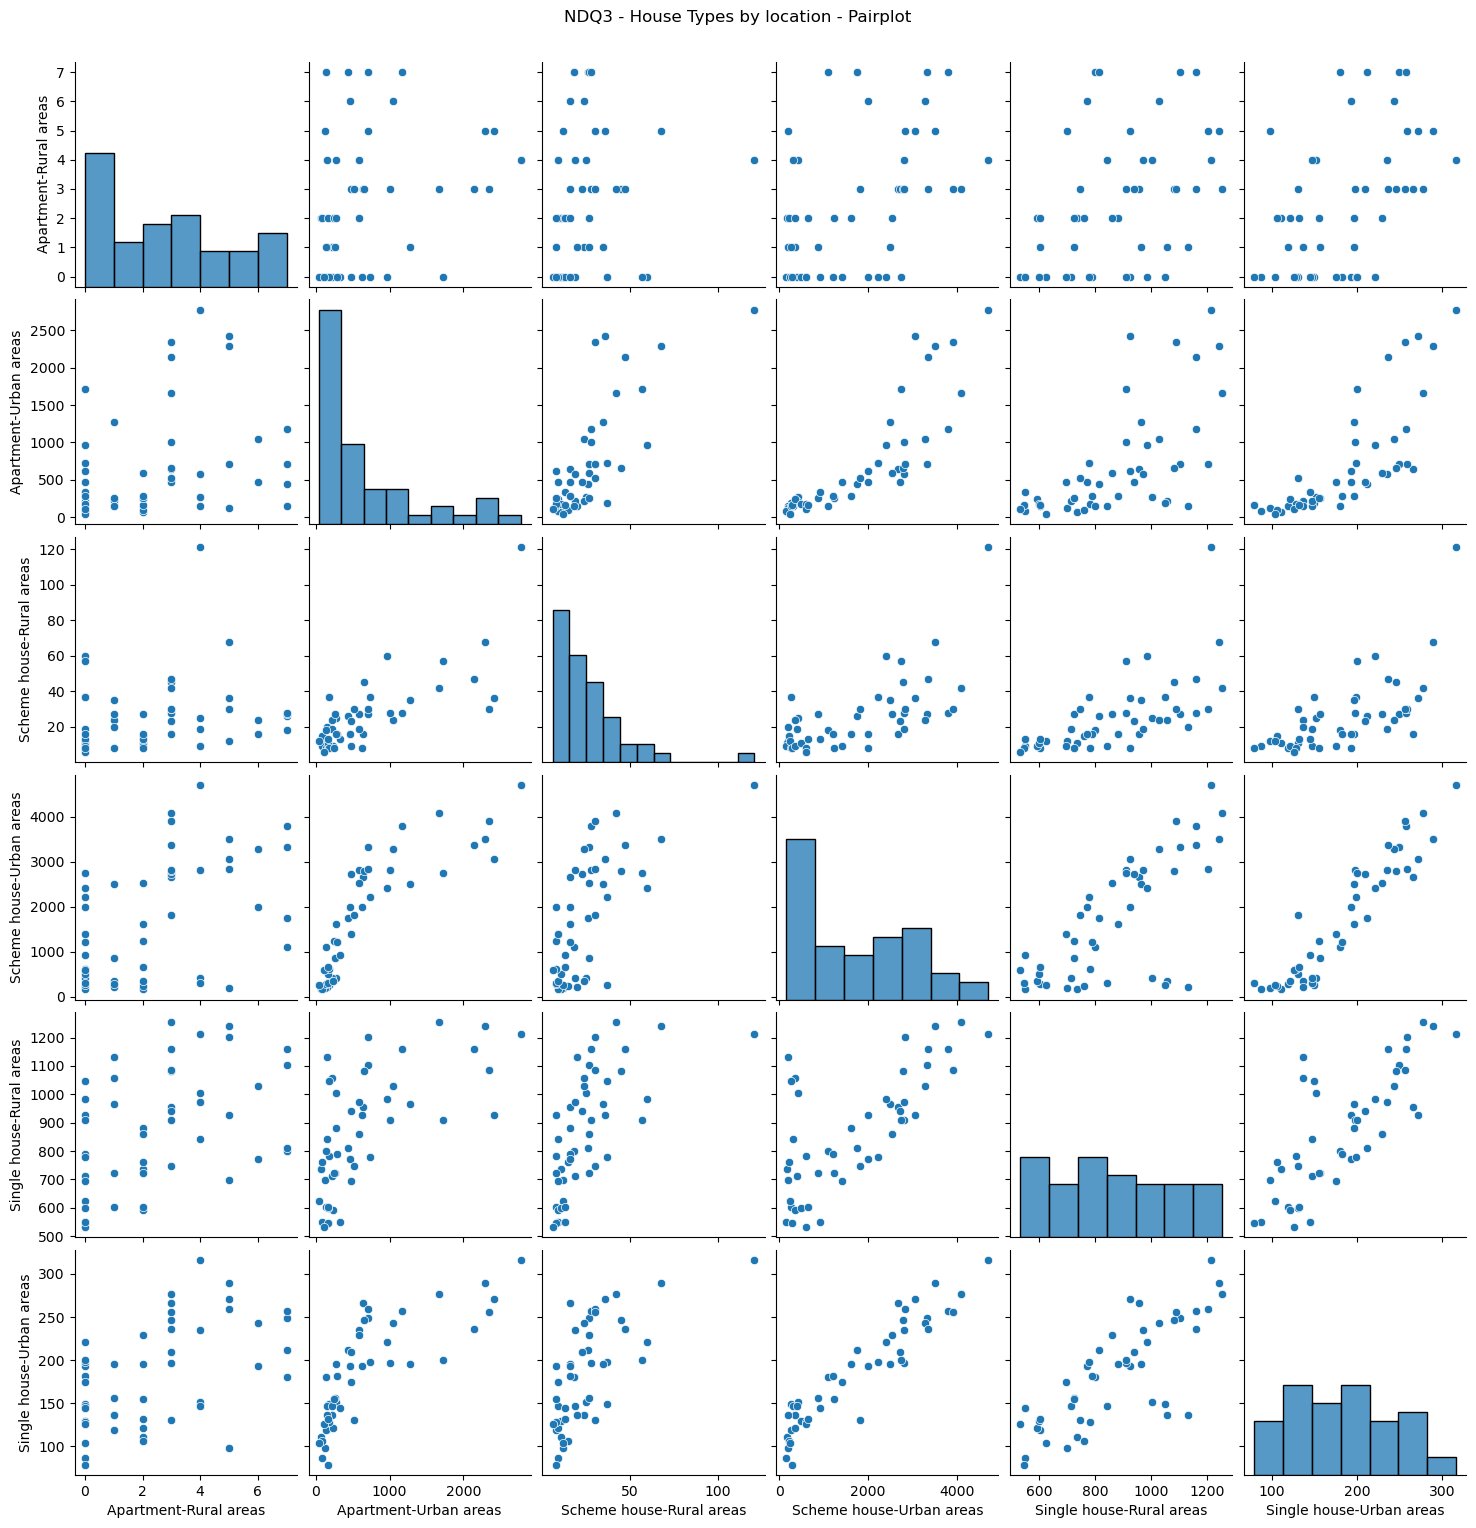

In [72]:
pp = sns.pairplot(data=df_ie_ndq3_pivot)
pp.fig.suptitle("NDQ3 - House Types by location - Pairplot", y=1.02)
plt.show()

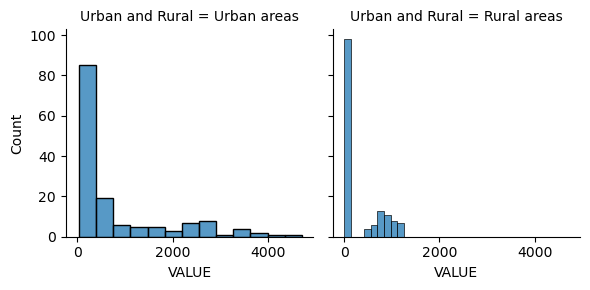

In [73]:
fg = sns.FacetGrid(data=df_ie_ndq3_clean, col='Urban and Rural')
fg.map(sns.histplot, 'VALUE')
plt.show()

In [74]:
rural_df = df_ie_ndq3_clean[df_ie_ndq3_clean['Urban and Rural']=='Rural areas']
urban_df = df_ie_ndq3_clean[df_ie_ndq3_clean['Urban and Rural']=='Urban areas']

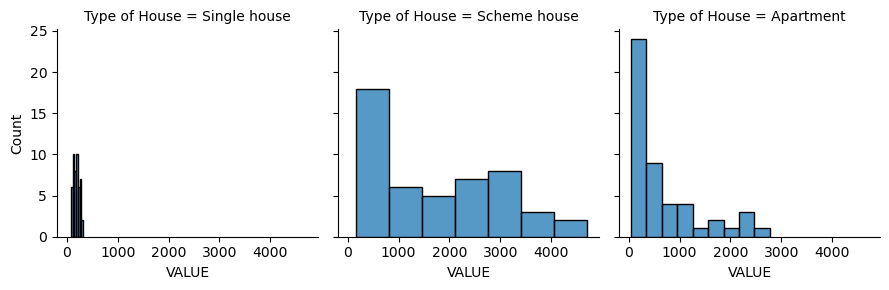

In [75]:
fg = sns.FacetGrid(data=urban_df, col='Type of House')
fg.map(sns.histplot, 'VALUE')
plt.show()

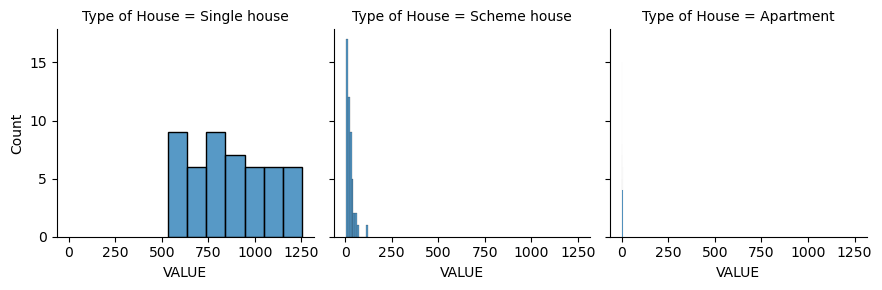

In [76]:
fg = sns.FacetGrid(data=rural_df, col='Type of House')
fg.map(sns.histplot, 'VALUE')

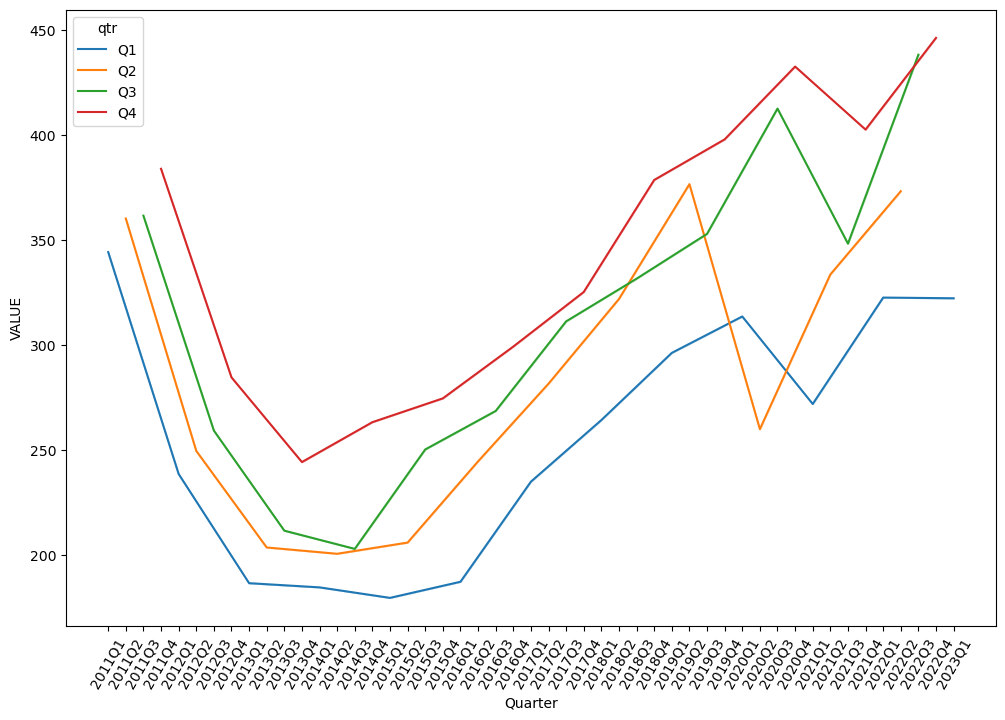

In [77]:
sns.lineplot(data=rural_df, x='Quarter', y='VALUE', hue='qtr', errorbar=('ci', False))
plt.xticks(rotation=60)
plt.show()

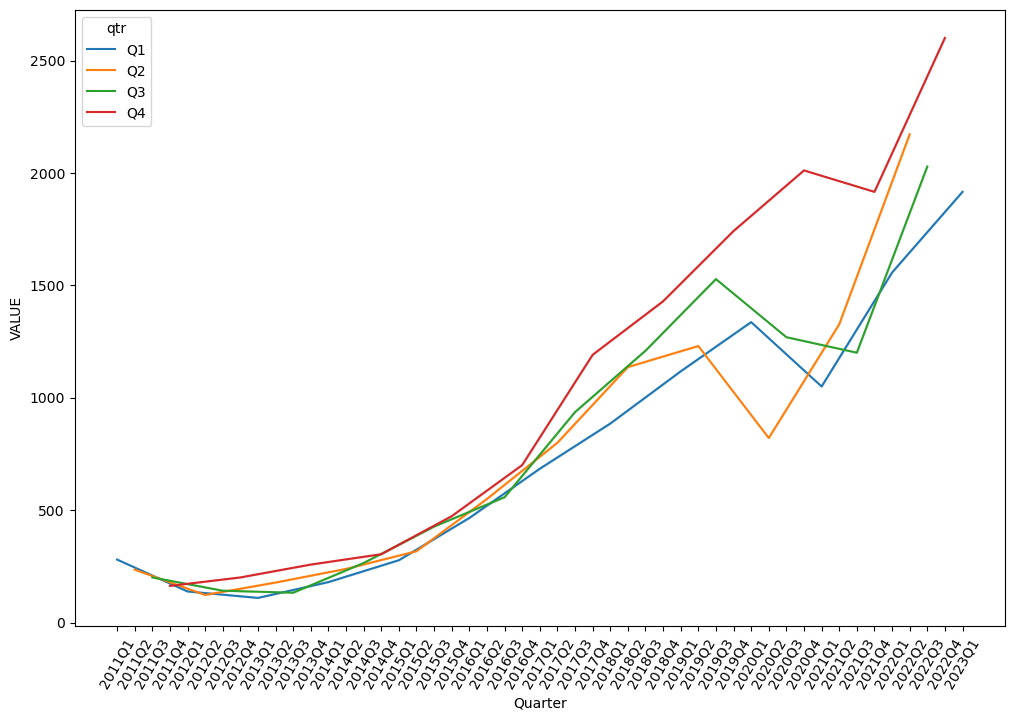

In [78]:
sns.lineplot(data=urban_df, x='Quarter', y='VALUE', hue='qtr', errorbar=('ci', False))
plt.xticks(rotation=60)

plt.show()

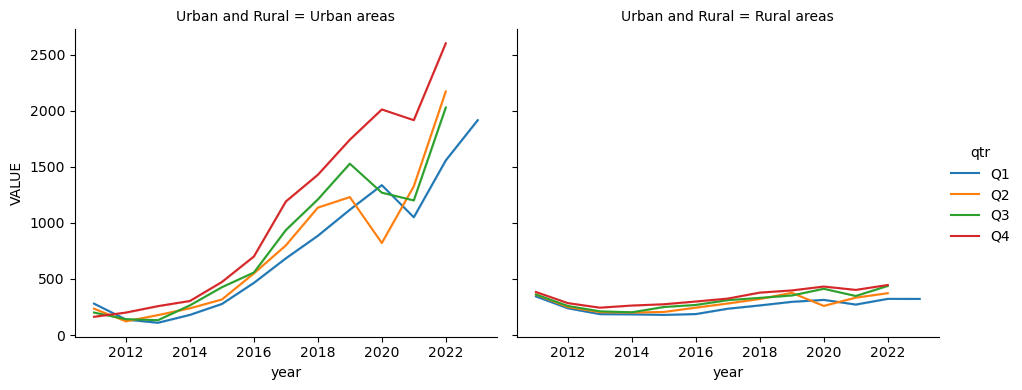

In [79]:
sns.relplot(data=df_ie_ndq3_clean, kind='line', x='year', y='VALUE', hue='qtr',
            col='Urban and Rural', col_wrap=2, height=4, aspect=1.2, legend=True, errorbar=('ci', False))
plt.show()

## IE DF no.3

In [80]:
dict_county_mapping = {'Dún Laoghaire Rathdown':"Dublin", 'Fingal':"Dublin", 'South Dublin':"Dublin"}

In [81]:
def get_county_province_mapping():
    # Create a dictionary to map county to province using a table from Wikipedia.
    # Reading the html populates the list 'tables' with all tables parsed from the HTML.
    # A manual review of tables is necessary to ensure that the table is correct.
    # TODO - add error checking or write to file and read the csv each time this run/
    tables = pd.read_html("https://en.wikipedia.org/wiki/Counties_of_Ireland")
    ie_county_details = tables[3]
    ie_county_details.head()
    # ie_county_details.to_csv('./datasets/county_province_names.csv')
    # Select relevant columns.
    df_county_province_mapping = ie_county_details[['County', 'Province']]

    # Remove trailing characters from the County names.
    df_county_province_mapping.loc[:,'County'] = df_county_province_mapping['County'].str.replace("\[[A-Za-z]\]", "", regex=True)

    # Adjust Londonderry to Derry to match other datasources.
    df_county_province_mapping.loc[:,'County'] = df_county_province_mapping['County'].str.replace("Londonderry", "Derry")

    # Change all column headers to lower case.
    df_county_province_mapping.columns = [col.lower() for col in df_county_province_mapping.columns]
    
    return df_county_province_mapping

In [82]:
def map_county_and_province(df, mapping_df):
    df = pd.merge(left=df, right=mapping_df, on='county', how='left')
    return df

In [83]:
def rollup_county_values(df):
        col_names = [col for col in df.columns if col != 'VALUE']
        df = df.groupby(col_names)['VALUE'].sum().reset_index()
        return df

In [84]:
def county_mapping(df, mapping_dict):
    """
    Insert docstring
    
    """
    df['CC_name'] = df['Local Authority'].str.split(' C', n=1).str[0]
    df['county'] = df['CC_name'].str.strip().replace(mapping_dict)
    df = df.drop(['CC_name', 'Local Authority'], axis=1)
    county_mapping_df = get_county_province_mapping()
    df = rollup_county_values(df)
    df = map_county_and_province(df, county_mapping_df)
    return df

In [85]:
df_ie_ndq5 = deepcopy(df_ie_ndq5_orig)

In [86]:
df_ie_ndq5.head()

,STATISTIC,STATISTIC Label,TLIST(Q1),Quarter,C03789V04537,Local Authority,UNIT,VALUE
0,NDQ05,New Dwelling Completion,20111,2011Q1,-,Ireland,Number,1875
1,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-1434-13a3-e055-000000000001,Cork City Council,Number,39
2,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a2-13a3-e055-000000000001,Clare County Council,Number,52
3,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-149d-13a3-e055-000000000001,Cavan County Council,Number,61
4,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a3-13a3-e055-000000000001,Cork County Council,Number,168


In [87]:
df_ie_ndq5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1568 entries, 0 to 1567
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATISTIC        1568 non-null   object
 1   STATISTIC Label  1568 non-null   object
 2   TLIST(Q1)        1568 non-null   int64 
 3   Quarter          1568 non-null   object
 4   C03789V04537     1568 non-null   object
 5   Local Authority  1568 non-null   object
 6   UNIT             1568 non-null   object
 7   VALUE            1568 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 98.1+ KB


In [88]:
df_ie_ndq5.nunique()

STATISTIC            1
STATISTIC Label      1
TLIST(Q1)           49
Quarter             49
C03789V04537        32
Local Authority     32
UNIT                 1
VALUE              413
dtype: int64

In [89]:
# For each value in C03789V04537, theres is one value for Local Authority, we can drop C03789V04537
df_ie_ndq5.groupby(['Local Authority'])['C03789V04537'].nunique()

Local Authority
Carlow County Council                    1
Cavan County Council                     1
Clare County Council                     1
Cork City Council                        1
Cork County Council                      1
Donegal County Council                   1
Dublin City Council                      1
Dún Laoghaire Rathdown County Council    1
Fingal County Council                    1
Galway City Council                      1
Galway County Council                    1
Ireland                                  1
Kerry County Council                     1
Kildare County Council                   1
Kilkenny County Council                  1
Laois County Council                     1
Leitrim County Council                   1
Limerick City & County Council           1
Longford County Council                  1
Louth County Council                     1
Mayo County Council                      1
Meath County Council                     1
Monaghan County Council               

In [90]:
df_ie_ndq5['auth_comp'] = df_ie_ndq5['Local Authority'].apply(lambda x: 'CC' if x != "Ireland" else x)

In [91]:
# Sum of all 
df_ie_ndq5.pivot_table(index='UNIT',  columns='auth_comp', values='VALUE', aggfunc='sum', fill_value=0)

auth_comp,CC,Ireland
UNIT,,
Number,169997,169997


In [92]:
# Compare the totals for each dataframe at the highest agg level in the data
ndq1_total = df_ie_ndq1[df_ie_ndq1['Type of House']=='All house types']['VALUE'].sum()
ndq3_total = df_ie_ndq3[df_ie_ndq3['Type of House']=='All house types']['VALUE'].sum()
ndq5_total = df_ie_ndq5[df_ie_ndq5['Local Authority']=='Ireland']['VALUE'].sum()

In [93]:
print(f"NDQ1: {ndq1_total}, NDQ3: {ndq3_total}, NDQ5: {ndq5_total}")
print(ndq1_total - ndq5_total)

NDQ1: 169997, NDQ3: 169985, NDQ5: 169997
0


https://www.citizensinformation.ie/en/government_in_ireland/national_government/local_and_regional_government/functions_of_local_authorities.html  
Differentiating between City and County council will have no material as it is not possible to determine if a specific council  type controls rural or urban planning

In [94]:
df_ie_ndq5['CC_name'] = df_ie_ndq5['Local Authority'].str.split(' C', n=1).str[0]
df_ie_ndq5.head(10)

,STATISTIC,STATISTIC Label,TLIST(Q1),Quarter,C03789V04537,Local Authority,UNIT,VALUE,auth_comp,CC_name
0,NDQ05,New Dwelling Completion,20111,2011Q1,-,Ireland,Number,1875,Ireland,Ireland
1,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-1434-13a3-e055-000000000001,Cork City Council,Number,39,CC,Cork
2,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a2-13a3-e055-000000000001,Clare County Council,Number,52,CC,Clare
3,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-149d-13a3-e055-000000000001,Cavan County Council,Number,61,CC,Cavan
4,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a3-13a3-e055-000000000001,Cork County Council,Number,168,CC,Cork
5,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-1492-13a3-e055-000000000001,Carlow County Council,Number,17,CC,Carlow
6,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-1433-13a3-e055-000000000001,Dublin City Council,Number,72,CC,Dublin
7,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-149f-13a3-e055-000000000001,Dún Laoghaire Rathdown County Council,Number,30,CC,Dún Laoghaire Rathdown
8,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a4-13a3-e055-000000000001,Donegal County Council,Number,118,CC,Donegal
9,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a0-13a3-e055-000000000001,Fingal County Council,Number,144,CC,Fingal


In [95]:
df_ie_ndq5['CC_name'].unique()

array(['Ireland', 'Cork', 'Clare', 'Cavan', 'Carlow', 'Dublin',
       'Dún Laoghaire Rathdown', 'Donegal', 'Fingal', 'Galway', 'Kildare',
       'Kilkenny', 'Kerry', 'Longford', 'Louth', 'Limerick', 'Leitrim',
       'Laois', 'Meath', 'Monaghan', 'Mayo', 'Offaly', 'Roscommon',
       'South Dublin', 'Sligo', 'Tipperary', 'Waterford', 'Westmeath',
       'Wicklow', 'Wexford'], dtype=object)

In [96]:
df_ie_ndq5['county'] = df_ie_ndq5['CC_name'].str.strip().replace(dict_county_mapping)

In [97]:
df_ie_ndq5.head(10)

,STATISTIC,STATISTIC Label,TLIST(Q1),Quarter,C03789V04537,Local Authority,UNIT,VALUE,auth_comp,CC_name,county
0,NDQ05,New Dwelling Completion,20111,2011Q1,-,Ireland,Number,1875,Ireland,Ireland,Ireland
1,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-1434-13a3-e055-000000000001,Cork City Council,Number,39,CC,Cork,Cork
2,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a2-13a3-e055-000000000001,Clare County Council,Number,52,CC,Clare,Clare
3,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-149d-13a3-e055-000000000001,Cavan County Council,Number,61,CC,Cavan,Cavan
4,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a3-13a3-e055-000000000001,Cork County Council,Number,168,CC,Cork,Cork
5,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-1492-13a3-e055-000000000001,Carlow County Council,Number,17,CC,Carlow,Carlow
6,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-1433-13a3-e055-000000000001,Dublin City Council,Number,72,CC,Dublin,Dublin
7,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-149f-13a3-e055-000000000001,Dún Laoghaire Rathdown County Council,Number,30,CC,Dún Laoghaire Rathdown,Dublin
8,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a4-13a3-e055-000000000001,Donegal County Council,Number,118,CC,Donegal,Donegal
9,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a0-13a3-e055-000000000001,Fingal County Council,Number,144,CC,Fingal,Dublin


In [98]:
df_ie_ndq5_cleaned = extract_year_and_qtr(df_ie_ndq5, 'Quarter')
df_ie_ndq5_cleaned = county_mapping(df_ie_ndq5_cleaned, dict_county_mapping)

In [99]:
list_cols_to_drop = ['STATISTIC', 'TLIST(Q1)', 'C03789V04537', 'UNIT', 'auth_comp']
df_ie_ndq5_cleaned = df_ie_ndq5_cleaned.drop(list_cols_to_drop, axis=1)

In [100]:
df_ie_ndq5_cleaned.head()

,STATISTIC Label,Quarter,county,year,qtr,VALUE,province
0,New Dwelling Completion,2011Q1,Ireland,2011,Q1,1875,NaN
1,New Dwelling Completion,2011Q1,Dublin,2011,Q1,72,Leinster
2,New Dwelling Completion,2011Q1,Cork,2011,Q1,39,Munster
3,New Dwelling Completion,2011Q1,Galway,2011,Q1,15,Connacht
4,New Dwelling Completion,2011Q1,Laois,2011,Q1,34,Leinster


In [101]:
ndq5_cleaned_total = df_ie_ndq5_cleaned[df_ie_ndq5_cleaned['county']!='Ireland']['VALUE'].sum()

In [102]:
df_ie_ndq5_cleaned = df_ie_ndq5_cleaned[df_ie_ndq5_cleaned['county']!='Ireland']

In [103]:
df_ie_ndq5_cleaned['prov_county'] = df_ie_ndq5_cleaned['province'].str.strip() +"-"+ df_ie_ndq5_cleaned['county'].str.strip()


In [104]:
# Test if pre-rollup values = post rollup values
assert(ndq5_total == ndq5_cleaned_total)

In [105]:
df_ie_ndq5_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1519 entries, 1 to 1567
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATISTIC Label  1519 non-null   object
 1   Quarter          1519 non-null   object
 2   county           1519 non-null   object
 3   year             1519 non-null   int64 
 4   qtr              1519 non-null   object
 5   VALUE            1519 non-null   int64 
 6   province         1519 non-null   object
 7   prov_county      1519 non-null   object
dtypes: int64(2), object(6)
memory usage: 106.8+ KB


In [106]:
df_ie_ndq5_cleaned[df_ie_ndq5_cleaned['VALUE']==0]

,STATISTIC Label,Quarter,county,year,qtr,VALUE,province,prov_county


In [107]:
df_ie_ndq5_cleaned['VALUE'].min()

3

In [108]:
df_ie_ndq5_pivot = df_ie_ndq5_cleaned.pivot_table(index=['Quarter'], columns=['prov_county'], values='VALUE', aggfunc='sum', fill_value=0).reset_index()


In [109]:
df_ie_ndq5_pivot.head()

prov_county,Quarter,Connacht-Galway,Connacht-Leitrim,Connacht-Mayo,Connacht-Roscommon,Connacht-Sligo,Leinster-Carlow,Leinster-Dublin,Leinster-Kildare,Leinster-Kilkenny,...,Leinster-Wicklow,Munster-Clare,Munster-Cork,Munster-Kerry,Munster-Limerick,Munster-Tipperary,Munster-Waterford,Ulster-Cavan,Ulster-Donegal,Ulster-Monaghan
0,2011Q1,108,42,67,26,52,17,287,126,40,...,74,52,207,62,54,63,96,61,118,26
1,2011Q2,125,13,59,54,34,24,327,42,50,...,37,49,236,67,49,94,29,28,139,21
2,2011Q3,114,14,124,38,35,24,181,42,84,...,60,47,215,77,55,73,30,45,115,33
3,2011Q4,125,16,88,31,24,38,169,76,54,...,47,57,219,79,95,68,35,37,88,32
4,2012Q1,83,15,41,19,62,17,110,51,26,...,23,44,142,46,27,40,18,20,114,42


In [110]:
df_ie_ndq5_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Quarter             49 non-null     object
 1   Connacht-Galway     49 non-null     int64 
 2   Connacht-Leitrim    49 non-null     int64 
 3   Connacht-Mayo       49 non-null     int64 
 4   Connacht-Roscommon  49 non-null     int64 
 5   Connacht-Sligo      49 non-null     int64 
 6   Leinster-Carlow     49 non-null     int64 
 7   Leinster-Dublin     49 non-null     int64 
 8   Leinster-Kildare    49 non-null     int64 
 9   Leinster-Kilkenny   49 non-null     int64 
 10  Leinster-Laois      49 non-null     int64 
 11  Leinster-Longford   49 non-null     int64 
 12  Leinster-Louth      49 non-null     int64 
 13  Leinster-Meath      49 non-null     int64 
 14  Leinster-Offaly     49 non-null     int64 
 15  Leinster-Westmeath  49 non-null     int64 
 16  Leinster-Wexford    49 non-n

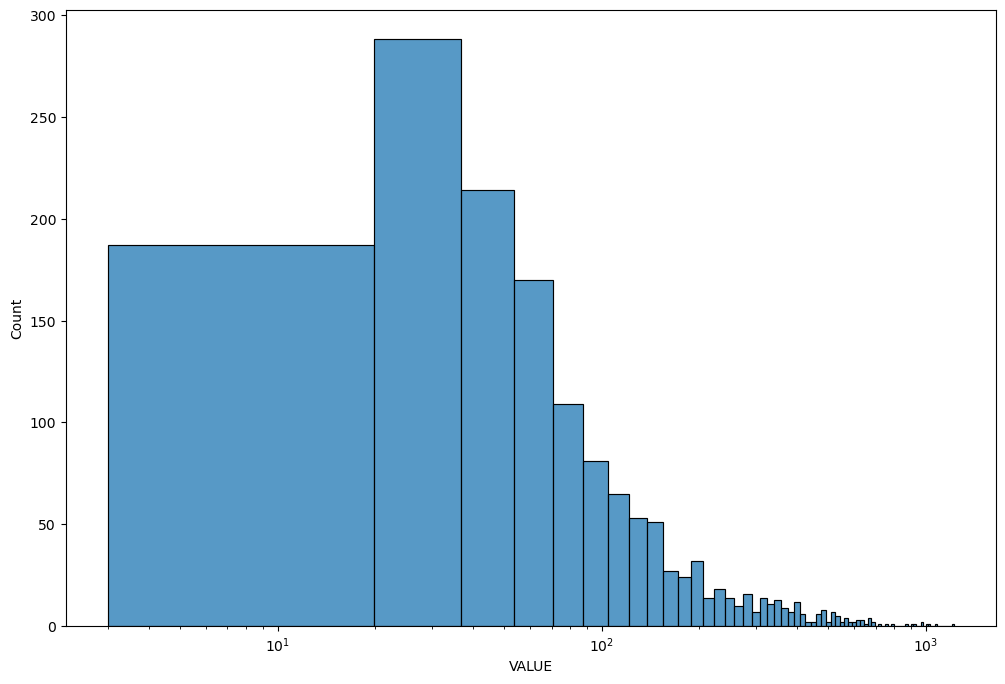

In [111]:
hp = sns.histplot(data=df_ie_ndq5_cleaned, x='VALUE')
hp.set_xscale('log')
plt.show()

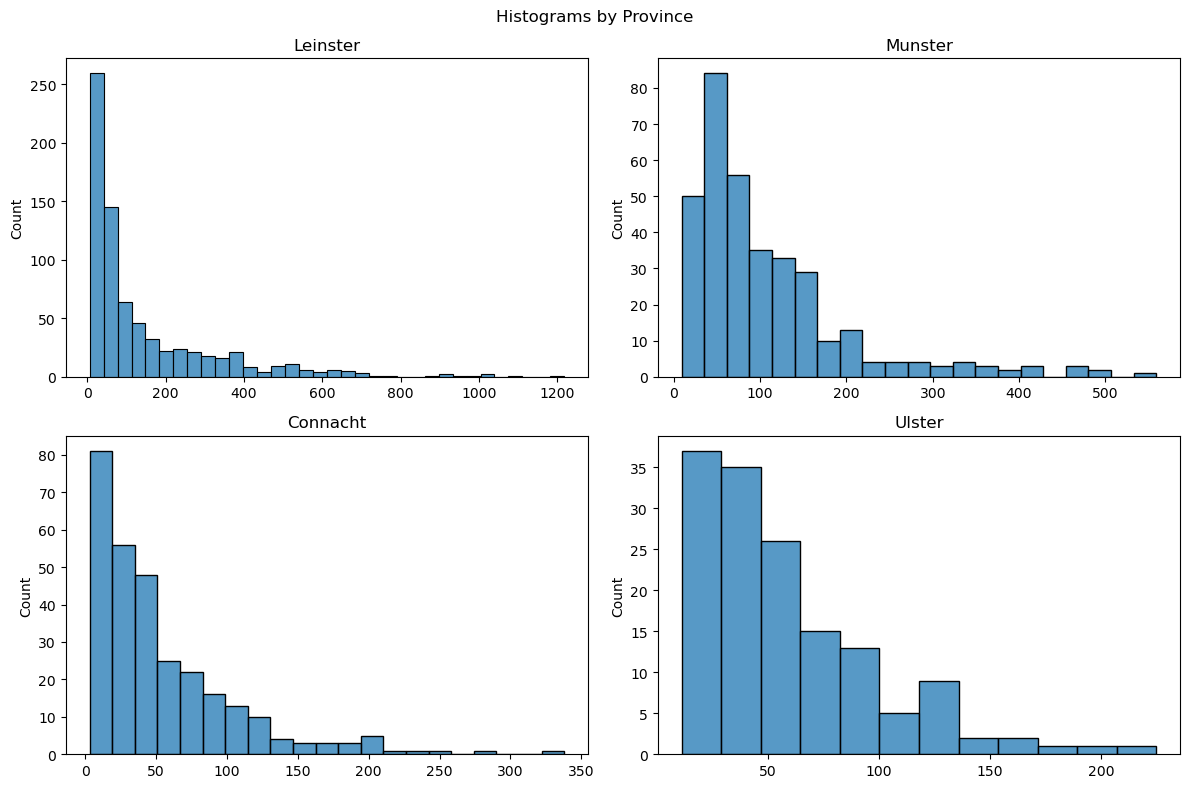

In [112]:
# Create figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Create histograms
sns.histplot(data=df_ie_ndq5_cleaned[df_ie_ndq5_cleaned['province']=='Leinster'], x="VALUE", kde=False, ax=axs[0, 0])
sns.histplot(data=df_ie_ndq5_cleaned[df_ie_ndq5_cleaned['province']=='Munster'], x="VALUE", kde=False, ax=axs[0, 1])
sns.histplot(data=df_ie_ndq5_cleaned[df_ie_ndq5_cleaned['province']=='Connacht'], x="VALUE", kde=False, ax=axs[1, 0])
sns.histplot(data=df_ie_ndq5_cleaned[df_ie_ndq5_cleaned['province']=='Ulster'], x="VALUE", kde=False, ax=axs[1, 1])

# Set titles and axis labels
axs[0, 0].set_title("Leinster")
axs[0, 1].set_title("Munster")
axs[1, 0].set_title("Connacht")
axs[1, 1].set_title("Ulster")
fig.suptitle("Histograms by Province")
for ax in axs.flat:
    ax.set(xlabel=None, ylabel="Count")

# Adjust layout
fig.tight_layout()

# Show plot
plt.show()

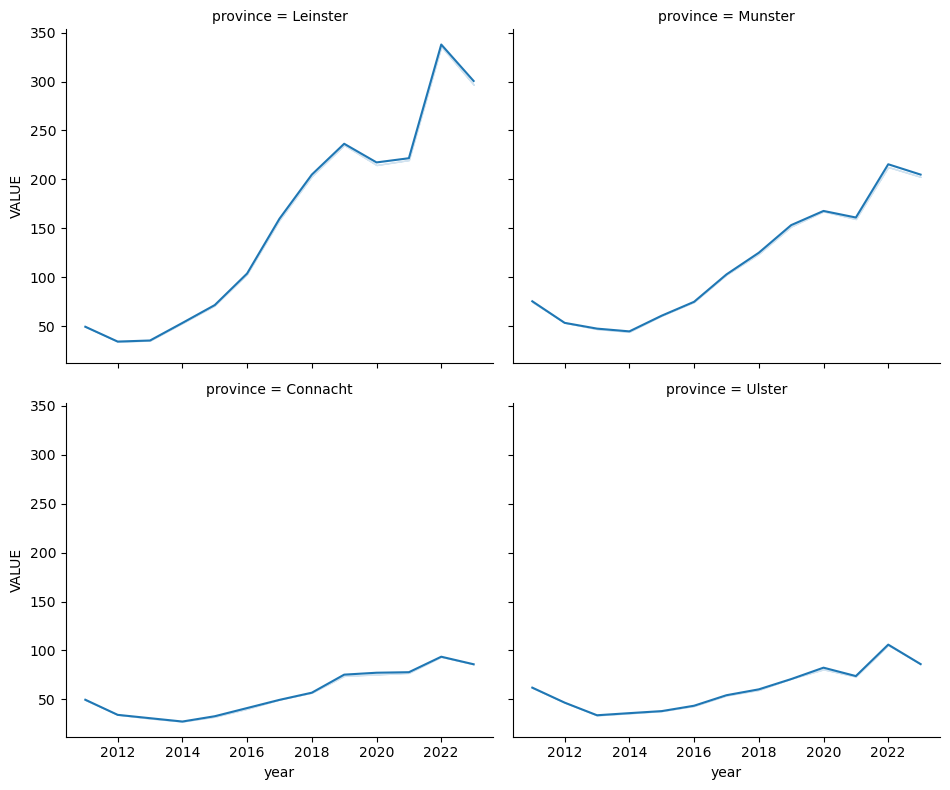

In [113]:
sns.relplot(data=df_ie_ndq5_cleaned, kind='line', x='year', y='VALUE', 
            col='province', col_wrap=2, height=4, aspect=1.2, legend=True, errorbar=('ci', False))
plt.show()

## IE DF no.4

In [114]:
df_ie_ndq6 = deepcopy(df_ie_ndq6_orig)

In [115]:
df_ie_ndq6.head(10)

,STATISTIC,STATISTIC Label,TLIST(Q1),Quarter,C02342V02816,Type of House,C03789V04537,Local Authority,UNIT,VALUE
0,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-1434-13a3-e055-000000000001,Cork City Council,Number,8
1,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-14a2-13a3-e055-000000000001,Clare County Council,Number,45
2,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-149d-13a3-e055-000000000001,Cavan County Council,Number,21
3,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-14a3-13a3-e055-000000000001,Cork County Council,Number,145
4,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-1492-13a3-e055-000000000001,Carlow County Council,Number,17
5,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-1433-13a3-e055-000000000001,Dublin City Council,Number,6
6,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-149f-13a3-e055-000000000001,Dún Laoghaire Rathdown County Council,Number,16
7,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-14a4-13a3-e055-000000000001,Donegal County Council,Number,82
8,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-14a0-13a3-e055-000000000001,Fingal County Council,Number,17
9,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-14a5-13a3-e055-000000000001,Galway County Council,Number,92


In [116]:
df_ie_ndq6 = extract_year_and_qtr(df_ie_ndq6, 'Quarter')

In [117]:
# From previous cleaning we know that C02342V02816 & C03789V04537 map to type of house & local authority.
list_cols_to_drop = ['STATISTIC', 'TLIST(Q1)', 'C02342V02816', 'C03789V04537', 'UNIT']
df_ie_ndq6 = df_ie_ndq6.drop(list_cols_to_drop, axis=1)

In [118]:
df_ie_ndq6.head(10)

,STATISTIC Label,Quarter,Type of House,Local Authority,VALUE,year,qtr
0,New Dwelling Completion,2011Q1,Single house,Cork City Council,8,2011,Q1
1,New Dwelling Completion,2011Q1,Single house,Clare County Council,45,2011,Q1
2,New Dwelling Completion,2011Q1,Single house,Cavan County Council,21,2011,Q1
3,New Dwelling Completion,2011Q1,Single house,Cork County Council,145,2011,Q1
4,New Dwelling Completion,2011Q1,Single house,Carlow County Council,17,2011,Q1
5,New Dwelling Completion,2011Q1,Single house,Dublin City Council,6,2011,Q1
6,New Dwelling Completion,2011Q1,Single house,Dún Laoghaire Rathdown County Council,16,2011,Q1
7,New Dwelling Completion,2011Q1,Single house,Donegal County Council,82,2011,Q1
8,New Dwelling Completion,2011Q1,Single house,Fingal County Council,17,2011,Q1
9,New Dwelling Completion,2011Q1,Single house,Galway County Council,92,2011,Q1


In [119]:
df_ie_ndq6.describe(include='all')

,STATISTIC Label,Quarter,Type of House,Local Authority,VALUE,year,qtr
count,6272,6272,6272,6272,6272.000000,6272.000000,6272
unique,1,49,4,32,NaN,NaN,4
top,New Dwelling Completion,2011Q1,Single house,Cork City Council,NaN,NaN,Q1
freq,6272,128,1568,196,NaN,NaN,1664
mean,NaN,NaN,NaN,NaN,108.416454,2016.632653,NaN
std,NaN,NaN,NaN,NaN,430.696441,3.538377,NaN
min,NaN,NaN,NaN,NaN,0.000000,2011.000000,NaN
25%,NaN,NaN,NaN,NaN,6.000000,2014.000000,NaN
50%,NaN,NaN,NaN,NaN,24.000000,2017.000000,NaN
75%,NaN,NaN,NaN,NaN,64.000000,2020.000000,NaN


In [120]:
df_ie_ndq6['auth_comp'] = df_ie_ndq6['Local Authority'].apply(lambda x: 'CC' if x != "Ireland" else x)

In [121]:
df_ie_ndq6.head()

,STATISTIC Label,Quarter,Type of House,Local Authority,VALUE,year,qtr,auth_comp
0,New Dwelling Completion,2011Q1,Single house,Cork City Council,8,2011,Q1,CC
1,New Dwelling Completion,2011Q1,Single house,Clare County Council,45,2011,Q1,CC
2,New Dwelling Completion,2011Q1,Single house,Cavan County Council,21,2011,Q1,CC
3,New Dwelling Completion,2011Q1,Single house,Cork County Council,145,2011,Q1,CC
4,New Dwelling Completion,2011Q1,Single house,Carlow County Council,17,2011,Q1,CC


In [122]:
df_ie_ndq6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6272 entries, 0 to 6271
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATISTIC Label  6272 non-null   object
 1   Quarter          6272 non-null   object
 2   Type of House    6272 non-null   object
 3   Local Authority  6272 non-null   object
 4   VALUE            6272 non-null   int64 
 5   year             6272 non-null   int64 
 6   qtr              6272 non-null   object
 7   auth_comp        6272 non-null   object
dtypes: int64(2), object(6)
memory usage: 392.1+ KB


In [123]:
df_ie_ndq6.nunique()

STATISTIC Label      1
Quarter             49
Type of House        4
Local Authority     32
VALUE              594
year                13
qtr                  4
auth_comp            2
dtype: int64

Duplication for fields Type of House & Local Authority.

In [124]:
ndq6_total = df_ie_ndq6[(df_ie_ndq6['auth_comp']=='CC') & (df_ie_ndq6['Type of House']=='All house types')]['VALUE'].sum()


In [125]:
print(f"NDQ1: {ndq1_total}, NDQ3: {ndq3_total}, NDQ5: {ndq5_total}, NDQ6: {ndq6_total}")
print(ndq1_total - ndq6_total)

NDQ1: 169997, NDQ3: 169985, NDQ5: 169997, NDQ6: 169997
0


In [126]:
df_ie_ndq6_cleaned = county_mapping(df_ie_ndq6, dict_county_mapping)

In [127]:
df_ie_ndq6_cleaned.head(10)

,STATISTIC Label,Quarter,Type of House,year,qtr,auth_comp,county,VALUE,province
0,New Dwelling Completion,2011Q1,All house types,2011,Q1,CC,Carlow,17,Leinster
1,New Dwelling Completion,2011Q1,All house types,2011,Q1,CC,Cavan,61,Ulster
2,New Dwelling Completion,2011Q1,All house types,2011,Q1,CC,Clare,52,Munster
3,New Dwelling Completion,2011Q1,All house types,2011,Q1,CC,Cork,207,Munster
4,New Dwelling Completion,2011Q1,All house types,2011,Q1,CC,Donegal,118,Ulster
5,New Dwelling Completion,2011Q1,All house types,2011,Q1,CC,Dublin,287,Leinster
6,New Dwelling Completion,2011Q1,All house types,2011,Q1,CC,Galway,108,Connacht
7,New Dwelling Completion,2011Q1,All house types,2011,Q1,CC,Kerry,62,Munster
8,New Dwelling Completion,2011Q1,All house types,2011,Q1,CC,Kildare,126,Leinster
9,New Dwelling Completion,2011Q1,All house types,2011,Q1,CC,Kilkenny,40,Leinster


In [128]:
assert(df_ie_ndq6_cleaned['VALUE'].sum() == df_ie_ndq6_orig['VALUE'].sum())

In [129]:
df_ie_ndq6_cleaned['prov_county_house'] = df_ie_ndq6_cleaned['province'].str.strip() +"-"+ \
                                            df_ie_ndq6_cleaned['county'].str.strip() +"-"+ \
                                            df_ie_ndq6_cleaned['Type of House']

In [130]:
df_ie_ndq6_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5292 entries, 0 to 5291
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   STATISTIC Label    5292 non-null   object
 1   Quarter            5292 non-null   object
 2   Type of House      5292 non-null   object
 3   year               5292 non-null   int64 
 4   qtr                5292 non-null   object
 5   auth_comp          5292 non-null   object
 6   county             5292 non-null   object
 7   VALUE              5292 non-null   int64 
 8   province           5096 non-null   object
 9   prov_county_house  5096 non-null   object
dtypes: int64(2), object(8)
memory usage: 454.8+ KB


# Remove the 'Ireland' county to avoid duplication

In [131]:
df_ie_ndq6_cleaned[(df_ie_ndq6_cleaned['county']!='Ireland')].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5096 entries, 0 to 5290
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   STATISTIC Label    5096 non-null   object
 1   Quarter            5096 non-null   object
 2   Type of House      5096 non-null   object
 3   year               5096 non-null   int64 
 4   qtr                5096 non-null   object
 5   auth_comp          5096 non-null   object
 6   county             5096 non-null   object
 7   VALUE              5096 non-null   int64 
 8   province           5096 non-null   object
 9   prov_county_house  5096 non-null   object
dtypes: int64(2), object(8)
memory usage: 437.9+ KB


# Remove 'All house types' to avoid duplication

In [132]:
df_ie_ndq6_cleaned = df_ie_ndq6_cleaned[(df_ie_ndq6_cleaned['county']!='Ireland') & (df_ie_ndq6_cleaned['Type of House']!='All house types')]


In [133]:
df_ie_ndq6_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3822 entries, 27 to 5290
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   STATISTIC Label    3822 non-null   object
 1   Quarter            3822 non-null   object
 2   Type of House      3822 non-null   object
 3   year               3822 non-null   int64 
 4   qtr                3822 non-null   object
 5   auth_comp          3822 non-null   object
 6   county             3822 non-null   object
 7   VALUE              3822 non-null   int64 
 8   province           3822 non-null   object
 9   prov_county_house  3822 non-null   object
dtypes: int64(2), object(8)
memory usage: 328.5+ KB


In [134]:
df_ie_ndq6_pivot = df_ie_ndq6_cleaned.pivot_table(index=['Quarter'], columns=['prov_county_house'], values='VALUE', aggfunc='sum', fill_value=0).reset_index()


In [135]:
df_ie_ndq6_pivot.head()

prov_county_house,Quarter,Connacht-Galway-Apartment,Connacht-Galway-Scheme house,Connacht-Galway-Single house,Connacht-Leitrim-Apartment,Connacht-Leitrim-Scheme house,Connacht-Leitrim-Single house,Connacht-Mayo-Apartment,Connacht-Mayo-Scheme house,Connacht-Mayo-Single house,...,Munster-Waterford-Single house,Ulster-Cavan-Apartment,Ulster-Cavan-Scheme house,Ulster-Cavan-Single house,Ulster-Donegal-Apartment,Ulster-Donegal-Scheme house,Ulster-Donegal-Single house,Ulster-Monaghan-Apartment,Ulster-Monaghan-Scheme house,Ulster-Monaghan-Single house
0,2011Q1,7,6,95,22,0,20,0,3,64,...,35,1,39,21,12,24,82,0,3,23
1,2011Q2,1,13,111,0,0,13,4,9,46,...,26,0,1,27,1,32,106,1,0,20
2,2011Q3,8,6,100,0,0,14,10,39,75,...,23,0,2,43,1,15,99,2,2,29
3,2011Q4,2,10,113,0,1,15,0,14,74,...,32,0,14,23,6,4,78,1,4,27
4,2012Q1,9,4,70,0,0,15,0,6,35,...,11,0,1,19,10,35,69,1,21,20


In [136]:
df_ie_ndq6_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 79 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Quarter                          49 non-null     object
 1   Connacht-Galway-Apartment        49 non-null     int64 
 2   Connacht-Galway-Scheme house     49 non-null     int64 
 3   Connacht-Galway-Single house     49 non-null     int64 
 4   Connacht-Leitrim-Apartment       49 non-null     int64 
 5   Connacht-Leitrim-Scheme house    49 non-null     int64 
 6   Connacht-Leitrim-Single house    49 non-null     int64 
 7   Connacht-Mayo-Apartment          49 non-null     int64 
 8   Connacht-Mayo-Scheme house       49 non-null     int64 
 9   Connacht-Mayo-Single house       49 non-null     int64 
 10  Connacht-Roscommon-Apartment     49 non-null     int64 
 11  Connacht-Roscommon-Scheme house  49 non-null     int64 
 12  Connacht-Roscommon-Single house  49 no

In [137]:
df_ie_ndq6_pivot.describe()

prov_county_house,Connacht-Galway-Apartment,Connacht-Galway-Scheme house,Connacht-Galway-Single house,Connacht-Leitrim-Apartment,Connacht-Leitrim-Scheme house,Connacht-Leitrim-Single house,Connacht-Mayo-Apartment,Connacht-Mayo-Scheme house,Connacht-Mayo-Single house,Connacht-Roscommon-Apartment,...,Munster-Waterford-Single house,Ulster-Cavan-Apartment,Ulster-Cavan-Scheme house,Ulster-Cavan-Single house,Ulster-Donegal-Apartment,Ulster-Donegal-Scheme house,Ulster-Donegal-Single house,Ulster-Monaghan-Apartment,Ulster-Monaghan-Scheme house,Ulster-Monaghan-Single house
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,...,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,17.306122,58.857143,95.306122,1.428571,3.326531,10.204082,2.857143,19.163265,53.959184,1.632653,...,25.326531,2.244898,9.836735,25.265306,5.693878,23.632653,71.653061,1.938776,12.714286,25.265306
std,19.352222,61.850627,24.085096,3.378856,5.490096,3.856702,3.617089,19.032151,14.909392,2.176521,...,9.900311,3.848867,11.106205,7.308031,8.813352,22.464503,17.287461,3.223664,17.203440,8.373509
min,0.000000,0.000000,55.000000,0.000000,0.000000,4.000000,0.000000,0.000000,26.000000,0.000000,...,10.000000,0.000000,0.000000,11.000000,0.000000,0.000000,39.000000,0.000000,0.000000,11.000000
25%,6.000000,6.000000,73.000000,0.000000,0.000000,7.000000,0.000000,5.000000,44.000000,0.000000,...,17.000000,0.000000,2.000000,21.000000,0.000000,9.000000,59.000000,0.000000,1.000000,18.000000
50%,9.000000,38.000000,95.000000,0.000000,1.000000,10.000000,2.000000,13.000000,52.000000,1.000000,...,26.000000,0.000000,6.000000,24.000000,2.000000,15.000000,73.000000,1.000000,5.000000,26.000000
75%,20.000000,99.000000,113.000000,2.000000,4.000000,13.000000,4.000000,33.000000,67.000000,3.000000,...,31.000000,3.000000,15.000000,30.000000,8.000000,31.000000,82.000000,2.000000,18.000000,32.000000
max,90.000000,217.000000,143.000000,22.000000,24.000000,20.000000,15.000000,84.000000,82.000000,9.000000,...,52.000000,20.000000,47.000000,43.000000,43.000000,102.000000,112.000000,16.000000,81.000000,41.000000


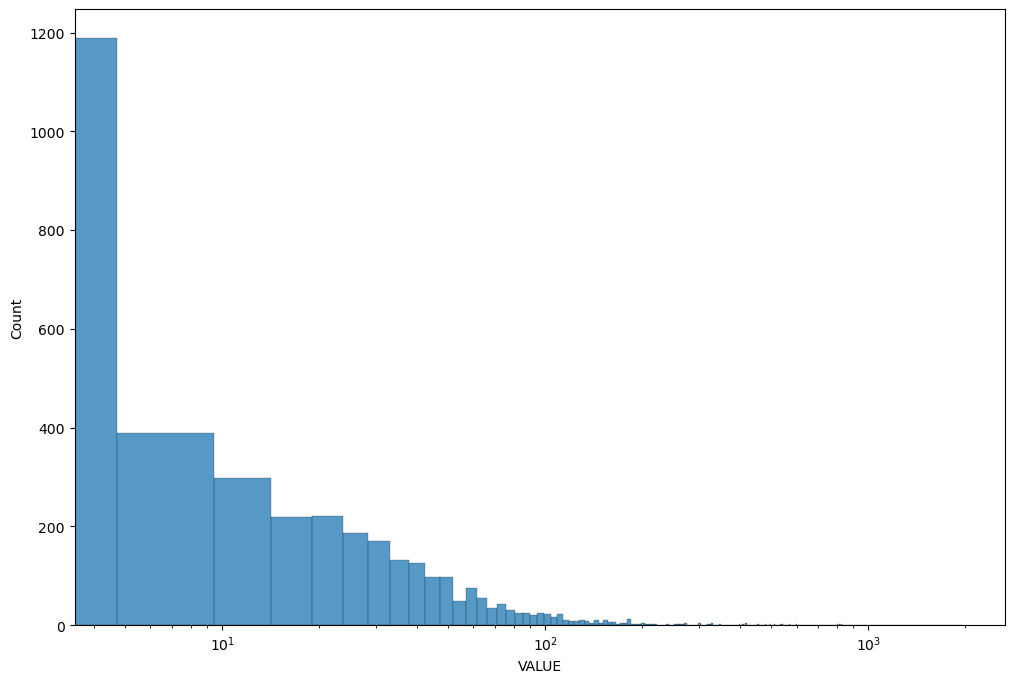

In [138]:
hp = sns.histplot(data=df_ie_ndq6_cleaned, x='VALUE')
hp.set_xscale('log')
plt.show()

In [139]:
df_ie_ndq6_cleaned['VALUE'].min()

0

In [140]:
df_ie_ndq6_cleaned[df_ie_ndq6_cleaned['VALUE']==0]

,STATISTIC Label,Quarter,Type of House,year,qtr,auth_comp,county,VALUE,province,prov_county_house
27,New Dwelling Completion,2011Q1,Apartment,2011,Q1,CC,Carlow,0,Leinster,Leinster-Carlow-Apartment
37,New Dwelling Completion,2011Q1,Apartment,2011,Q1,CC,Laois,0,Leinster,Leinster-Laois-Apartment
40,New Dwelling Completion,2011Q1,Apartment,2011,Q1,CC,Longford,0,Leinster,Leinster-Longford-Apartment
41,New Dwelling Completion,2011Q1,Apartment,2011,Q1,CC,Louth,0,Leinster,Leinster-Louth-Apartment
42,New Dwelling Completion,2011Q1,Apartment,2011,Q1,CC,Mayo,0,Connacht,Connacht-Mayo-Apartment
...,...,...,...,...,...,...,...,...,...,...
5012,New Dwelling Completion,2022Q3,Apartment,2022,Q3,CC,Monaghan,0,Ulster,Ulster-Monaghan-Apartment
5105,New Dwelling Completion,2022Q4,Apartment,2022,Q4,CC,Clare,0,Munster,Munster-Clare-Apartment
5114,New Dwelling Completion,2022Q4,Apartment,2022,Q4,CC,Leitrim,0,Connacht,Connacht-Leitrim-Apartment
5123,New Dwelling Completion,2022Q4,Apartment,2022,Q4,CC,Sligo,0,Connacht,Connacht-Sligo-Apartment


<class 'pandas.core.frame.DataFrame'>
Int64Index: 547 entries, 27 to 5211
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   STATISTIC Label    547 non-null    object
 1   Quarter            547 non-null    object
 2   Type of House      547 non-null    object
 3   year               547 non-null    int64 
 4   qtr                547 non-null    object
 5   auth_comp          547 non-null    object
 6   county             547 non-null    object
 7   VALUE              547 non-null    int64 
 8   province           547 non-null    object
 9   prov_county_house  547 non-null    object
dtypes: int64(2), object(8)
memory usage: 47.0+ KB
None


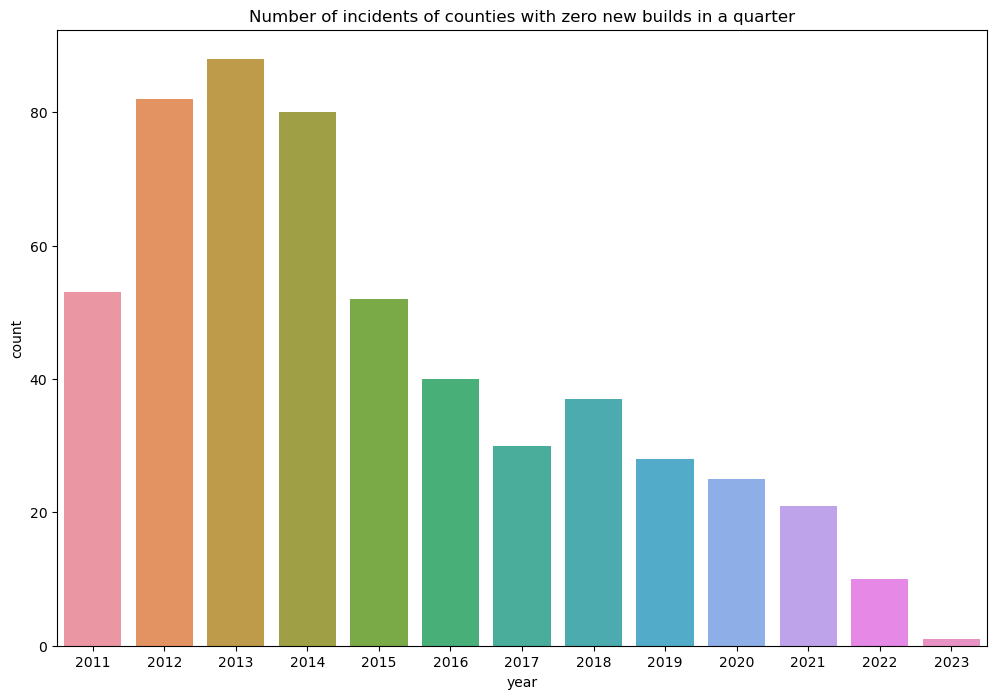

In [141]:
zero_new = df_ie_ndq6_cleaned[df_ie_ndq6_cleaned['VALUE']==0]
print(zero_new.info())
z_plot = sns.countplot(data=zero_new, x='year')
z_plot.set_title('Number of incidents of counties with zero new builds in a quarter')
plt.show()

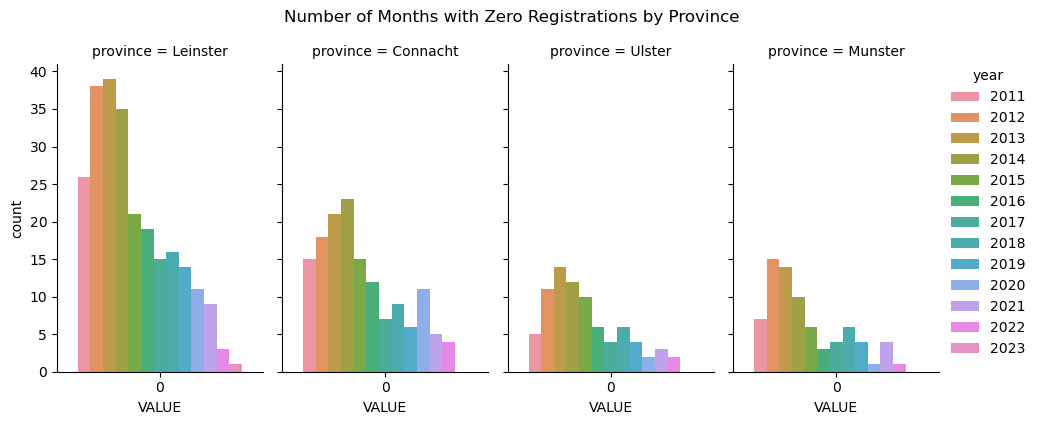

In [142]:
cp = sns.catplot(
    data=zero_new, x="VALUE", col="province", hue='year',
    kind="count", height=4, aspect=0.6
)
cp.fig.suptitle('Number of Months with Zero Registrations by Province', y=1.05)
plt.show()

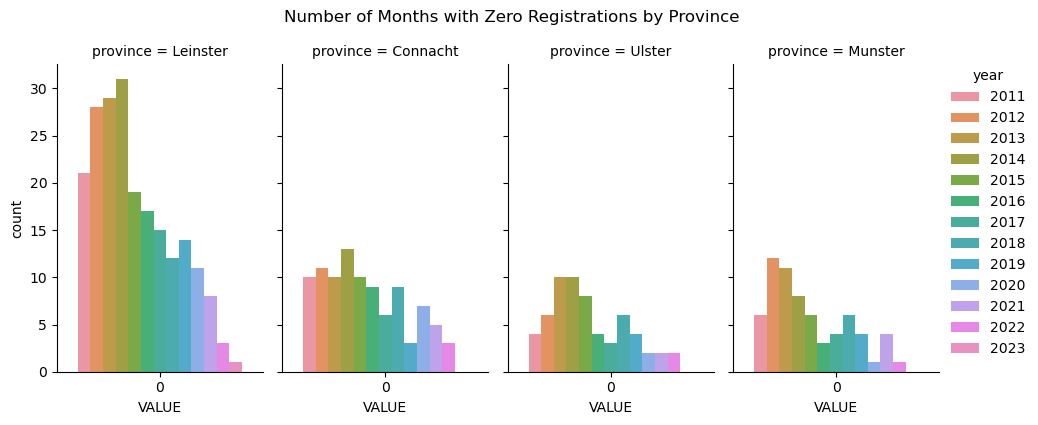

In [143]:
cp = sns.catplot(
    data=zero_new[zero_new['Type of House']=='Apartment'], x="VALUE", col="province", hue='year',
    kind="count", height=4, aspect=0.6
)
cp.fig.suptitle('Number of Months with Zero Registrations by Province', y=1.05)
plt.show()

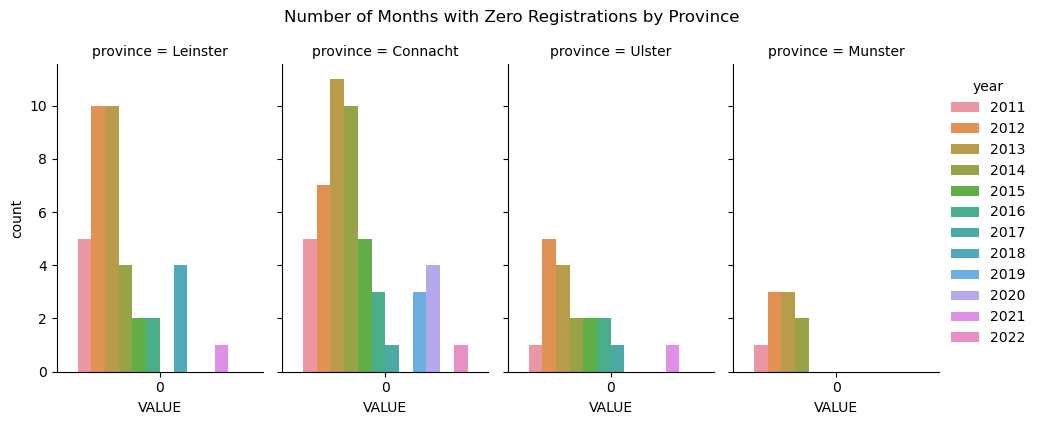

In [144]:
cp = sns.catplot(
    data=zero_new[zero_new['Type of House']=='Scheme house'], x="VALUE", col="province", hue='year',
    kind="count", height=4, aspect=0.6
)
cp.fig.suptitle('Number of Months with Zero Registrations by Province', y=1.05)
plt.show()

## Joining together the IE dataset

In [145]:
df_ie_final = pd.merge(left=df_ie_ndq1_pivot, 
                       right=df_ie_ndq3_pivot, 
                       on='Quarter', how='left')

In [146]:
df_ie_final.head()

,Quarter,year,qtr,All house types,Apartment,Scheme house,Single house,Apartment-Rural areas,Apartment-Urban areas,Scheme house-Rural areas,Scheme house-Urban areas,Single house-Rural areas,Single house-Urban areas
0,2011Q1,2011,Q1,1875,272,447,1156,4,267,25,422,1004,152
1,2011Q2,2011,Q2,1791,217,380,1194,1,215,24,355,1056,136
2,2011Q3,2011,Q3,1687,185,305,1197,0,185,37,268,1048,149
3,2011Q4,2011,Q4,1641,148,226,1267,1,147,20,206,1131,136
4,2012Q1,2012,Q1,1131,123,211,797,5,118,12,199,699,98


In [147]:
df_ie_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 48
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Quarter                   49 non-null     object
 1   year                      49 non-null     int64 
 2   qtr                       49 non-null     object
 3   All house types           49 non-null     int64 
 4   Apartment                 49 non-null     int64 
 5   Scheme house              49 non-null     int64 
 6   Single house              49 non-null     int64 
 7   Apartment-Rural areas     49 non-null     int64 
 8   Apartment-Urban areas     49 non-null     int64 
 9   Scheme house-Rural areas  49 non-null     int64 
 10  Scheme house-Urban areas  49 non-null     int64 
 11  Single house-Rural areas  49 non-null     int64 
 12  Single house-Urban areas  49 non-null     int64 
dtypes: int64(11), object(2)
memory usage: 5.4+ KB


In [148]:
df_ie_final = pd.merge(left=df_ie_final, 
                       right=df_ie_ndq5_pivot, 
                       on='Quarter', how='left')

In [149]:
df_ie_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 48
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Quarter                   49 non-null     object
 1   year                      49 non-null     int64 
 2   qtr                       49 non-null     object
 3   All house types           49 non-null     int64 
 4   Apartment                 49 non-null     int64 
 5   Scheme house              49 non-null     int64 
 6   Single house              49 non-null     int64 
 7   Apartment-Rural areas     49 non-null     int64 
 8   Apartment-Urban areas     49 non-null     int64 
 9   Scheme house-Rural areas  49 non-null     int64 
 10  Scheme house-Urban areas  49 non-null     int64 
 11  Single house-Rural areas  49 non-null     int64 
 12  Single house-Urban areas  49 non-null     int64 
 13  Connacht-Galway           49 non-null     int64 
 14  Connacht-Leitrim          49

In [150]:
df_ie_final = pd.merge(left=df_ie_final, 
                       right=df_ie_ndq6_pivot, 
                       on='Quarter', how='left')

In [151]:
df_ie_final.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 48
Data columns (total 117 columns):
 #    Column                           Dtype 
---   ------                           ----- 
 0    Quarter                          object
 1    year                             int64 
 2    qtr                              object
 3    All house types                  int64 
 4    Apartment                        int64 
 5    Scheme house                     int64 
 6    Single house                     int64 
 7    Apartment-Rural areas            int64 
 8    Apartment-Urban areas            int64 
 9    Scheme house-Rural areas         int64 
 10   Scheme house-Urban areas         int64 
 11   Single house-Rural areas         int64 
 12   Single house-Urban areas         int64 
 13   Connacht-Galway                  int64 
 14   Connacht-Leitrim                 int64 
 15   Connacht-Mayo                    int64 
 16   Connacht-Roscommon               int64 
 17   Connacht-Sligo  

In [152]:
df_ie_final.head()

,Quarter,year,qtr,All house types,Apartment,Scheme house,Single house,Apartment-Rural areas,Apartment-Urban areas,Scheme house-Rural areas,...,Munster-Waterford-Single house,Ulster-Cavan-Apartment,Ulster-Cavan-Scheme house,Ulster-Cavan-Single house,Ulster-Donegal-Apartment,Ulster-Donegal-Scheme house,Ulster-Donegal-Single house,Ulster-Monaghan-Apartment,Ulster-Monaghan-Scheme house,Ulster-Monaghan-Single house
0,2011Q1,2011,Q1,1875,272,447,1156,4,267,25,...,35,1,39,21,12,24,82,0,3,23
1,2011Q2,2011,Q2,1791,217,380,1194,1,215,24,...,26,0,1,27,1,32,106,1,0,20
2,2011Q3,2011,Q3,1687,185,305,1197,0,185,37,...,23,0,2,43,1,15,99,2,2,29
3,2011Q4,2011,Q4,1641,148,226,1267,1,147,20,...,32,0,14,23,6,4,78,1,4,27
4,2012Q1,2012,Q1,1131,123,211,797,5,118,12,...,11,0,1,19,10,35,69,1,21,20


In [153]:
df_ie_for_joining = df_ie_final[['Quarter', 'All house types']]
df_ie_for_joining.columns = ['yr_qtr', 'ie_new']

In [154]:
df_ie_for_joining.head()

,yr_qtr,ie_new
0,2011Q1,1875
1,2011Q2,1791
2,2011Q3,1687
3,2011Q4,1641
4,2012Q1,1131


# DF UK

# Check which sheet to read from the spreadsheet.

In [155]:
df_uk_con_output = deepcopy(df_uk_con_output_orig)

In [156]:
df_uk_con_output_orig.head(50)

,Contents,Unnamed: 1
0,Metadata,Information on the UK house building dataset
1,Quarterly (from Jan-Mar 1978),NaN
2,Table 1a - United Kingdom,House building: permanent dwellings started an...
3,Table 1b - England,House building: permanent dwellings started an...
4,Table 1c - Wales,House building: permanent dwellings started an...
5,Table 1d - Scotland,House building: permanent dwellings started an...
6,Table 1e - Northern Ireland,House building: permanent dwellings started an...
7,Table 1f - Great Britain,House building: permanent dwellings started an...
8,Financial year (from 1969-70),NaN
9,Table 2a - United Kingdom,House building: permanent dwellings started an...


In [157]:
df_uk_con_england_orig = pd.read_excel('./datasets/uk/outputukhousebuilding.xlsx', sheet_name='1b', header=5)
df_uk_con_wales_orig = pd.read_excel('./datasets/uk/outputukhousebuilding.xlsx', sheet_name='1c', header=5)
df_uk_con_scotland_orig = pd.read_excel('./datasets/uk/outputukhousebuilding.xlsx', sheet_name='1d', header=5)
df_uk_con_ni_orig = pd.read_excel('./datasets/uk/outputukhousebuilding.xlsx', sheet_name='1e', header=5)

In [158]:
df_uk_con_england_orig.head(10)

,Revised,Period,Started - All Dwellings,Started - Private Enterprise,Started - Housing Associations,Started - Local Authorities,Completed - All Dwellings,Completed - Private Enterprise,Completed - Housing Associations,Completed - Local Authorities
0,NaN,Jan - Mar 1978,45700,25880,4460,15360,57360,30230,4840,22290
1,NaN,Apr - Jun 1978,69520,39760,4810,24950,61450,32930,4980,23540
2,NaN,Jul - Sep 1978,59340,34490,4590,20270,59160,30620,5260,23280
3,NaN,Oct - Dec 1978,52130,33450,4100,14580,63340,33660,5480,24200
4,NaN,Jan - Mar 1979,31960,19060,3220,9680,43380,24810,4160,14410
5,NaN,Apr - Jun 1979,54080,33300,4130,16650,48790,27840,3450,17490
6,NaN,Jul - Sep 1979,52850,34260,3200,15380,47160,26130,3490,17540
7,NaN,Oct - Dec 1979,51690,34510,3690,13480,70130,39600,5180,25350
8,NaN,Jan - Mar 1980,33160,20470,3140,9560,49600,27730,4550,17320
9,NaN,Apr - Jun 1980,38710,25210,3490,10010,49400,26250,4950,18200


In [159]:
df_uk_con_england = deepcopy(df_uk_con_england_orig)

In [160]:
df_uk_con_england = df_uk_con_england.drop(['Revised'], axis=1)

In [161]:
df_uk_con_england['year'] = df_uk_con_england['Period'].str[-4:]
df_uk_con_england['time_period'] = df_uk_con_england['Period'].str[:-4]

In [162]:
dict_quarter_mapping = {"Jan - Mar": "Q1", "Apr - Jun": "Q2", "Jul - Sep": "Q3", "Oct - Dec": "Q4"}

In [163]:
df_uk_con_england['quarter'] = df_uk_con_england['time_period'].str.strip().replace(dict_quarter_mapping)
df_uk_con_england['yr_qtr'] = df_uk_con_england['year'] + df_uk_con_england['quarter']

In [164]:
list_cols_to_drop = [col for col in df_uk_con_england.columns if "Started" in str(col)]

In [165]:
list_cols_to_drop.extend(['Period', 'time_period'])

In [166]:
df_uk_con_england = df_uk_con_england.drop(list_cols_to_drop, axis=1)

In [167]:
df_uk_con_england.head()

,Completed - All Dwellings,Completed - Private Enterprise,Completed - Housing Associations,Completed - Local Authorities,year,quarter,yr_qtr
0,57360,30230,4840,22290,1978,Q1,1978Q1
1,61450,32930,4980,23540,1978,Q2,1978Q2
2,59160,30620,5260,23280,1978,Q3,1978Q3
3,63340,33660,5480,24200,1978,Q4,1978Q4
4,43380,24810,4160,14410,1979,Q1,1979Q1


In [168]:
df_uk_con_england.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Completed - All Dwellings         179 non-null    int64 
 1   Completed - Private Enterprise    179 non-null    int64 
 2   Completed - Housing Associations  179 non-null    int64 
 3   Completed - Local Authorities     179 non-null    object
 4   year                              179 non-null    object
 5   quarter                           179 non-null    object
 6   yr_qtr                            179 non-null    object
dtypes: int64(3), object(4)
memory usage: 9.9+ KB


In [169]:
s_mask = pd.to_numeric(df_uk_con_england['Completed - Local Authorities'], errors='coerce')

In [170]:
df_uk_con_england[s_mask.isnull()]

,Completed - All Dwellings,Completed - Private Enterprise,Completed - Housing Associations,Completed - Local Authorities,year,quarter,yr_qtr
84,31810,27040,4770,-,1999,Q1,1999Q1
96,31110,27490,3620,-,2002,Q1,2002Q1
99,38880,35370,3500,-,2002,Q4,2002Q4


In [171]:
def prepare_uk_df(df, qtr_dict):
    """
    
    ADD DOCSTRING
    
    """
    df['year'] = df['Period'].str[-4:]
    df['time_period'] = df['Period'].str[:-4]
    df['quarter'] = df['time_period'].str.strip().replace(qtr_dict)
    df['yr_qtr'] = df['year'] + df['quarter']
    list_cols_to_drop = [col for col in df.columns if "Started" in str(col)]
    list_cols_to_drop.extend(['Revised', 'Period', 'time_period'])
    df = df.drop(list_cols_to_drop, axis=1)
    return df

In [172]:
df_uk_con_wales = prepare_uk_df(df_uk_con_wales_orig, dict_quarter_mapping)
df_uk_con_scotland = prepare_uk_df(df_uk_con_scotland_orig, dict_quarter_mapping)
df_uk_con_ni = prepare_uk_df(df_uk_con_ni_orig, dict_quarter_mapping)
df_uk_con_england = prepare_uk_df(df_uk_con_england_orig, dict_quarter_mapping)

In [173]:
df_uk_con_wales

,Completed - All Dwellings,Completed - Private Enterprise,Completed - Housing Associations,Completed - Local Authorities,year,quarter,yr_qtr
0,3060,2030,160,870,1974,Q2,1974Q2
1,2790,1860,10,910,1974,Q3,1974Q3
2,2560,1660,-,900,1974,Q4,1974Q4
3,4020,2300,90,1640,1975,Q1,1975Q1
4,4200,2110,50,2040,1975,Q2,1975Q2
...,...,...,...,...,...,...,...
189,..,..,..,..,2021,Q3,2021Q3
190,..,..,..,..,2021,Q4,2021Q4
191,..,..,..,..,2022,Q1,2022Q1
192,1590,1200,290,100,2022,Q2,2022Q2


In [174]:
df_uk_con_wales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Completed - All Dwellings         194 non-null    object
 1   Completed - Private Enterprise    194 non-null    object
 2   Completed - Housing Associations  194 non-null    object
 3   Completed - Local Authorities     194 non-null    object
 4   year                              194 non-null    object
 5   quarter                           194 non-null    object
 6   yr_qtr                            194 non-null    object
dtypes: object(7)
memory usage: 10.7+ KB


In [175]:
df_uk_con_wales.describe()

,Completed - All Dwellings,Completed - Private Enterprise,Completed - Housing Associations,Completed - Local Authorities,year,quarter,yr_qtr
count,194,194,194,194,194,194,194
unique,124,109,65,63,49,4,194
top,..,..,160,-,1998,Q2,1974Q2
freq,8,8,11,71,4,49,1


In [176]:
def get_non_numeric_values(df):
    non_numeric_values = []
    for col in df.columns:
        if 'Completed' in col:
            series = df[col]
            s_mask = pd.to_numeric(series, errors='coerce')
            non_numeric_values.extend(series[s_mask.isnull()].to_list())
        else:
            pass
    return list(set(non_numeric_values))

In [177]:
def replace_strings_with_zeroes(series, non_numeric_values):
    series = series.apply(lambda x: np.nan if x in non_numeric_values else x)
    series = series.fillna(0)
    return series
#     return series.replace(r'\s', np.nan, regex=True).fillna(0)

In [178]:
def remove_punctuation_from_numeric_cols(df):
    non_numeric_values = get_non_numeric_values(df)
    for col in df.columns:
        if 'Completed' in col:
            df[col] = replace_strings_with_zeroes(df[col], non_numeric_values)
            try:
                df[col] = df[col].astype('int64')
            except Exception as e:
                print(str(e) + f" for column {col}")
    return df

In [179]:
df_uk_con_wales = remove_punctuation_from_numeric_cols(df_uk_con_wales)
df_uk_con_england = remove_punctuation_from_numeric_cols(df_uk_con_england)
df_uk_con_scotland = remove_punctuation_from_numeric_cols(df_uk_con_scotland)
df_uk_con_ni = remove_punctuation_from_numeric_cols(df_uk_con_ni)

In [180]:
df_uk_con_wales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Completed - All Dwellings         194 non-null    int64 
 1   Completed - Private Enterprise    194 non-null    int64 
 2   Completed - Housing Associations  194 non-null    int64 
 3   Completed - Local Authorities     194 non-null    int64 
 4   year                              194 non-null    object
 5   quarter                           194 non-null    object
 6   yr_qtr                            194 non-null    object
dtypes: int64(4), object(3)
memory usage: 10.7+ KB


In [181]:
df_uk_con_wales.describe(include='all')

,Completed - All Dwellings,Completed - Private Enterprise,Completed - Housing Associations,Completed - Local Authorities,year,quarter,yr_qtr
count,194.000000,194.000000,194.000000,194.000000,194,194,194
unique,NaN,NaN,NaN,NaN,49,4,194
top,NaN,NaN,NaN,NaN,1998,Q2,1974Q2
freq,NaN,NaN,NaN,NaN,4,49,1
mean,2128.814433,1608.711340,249.793814,270.773196,NaN,NaN,NaN
std,787.926469,503.551006,192.081478,506.986341,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,1720.000000,1350.000000,112.500000,0.000000,NaN,NaN,NaN
50%,2105.000000,1660.000000,190.000000,20.000000,NaN,NaN,NaN
75%,2540.000000,1927.500000,350.000000,260.000000,NaN,NaN,NaN


In [182]:
df_uk_con_england.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Completed - All Dwellings         179 non-null    int64 
 1   Completed - Private Enterprise    179 non-null    int64 
 2   Completed - Housing Associations  179 non-null    int64 
 3   Completed - Local Authorities     179 non-null    int64 
 4   year                              179 non-null    object
 5   quarter                           179 non-null    object
 6   yr_qtr                            179 non-null    object
dtypes: int64(4), object(3)
memory usage: 9.9+ KB


In [183]:
df_uk_con_england.describe(include='all')

,Completed - All Dwellings,Completed - Private Enterprise,Completed - Housing Associations,Completed - Local Authorities,year,quarter,yr_qtr
count,179.000000,179.000000,179.000000,179.000000,179,179,179
unique,NaN,NaN,NaN,NaN,45,4,179
top,NaN,NaN,NaN,NaN,1978,Q1,1978Q1
freq,NaN,NaN,NaN,NaN,4,45,1
mean,38937.877095,30859.217877,5113.798883,2966.983240,NaN,NaN,NaN
std,7490.560649,5605.946126,1856.433721,5524.855263,NaN,NaN,NaN
min,16640.000000,14180.000000,1790.000000,0.000000,NaN,NaN,NaN
25%,34170.000000,27645.000000,3500.000000,105.000000,NaN,NaN,NaN
50%,38630.000000,30980.000000,4930.000000,360.000000,NaN,NaN,NaN
75%,42650.000000,34675.000000,6655.000000,3850.000000,NaN,NaN,NaN


In [184]:
df_uk_con_scotland.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Completed - All Dwellings         179 non-null    int64 
 1   Completed - Private Enterprise    179 non-null    int64 
 2   Completed - Housing Associations  179 non-null    int64 
 3   Completed - Local Authorities     179 non-null    int64 
 4   year                              179 non-null    object
 5   quarter                           179 non-null    object
 6   yr_qtr                            179 non-null    object
dtypes: int64(4), object(3)
memory usage: 9.9+ KB


In [185]:
df_uk_con_scotland.describe(include='all')

,Completed - All Dwellings,Completed - Private Enterprise,Completed - Housing Associations,Completed - Local Authorities,year,quarter,yr_qtr
count,179.000000,179.000000,179.000000,179.000000,179,179,179
unique,NaN,NaN,NaN,NaN,45,4,179
top,NaN,NaN,NaN,NaN,1978,Q1,1978Q1
freq,NaN,NaN,NaN,NaN,4,45,1
mean,5024.134078,3859.944134,734.581006,442.011173,NaN,NaN,NaN
std,1013.826717,968.126012,415.186729,577.189412,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,4425.000000,3130.000000,400.000000,50.000000,NaN,NaN,NaN
50%,5030.000000,3890.000000,690.000000,280.000000,NaN,NaN,NaN
75%,5585.000000,4540.000000,1005.000000,520.000000,NaN,NaN,NaN


In [186]:
df_uk_con_ni.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Completed - All Dwellings         180 non-null    int64 
 1   Completed - Private Enterprise    180 non-null    int64 
 2   Completed - Housing Associations  180 non-null    int64 
 3   Completed - Local Authorities     180 non-null    int64 
 4   year                              180 non-null    object
 5   quarter                           180 non-null    object
 6   yr_qtr                            180 non-null    object
dtypes: int64(4), object(3)
memory usage: 10.0+ KB


In [187]:
df_uk_con_ni.describe(include='all')

,Completed - All Dwellings,Completed - Private Enterprise,Completed - Housing Associations,Completed - Local Authorities,year,quarter,yr_qtr
count,180.000000,180.000000,180.000000,180.000000,180,180,180
unique,NaN,NaN,NaN,NaN,45,4,180
top,NaN,NaN,NaN,NaN,1978,Q1,1978Q1
freq,NaN,NaN,NaN,NaN,4,45,1
mean,2198.722222,1755.333333,188.611111,256.166667,NaN,NaN,NaN
std,716.580201,791.998674,111.318978,363.075434,NaN,NaN,NaN
min,690.000000,510.000000,0.000000,0.000000,NaN,NaN,NaN
25%,1690.000000,1192.500000,110.000000,0.000000,NaN,NaN,NaN
50%,2005.000000,1600.000000,180.000000,15.000000,NaN,NaN,NaN
75%,2670.000000,2052.500000,252.500000,402.500000,NaN,NaN,NaN


In [188]:
df_uk_con_all_dwellings = df_uk_con_england[['year', 'quarter', 'yr_qtr', 'Completed - All Dwellings']]

In [189]:
list_cols_to_merge = ['yr_qtr', 'Completed - All Dwellings']
df_uk_con_all_dwellings = pd.merge(left=df_uk_con_all_dwellings, right=df_uk_con_wales[list_cols_to_merge],
                                  on='yr_qtr', how='left')
df_uk_con_all_dwellings = pd.merge(left=df_uk_con_all_dwellings, right=df_uk_con_scotland[list_cols_to_merge],
                                  on='yr_qtr', how='left')
df_uk_con_all_dwellings = pd.merge(left=df_uk_con_all_dwellings, right=df_uk_con_ni[list_cols_to_merge],
                                  on='yr_qtr', how='left')
df_uk_con_all_dwellings.columns = ['year', 'quarter', 'yr_qtr', 'england_new', 'scotland_new', 'wales_new', 'ni_new']

C:\Users\emers\AppData\Local\Temp\ipykernel_5300\244862007.py:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Completed - All Dwellings_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_uk_con_all_dwellings = pd.merge(left=df_uk_con_all_dwellings, right=df_uk_con_ni[list_cols_to_merge],


In [190]:
df_uk_con_all_dwellings.head()

,year,quarter,yr_qtr,england_new,scotland_new,wales_new,ni_new
0,1978,Q1,1978Q1,57360,3260,5890,2650
1,1978,Q2,1978Q2,61450,3500,7440,2120
2,1978,Q3,1978Q3,59160,3030,5570,1990
3,1978,Q4,1978Q4,63340,2850,6860,2090
4,1979,Q1,1979Q1,43380,2510,4540,1990


In [191]:
df_uk_con_all_dwellings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 0 to 178
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          179 non-null    object
 1   quarter       179 non-null    object
 2   yr_qtr        179 non-null    object
 3   england_new   179 non-null    int64 
 4   scotland_new  179 non-null    int64 
 5   wales_new     179 non-null    int64 
 6   ni_new        179 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 11.2+ KB


In [192]:
df_uk_con_all_dwellings.describe()

,england_new,scotland_new,wales_new,ni_new
count,179.000000,179.000000,179.000000,179.000000
mean,38937.877095,1998.212291,5024.134078,2200.837989
std,7490.560649,648.936156,1013.826717,718.026221
min,16640.000000,0.000000,0.000000,690.000000
25%,34170.000000,1630.000000,4425.000000,1690.000000
50%,38630.000000,2070.000000,5030.000000,2010.000000
75%,42650.000000,2405.000000,5585.000000,2670.000000
max,70130.000000,3500.000000,7510.000000,4390.000000


In [193]:
df_con_new_all = pd.merge(left=df_ie_for_joining, right=df_uk_con_all_dwellings,
                                  on='yr_qtr', how='left')

In [194]:
col_order = ['year', 'quarter', 'yr_qtr', 'ie_new', 'england_new', 'scotland_new', 'wales_new', 'ni_new']
df_con_new_all = df_con_new_all[col_order]

In [195]:
df_con_new_all.head()

,year,quarter,yr_qtr,ie_new,england_new,scotland_new,wales_new,ni_new
0,2011,Q1,2011Q1,1875,27590.0,1190.0,3510.0,1270.0
1,2011,Q2,2011Q2,1791,29560.0,1620.0,4110.0,1690.0
2,2011,Q3,2011Q3,1687,25010.0,1130.0,3530.0,1270.0
3,2011,Q4,2011Q4,1641,31870.0,1720.0,4140.0,1520.0
4,2012,Q1,2012Q1,1131,32070.0,1110.0,4300.0,1240.0


In [196]:
df_con_new_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 48
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          47 non-null     object 
 1   quarter       47 non-null     object 
 2   yr_qtr        49 non-null     object 
 3   ie_new        49 non-null     int64  
 4   england_new   47 non-null     float64
 5   scotland_new  47 non-null     float64
 6   wales_new     47 non-null     float64
 7   ni_new        47 non-null     float64
dtypes: float64(4), int64(1), object(3)
memory usage: 3.4+ KB


In [197]:
df_con_new_all.describe()

,ie_new,england_new,scotland_new,wales_new,ni_new
count,49.000000,47.000000,47.000000,47.000000,47.000000
mean,3469.326531,36091.489362,1263.829787,4323.404255,1593.829787
std,2176.803538,7802.418794,618.341235,1125.180713,301.356016
min,889.000000,16640.000000,0.000000,0.000000,690.000000
25%,1570.000000,29960.000000,1210.000000,3850.000000,1460.000000
50%,3000.000000,36510.000000,1450.000000,4390.000000,1610.000000
75%,4951.000000,42135.000000,1610.000000,5065.000000,1775.000000
max,9143.000000,51370.000000,2070.000000,6270.000000,2170.000000


In [198]:
df_con_new_clean = pd.melt(df_con_new_all, ['year', 'quarter', 'yr_qtr'])

In [199]:
df_con_new_clean.head()

,year,quarter,yr_qtr,variable,value
0,2011,Q1,2011Q1,ie_new,1875.0
1,2011,Q2,2011Q2,ie_new,1791.0
2,2011,Q3,2011Q3,ie_new,1687.0
3,2011,Q4,2011Q4,ie_new,1641.0
4,2012,Q1,2012Q1,ie_new,1131.0


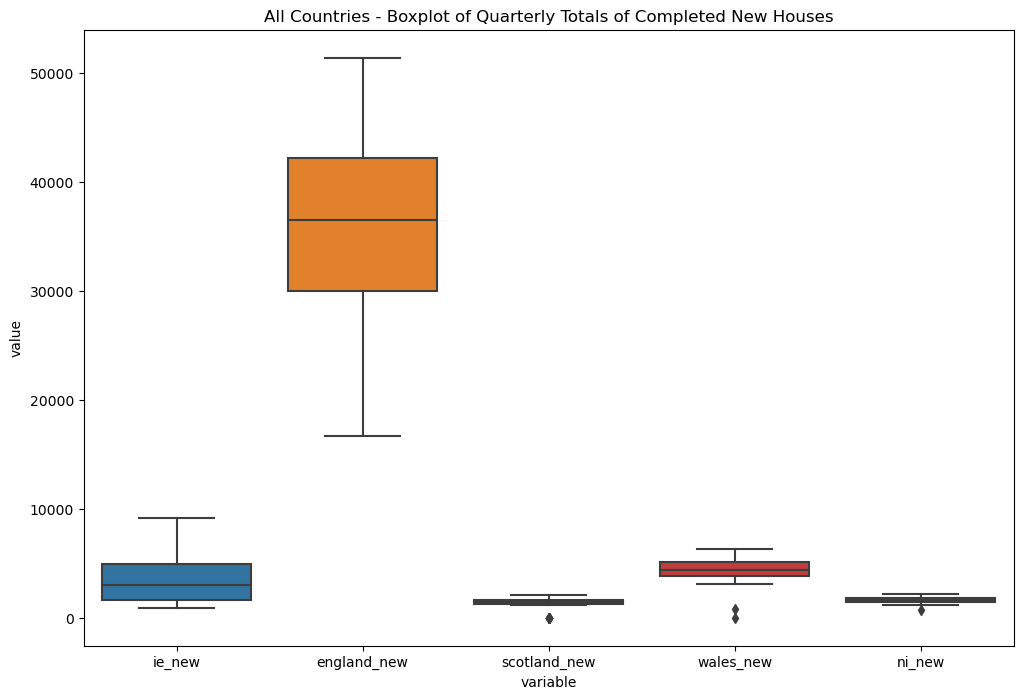

In [200]:
bp = sns.boxplot(data=df_con_new_clean, x='variable', y='value')
bp.set_title("All Countries - Boxplot of Quarterly Totals of Completed New Houses")
plt.show()

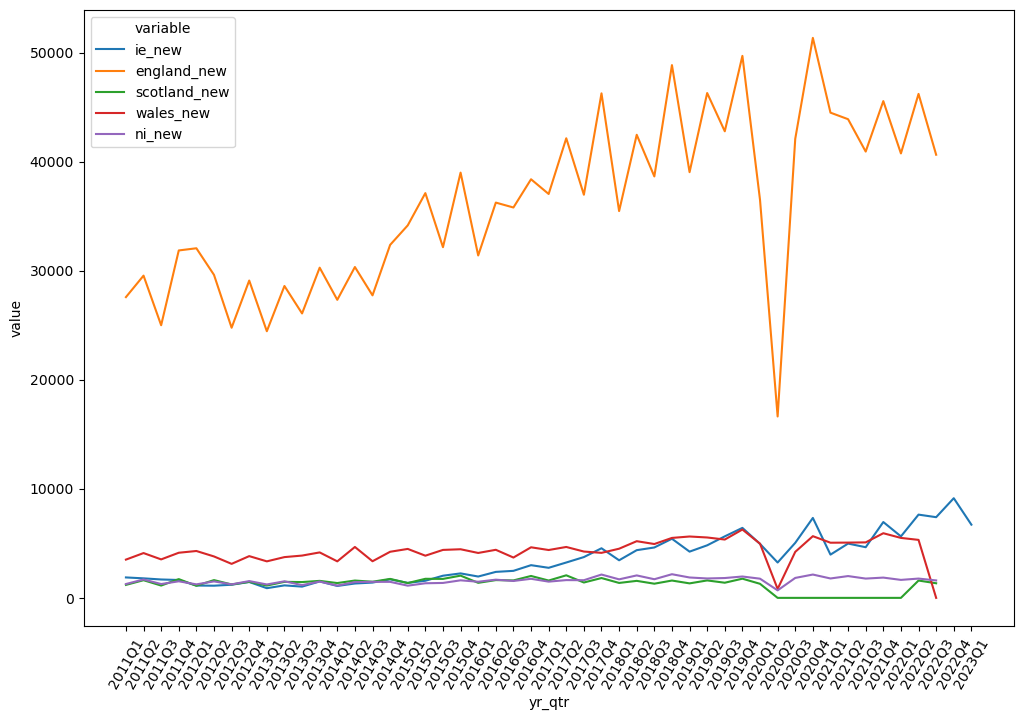

In [201]:
lp = sns.lineplot(data=df_con_new_clean, x='yr_qtr', y='value', hue='variable', errorbar=('ci', False))
plt.xticks(rotation=60)

plt.show()

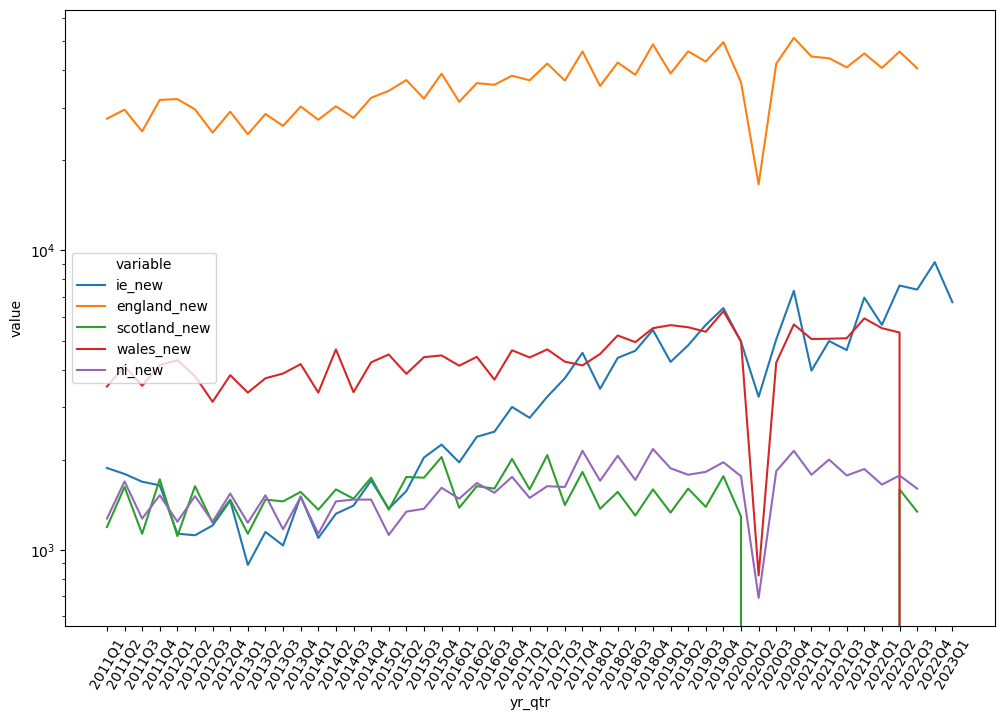

In [202]:
lp = sns.lineplot(data=df_con_new_clean, x='yr_qtr', y='value', hue='variable', errorbar=('ci', False))
lp.set_yscale('log')
plt.xticks(rotation=60)

plt.show()

# DF Population

In [203]:
# https://data.worldbank.org/indicator/SP.POP.TOTL
# Load the XML file
pop_files = glob.glob('./datasets/pop/*.xml')

In [204]:
try:
    with open(pop_files[0], 'r') as file:

        # Print the first 5 lines of the file
        for i in range(20):
            print(file.readline())
except exception as e:
    print('Error: ' + e)
finally:
        file.close()

ï»¿<?xml version="1.0" encoding="utf-8"?>

<Root xmlns:wb="http://www.worldbank.org">

  <data>

    <record>

      <field name="Country or Area" key="ABW">Aruba</field>

      <field name="Item" key="SP.POP.TOTL">Population, total</field>

      <field name="Year">1960</field>

      <field name="Value">54608</field>

    </record>

    <record>

      <field name="Country or Area" key="ABW">Aruba</field>

      <field name="Item" key="SP.POP.TOTL">Population, total</field>

      <field name="Year">1961</field>

      <field name="Value">55811</field>

    </record>

    <record>

      <field name="Country or Area" key="ABW">Aruba</field>

      <field name="Item" key="SP.POP.TOTL">Population, total</field>

      <field name="Year">1962</field>

      <field name="Value">56682</field>



In [205]:
tree = ET.parse(pop_files[0])

# Get the root element of the XML file
root = tree.getroot()

# List to store the parsed xml data before converting to a dataframe
data_list = []

# Loop through the records and append each row of data to the list as a dictionary
# Where the
for record in root.findall('data/record'):
    data_dict = {}
    for field in record.findall('field'):
#         if field.get('name') == 'Item':
#             continue
        name = field.get('name')
        value = field.text
        data_dict[name] = value
    data_list.append(data_dict)

In [206]:
# Create a DataFrame from the list
df_global_population = pd.DataFrame(data_list)

In [207]:
# Print the DataFrame
print(df_global_population['Item'].unique())

['Population, total']


In [208]:
df_global_population.head()

,Country or Area,Item,Year,Value
0,Aruba,"Population, total",1960,54608
1,Aruba,"Population, total",1961,55811
2,Aruba,"Population, total",1962,56682
3,Aruba,"Population, total",1963,57475
4,Aruba,"Population, total",1964,58178


In [209]:
df_global_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16492 entries, 0 to 16491
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country or Area  16492 non-null  object
 1   Item             16492 non-null  object
 2   Year             16492 non-null  object
 3   Value            16400 non-null  object
dtypes: object(4)
memory usage: 515.5+ KB


In [210]:
list_uki_countries = ['Ireland']
df_global_population[df_global_population['Country or Area'].isin(list_uki_countries)]

,Country or Area,Item,Year,Value
6882,Ireland,"Population, total",1960,2828600
6883,Ireland,"Population, total",1961,2824400
6884,Ireland,"Population, total",1962,2836050
6885,Ireland,"Population, total",1963,2852650
6886,Ireland,"Population, total",1964,2866550
...,...,...,...,...
6939,Ireland,"Population, total",2017,4807388
6940,Ireland,"Population, total",2018,4867316
6941,Ireland,"Population, total",2019,4934340
6942,Ireland,"Population, total",2020,4985382


In [211]:
df_ie_pop = df_global_population[df_global_population['Country or Area'].isin(list_uki_countries)]
df_ie_pop_year = df_ie_pop.drop(['Country or Area', 'Item'], axis=1)

In [212]:
df_ie_pop['yr_qtr'] = df_ie_pop['Year'] + "Q1"
df_ie_pop = df_ie_pop.drop(['Country or Area', 'Item', 'Year'], axis=1)
df_ie_pop.columns=['ie_pop', 'yr_qtr']

In [213]:
df_ie_pop.head()

,ie_pop,yr_qtr
6882,2828600,1960Q1
6883,2824400,1961Q1
6884,2836050,1962Q1
6885,2852650,1963Q1
6886,2866550,1964Q1


In [214]:
df_ie_pop_year.head()

,Year,Value
6882,1960,2828600
6883,1961,2824400
6884,1962,2836050
6885,1963,2852650
6886,1964,2866550


In [215]:
df_ie_pop_year.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 6882 to 6943
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Year    62 non-null     object
 1   Value   62 non-null     object
dtypes: object(2)
memory usage: 1.5+ KB


# DF pop 2

# NOTE
These values were estimated in June (Q2) in each reference year.  
When imputing the iternal quarter values, the values should be labeled as Q3

In [216]:
# https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatestimeseriesdataset
df_uk_pop = pd.read_excel('./datasets/pop/pop.xlsx', sheet_name='data', header=1)

C:\Users\emers\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [217]:
df_uk_pop.head()

,CDID,SCPOP,GBPOP,ENPOP,UKPOP,EWPOP,NIPOP,WAPOP
0,PreUnit,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Unit,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Release Date,21-12-2022,21-12-2022,21-12-2022,21-12-2022,21-12-2022,21-12-2022,21-12-2022
3,Next release,Summer 2023,Summer 2023,Summer 2023,Summer 2023,Summer 2023,Summer 2023,Summer 2023
4,Important Notes,NaN,NaN,NaN,[Mid-year population estimates relate to the u...,NaN,NaN,NaN


In [218]:
list_pop_header_rows = ['PreUnit', 'Unit', 'Release Date', 'Next release', 'Important Notes']

In [219]:
df_uk_pop = df_uk_pop[~df_uk_pop['CDID'].isin(list_pop_header_rows)]

In [220]:
df_uk_pop.head()

,CDID,SCPOP,GBPOP,ENPOP,UKPOP,EWPOP,NIPOP,WAPOP
5,1971,5235600,54387600,46411700,55928000,49152000,1540400,2740300
6,1972,5230600,54557700,46571900,56096700,49327100,1539000,2755200
7,1973,5233900,54692900,46686200,56222900,49459000,1530000,2772800
8,1974,5240800,54708700,46682700,56235600,49467900,1526900,2785200
9,1975,5232400,54702200,46674400,56225700,49469800,1523500,2795400


In [221]:
list_pop_cols_to_keep = ['CDID', 'SCPOP', 'ENPOP', 'NIPOP', 'WAPOP']
df_uk_pop = df_uk_pop[list_pop_cols_to_keep]

In [222]:
df_uk_pop.head()

,CDID,SCPOP,ENPOP,NIPOP,WAPOP
5,1971,5235600,46411700,1540400,2740300
6,1972,5230600,46571900,1539000,2755200
7,1973,5233900,46686200,1530000,2772800
8,1974,5240800,46682700,1526900,2785200
9,1975,5232400,46674400,1523500,2795400


In [223]:
df_uk_pop.columns = ['year', 'scotland_pop', 'england_pop', 'ni_pop', 'wales_pop']

In [224]:
df_uk_pop.head()

,year,scotland_pop,england_pop,ni_pop,wales_pop
5,1971,5235600,46411700,1540400,2740300
6,1972,5230600,46571900,1539000,2755200
7,1973,5233900,46686200,1530000,2772800
8,1974,5240800,46682700,1526900,2785200
9,1975,5232400,46674400,1523500,2795400


In [225]:
df_uk_pop_year = deepcopy(df_uk_pop)

In [226]:
df_uk_pop['yr_qtr'] = df_uk_pop['year'] + "Q2"
df_uk_pop_joining = df_uk_pop.drop(['year'], axis=1)

In [227]:
df_uk_pop.head()

,year,scotland_pop,england_pop,ni_pop,wales_pop,yr_qtr
5,1971,5235600,46411700,1540400,2740300,1971Q2
6,1972,5230600,46571900,1539000,2755200,1972Q2
7,1973,5233900,46686200,1530000,2772800,1973Q2
8,1974,5240800,46682700,1526900,2785200,1974Q2
9,1975,5232400,46674400,1523500,2795400,1975Q2


In [228]:
years = np.repeat(df_uk_pop['year'].values, 4)

In [229]:
qtrs = ['Q1', 'Q2', 'Q3', 'Q4'] * len(df_uk_pop['year'].values)

In [230]:
assert(len(qtrs) == len(years))

# Join together population stats
Since UK has the lower number of years, we will use that as the basis for population comparison.

In [231]:
df_base_year_qtr = pd.DataFrame({'year':years, 'qtr':qtrs})
df_base_year_qtr['yr_qtr'] = df_base_year_qtr['year'] + df_base_year_qtr['qtr']

In [232]:
df_base_year_qtr.head()

,year,qtr,yr_qtr
0,1971,Q1,1971Q1
1,1971,Q2,1971Q2
2,1971,Q3,1971Q3
3,1971,Q4,1971Q4
4,1972,Q1,1972Q1


In [233]:
df_pop_all = pd.merge(left=df_base_year_qtr, right=df_uk_pop_joining, on='yr_qtr', how='left')
df_pop_all = pd.merge(left=df_pop_all, right=df_ie_pop, on='yr_qtr', how='left')

In [234]:
df_pop_all.head()

,year,qtr,yr_qtr,scotland_pop,england_pop,ni_pop,wales_pop,ie_pop
0,1971,Q1,1971Q1,NaN,NaN,NaN,NaN,2992050
1,1971,Q2,1971Q2,5235600,46411700,1540400,2740300,NaN
2,1971,Q3,1971Q3,NaN,NaN,NaN,NaN,NaN
3,1971,Q4,1971Q4,NaN,NaN,NaN,NaN,NaN
4,1972,Q1,1972Q1,NaN,NaN,NaN,NaN,3036850


In [235]:
df_pop_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 0 to 203
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          204 non-null    object
 1   qtr           204 non-null    object
 2   yr_qtr        204 non-null    object
 3   scotland_pop  51 non-null     object
 4   england_pop   51 non-null     object
 5   ni_pop        51 non-null     object
 6   wales_pop     51 non-null     object
 7   ie_pop        51 non-null     object
dtypes: object(8)
memory usage: 14.3+ KB


In [236]:
county_cols = [col_name for col_name in df_pop_all.columns if 'pop' in col_name]

In [237]:
df_pop_all[county_cols] = df_pop_all[county_cols].apply(pd.to_numeric)

In [238]:
df_pop_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 0 to 203
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          204 non-null    object 
 1   qtr           204 non-null    object 
 2   yr_qtr        204 non-null    object 
 3   scotland_pop  51 non-null     float64
 4   england_pop   51 non-null     float64
 5   ni_pop        51 non-null     float64
 6   wales_pop     51 non-null     float64
 7   ie_pop        51 non-null     float64
dtypes: float64(5), object(3)
memory usage: 14.3+ KB


In [239]:
df_pop_interpolated = df_pop_all.interpolate(method ='linear', limit_direction ='backward')
df_pop_interpolated = df_pop_interpolated.interpolate(method ='linear', limit_direction ='forward')

In [240]:
df_pop_filled = df_pop_all.fillna(method='ffill')
df_pop_filled = df_pop_filled.fillna(method='bfill')

In [241]:
df_pop_all.head()

,year,qtr,yr_qtr,scotland_pop,england_pop,ni_pop,wales_pop,ie_pop
0,1971,Q1,1971Q1,NaN,NaN,NaN,NaN,2992050.0
1,1971,Q2,1971Q2,5235600.0,46411700.0,1540400.0,2740300.0,NaN
2,1971,Q3,1971Q3,NaN,NaN,NaN,NaN,NaN
3,1971,Q4,1971Q4,NaN,NaN,NaN,NaN,NaN
4,1972,Q1,1972Q1,NaN,NaN,NaN,NaN,3036850.0


In [242]:
df_pop_all_long = df_pop_all.melt(id_vars=['year','qtr','yr_qtr'])

In [243]:
df_pop_interpolated_long = df_pop_interpolated.melt(id_vars=['year','qtr','yr_qtr'])

In [244]:
df_pop_filled_long = df_pop_filled.melt(id_vars=['year','qtr','yr_qtr'])

In [245]:
df_pop_interpolated_long.head()

,year,qtr,yr_qtr,variable,value
0,1971,Q1,1971Q1,scotland_pop,5235600.0
1,1971,Q2,1971Q2,scotland_pop,5235600.0
2,1971,Q3,1971Q3,scotland_pop,5234350.0
3,1971,Q4,1971Q4,scotland_pop,5233100.0
4,1972,Q1,1972Q1,scotland_pop,5231850.0


In [246]:
def get_plot_line_comparison_df(df1, df2, list_col_names, country_name):
    df1 = df1[list_col_names]
    df1 = df1[df1['variable']==country_name]
    df1['type'] = "unfilled"
    
    df2 = df2[list_col_names]
    df2 = df2[df2['variable']==country_name]
    df2['type'] = "filled"
    
    return df1, df2

In [247]:
df1, df2 = get_plot_line_comparison_df(df_pop_all_long, df_pop_filled_long, ["yr_qtr", "variable", "value"], 'scotland_pop')
print(df1.head())
print(df2.head())

   yr_qtr      variable      value      type
0  1971Q1  scotland_pop        NaN  unfilled
1  1971Q2  scotland_pop  5235600.0  unfilled
2  1971Q3  scotland_pop        NaN  unfilled
3  1971Q4  scotland_pop        NaN  unfilled
4  1972Q1  scotland_pop        NaN  unfilled
   yr_qtr      variable      value    type
0  1971Q1  scotland_pop  5235600.0  filled
1  1971Q2  scotland_pop  5235600.0  filled
2  1971Q3  scotland_pop  5235600.0  filled
3  1971Q4  scotland_pop  5235600.0  filled
4  1972Q1  scotland_pop  5235600.0  filled


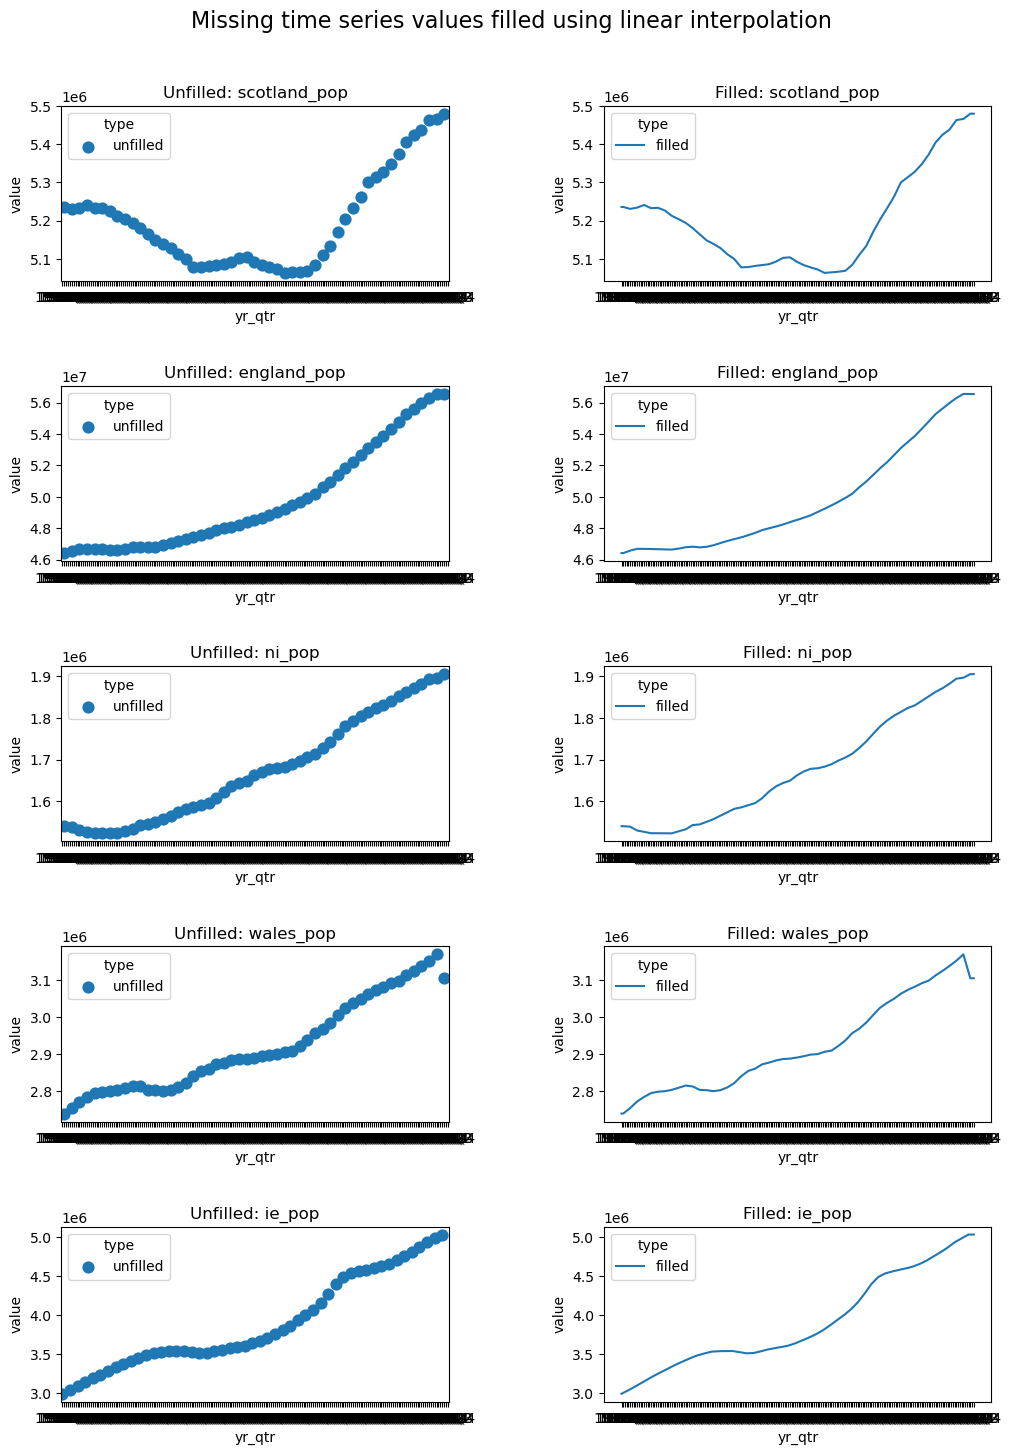

In [248]:
# Create figure with subplots
fig, axs = plt.subplots(5, 2, figsize=(12, 16))

for i, name in enumerate(df_pop_filled_long['variable'].unique()):
    df1, df2 = get_plot_line_comparison_df(df_pop_all_long, df_pop_interpolated_long, ["yr_qtr", "variable", "value"], name)
    sns.pointplot(data=df1, x='yr_qtr', y='value', hue='type', errorbar=None, ax=axs[i, 0]).set(title="Unfilled: " + name)
    sns.lineplot(data=df2, x='yr_qtr', y='value', hue='type', errorbar=None, ax=axs[i, 1]).set(title="Filled: " + name)
fig.suptitle('Missing time series values filled using linear interpolation', fontsize=16)
fig.subplots_adjust(top=0.92, hspace=0.6, wspace=0.4)

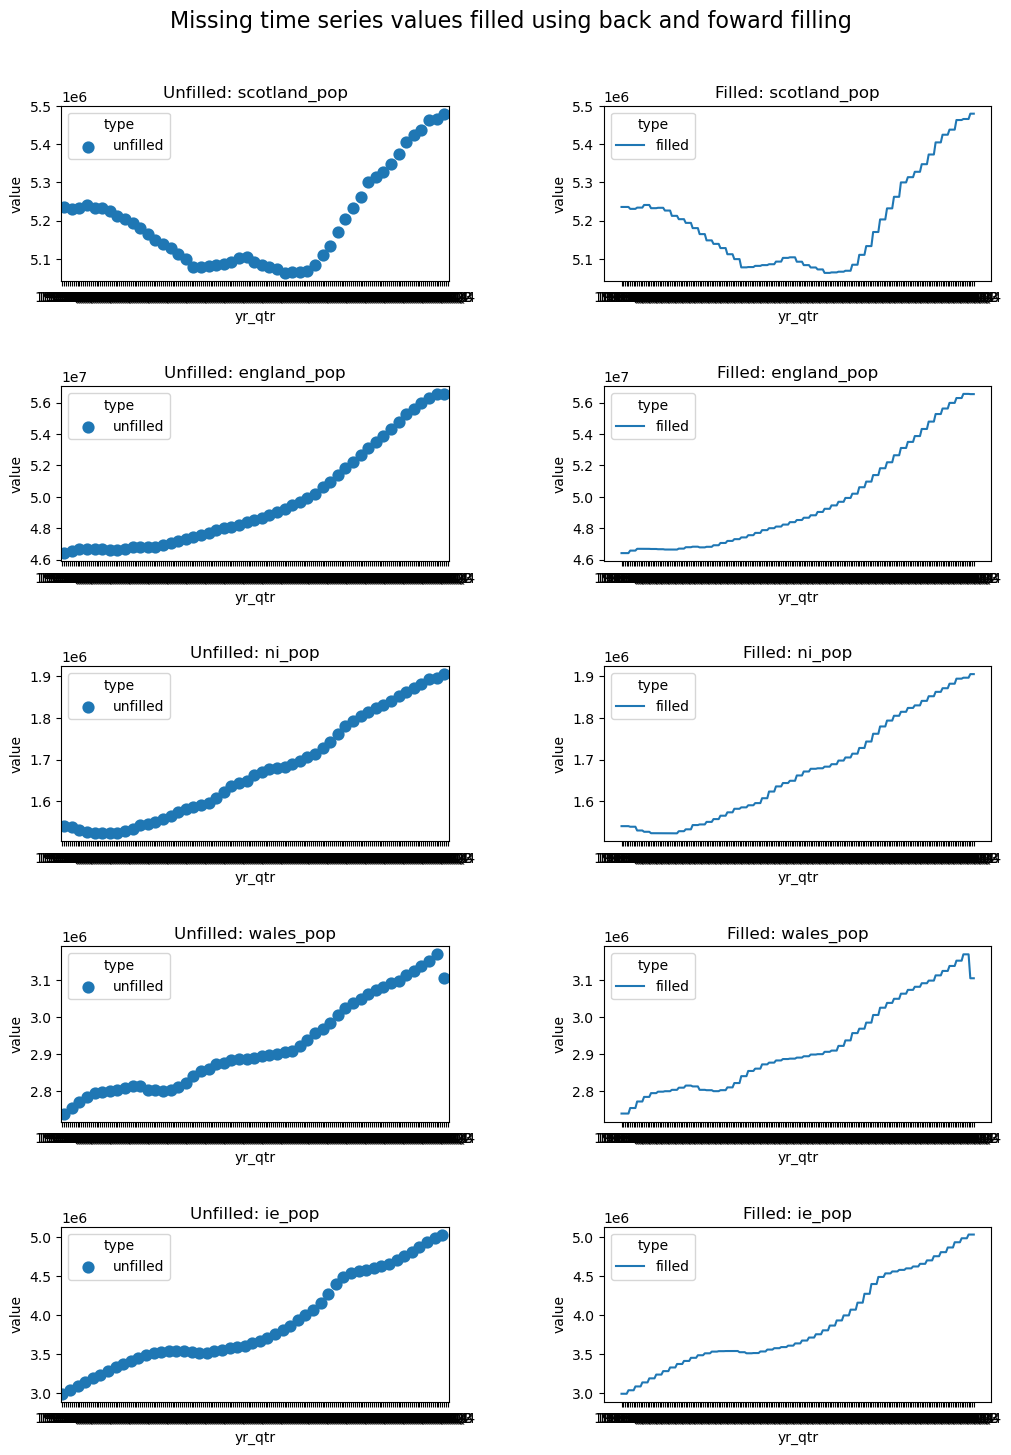

In [249]:
# Create figure with subplots
fig, axs = plt.subplots(5, 2, figsize=(12, 16))

for i, name in enumerate(df_pop_filled_long['variable'].unique()):
    df1, df2 = get_plot_line_comparison_df(df_pop_all_long, df_pop_filled_long, ["yr_qtr", "variable", "value"], name)
    sns.pointplot(data=df1, x='yr_qtr', y='value', hue='type', errorbar=None, ax=axs[i, 0]).set(title="Unfilled: " + name)
    sns.lineplot(data=df2, x='yr_qtr', y='value', hue='type', errorbar=None, ax=axs[i, 1]).set(title="Filled: " + name)
fig.suptitle('Missing time series values filled using back and foward filling', fontsize=16)
fig.subplots_adjust(top=0.92, hspace=0.6, wspace=0.4)

In [250]:
df_pop_interpolated.head()

,year,qtr,yr_qtr,scotland_pop,england_pop,ni_pop,wales_pop,ie_pop
0,1971,Q1,1971Q1,5235600.0,46411700.0,1540400.0,2740300.0,2992050.0
1,1971,Q2,1971Q2,5235600.0,46411700.0,1540400.0,2740300.0,3003250.0
2,1971,Q3,1971Q3,5234350.0,46451750.0,1540050.0,2744025.0,3014450.0
3,1971,Q4,1971Q4,5233100.0,46491800.0,1539700.0,2747750.0,3025650.0
4,1972,Q1,1972Q1,5231850.0,46531850.0,1539350.0,2751475.0,3036850.0


In [251]:
df_pop_interpolated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 0 to 203
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          204 non-null    object 
 1   qtr           204 non-null    object 
 2   yr_qtr        204 non-null    object 
 3   scotland_pop  204 non-null    float64
 4   england_pop   204 non-null    float64
 5   ni_pop        204 non-null    float64
 6   wales_pop     204 non-null    float64
 7   ie_pop        204 non-null    float64
dtypes: float64(5), object(3)
memory usage: 14.3+ KB


In [252]:
df_pop_interpolated.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,scotland_pop,england_pop,ni_pop,wales_pop,ie_pop
count,204.00000,204.00000,204.00000,204.00000,204.00000
mean,5197396.81373,49779835.04902,1675282.84314,2922855.63725,3907330.23775
std,122929.19037,3254397.51954,125007.48884,122252.33484,591209.97281
min,5062900.00000,46411700.00000,1523200.00000,2740300.00000,2992050.00000
25%,5088837.50000,46856881.25000,1553531.25000,2809831.25000,3512306.18750
50%,5171175.00000,48537312.50000,1662987.50000,2891750.00000,3651257.87500
75%,5239175.00000,52125056.25000,1790656.25000,3036462.50000,4536923.75000
max,5479900.00000,56550000.00000,1904600.00000,3170000.00000,5033165.00000


# New housing and estimated population

In [253]:
df_con_and_pop = pd.merge(left=df_con_new_all, right=df_pop_interpolated.drop(['year', 'qtr'], axis=1),
                         on='yr_qtr', how='inner')

In [254]:
df_con_and_pop.head()

,year,quarter,yr_qtr,ie_new,england_new,scotland_new,wales_new,ni_new,scotland_pop,england_pop,ni_pop,wales_pop,ie_pop
0,2011,Q1,2011Q1,1875,27590.0,1190.0,3510.0,1270.0,5290475.0,52991025.0,1811925.0,3060350.0,4580084.00
1,2011,Q2,2011Q2,1791,29560.0,1620.0,4110.0,1690.0,5299900.0,53107200.0,1814300.0,3063800.0,4584946.25
2,2011,Q3,2011Q3,1687,25010.0,1130.0,3530.0,1270.0,5303325.0,53203825.0,1816625.0,3066375.0,4589808.50
3,2011,Q4,2011Q4,1641,31870.0,1720.0,4140.0,1520.0,5306750.0,53300450.0,1818950.0,3068950.0,4594670.75
4,2012,Q1,2012Q1,1131,32070.0,1110.0,4300.0,1240.0,5310175.0,53397075.0,1821275.0,3071525.0,4599533.00


In [255]:
list_countries = ['ie', 'england', 'scotland', 'wales', 'ni']

for country in list_countries:
    col_pop = country + "_pop"
    col_con = country + "_new"
    col_con_per_pop = country + "_builds_per_10k"
    df_con_and_pop[col_con_per_pop] = df_con_and_pop[col_con] / (df_con_and_pop[col_pop]/10000)

In [256]:
df_con_and_pop.head()

,year,quarter,yr_qtr,ie_new,england_new,scotland_new,wales_new,ni_new,scotland_pop,england_pop,ni_pop,wales_pop,ie_pop,ie_builds_per_10k,england_builds_per_10k,scotland_builds_per_10k,wales_builds_per_10k,ni_builds_per_10k
0,2011,Q1,2011Q1,1875,27590.0,1190.0,3510.0,1270.0,5290475.0,52991025.0,1811925.0,3060350.0,4580084.00,4.093811,5.206542,2.249325,11.469276,7.009120
1,2011,Q2,2011Q2,1791,29560.0,1620.0,4110.0,1690.0,5299900.0,53107200.0,1814300.0,3063800.0,4584946.25,3.906262,5.566100,3.056661,13.414714,9.314887
2,2011,Q3,2011Q3,1687,25010.0,1130.0,3530.0,1270.0,5303325.0,53203825.0,1816625.0,3066375.0,4589808.50,3.675535,4.700790,2.130739,11.511964,6.990986
3,2011,Q4,2011Q4,1641,31870.0,1720.0,4140.0,1520.0,5306750.0,53300450.0,1818950.0,3068950.0,4594670.75,3.571529,5.979312,3.241155,13.489956,8.356469
4,2012,Q1,2012Q1,1131,32070.0,1110.0,4300.0,1240.0,5310175.0,53397075.0,1821275.0,3071525.0,4599533.00,2.458945,6.005947,2.090327,13.999560,6.808417


In [257]:
df_con_and_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 0 to 43
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     44 non-null     object 
 1   quarter                  44 non-null     object 
 2   yr_qtr                   44 non-null     object 
 3   ie_new                   44 non-null     int64  
 4   england_new              44 non-null     float64
 5   scotland_new             44 non-null     float64
 6   wales_new                44 non-null     float64
 7   ni_new                   44 non-null     float64
 8   scotland_pop             44 non-null     float64
 9   england_pop              44 non-null     float64
 10  ni_pop                   44 non-null     float64
 11  wales_pop                44 non-null     float64
 12  ie_pop                   44 non-null     float64
 13  ie_builds_per_10k        44 non-null     float64
 14  england_builds_per_10k   44 

In [258]:
df_con_and_pop.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,ie_new,england_new,scotland_new,wales_new,ni_new,scotland_pop,england_pop,ni_pop,wales_pop,ie_pop,ie_builds_per_10k,england_builds_per_10k,scotland_builds_per_10k,wales_builds_per_10k,ni_builds_per_10k
count,44.00000,44.00000,44.00000,44.00000,44.00000,44.00000,44.00000,44.00000,44.00000,44.00000,44.00000,44.00000,44.00000,44.00000,44.00000
mean,3033.15909,35651.13636,1283.40909,4372.27273,1588.40909,5396249.43182,55109755.11364,1861744.88636,3111003.40909,4792360.12500,6.22860,6.45037,2.38411,14.04482,8.51833
std,1796.62073,7844.98958,607.35011,928.40164,310.36320,62733.06185,1185024.61624,29978.65839,30644.44427,155781.26482,3.52223,1.31781,1.12599,2.91036,1.57940
min,889.00000,16640.00000,0.00000,820.00000,690.00000,5290475.00000,52991025.00000,1811925.00000,3060350.00000,4580084.00000,1.92265,2.94253,0.00000,2.58675,3.63924
25%,1494.75000,29612.50000,1220.00000,3860.00000,1430.00000,5336406.25000,54063025.00000,1834425.00000,3086600.00000,4647138.75000,3.22038,5.55932,2.29729,12.47616,7.75585
50%,2431.50000,36035.00000,1460.00000,4345.00000,1580.00000,5407212.50000,55312012.50000,1863187.50000,3105775.00000,4774854.87500,5.09218,6.46640,2.73913,14.03008,8.53883
75%,4568.25000,42122.50000,1622.50000,4992.50000,1780.00000,5458575.00000,56228912.50000,1891431.25000,3135862.50000,4937530.12500,9.26880,7.48024,3.02609,15.84367,9.38196
max,7333.00000,51370.00000,2070.00000,6270.00000,2170.00000,5479900.00000,56550000.00000,1904600.00000,3170000.00000,5033165.00000,14.60402,9.08509,3.81581,19.83267,11.49578


# Get sentiment data

In [259]:
# https://github.com/JustAnotherArchivist/snscrape
# !pip install snscrape

In [260]:
# !pip3 install tweeds

# Twitter data

In [261]:
# https://chrome.google.com/webstore/detail/instant-data-scraper/ofaokhiedipichpaobibbnahnkdoiiah
# Load the XML file
tweet_files = glob.glob('./datasets/twitter/*.xlsx')

In [262]:
tweet_files

['./datasets/twitter\\twitter (1).xlsx',
 './datasets/twitter\\twitter (2).xlsx',
 './datasets/twitter\\twitter (4).xlsx',
 './datasets/twitter\\twitter (5).xlsx',
 './datasets/twitter\\twitter.xlsx']

In [263]:
df_twitter_samp = pd.read_excel(tweet_files[0]).head(50)

In [264]:
df_twitter_samp.head()

,css-4rbku5 href,css-9pa8cd src,css-901oao,css-901oao 2,css-901oao 3,css-4rbku5 href 4,css-4rbku5,css-901oao 4,css-4rbku5 href 5,css-901oao 5,...,css-4rbku5 href 9,css-901oao 10,css-901oao 11,css-4rbku5 href 10,css-901oao 13,css-901oao 14,css-4rbku5 href 11,css-901oao 15,css-4rbku5 9,css-4rbku5 href 15
0,https://twitter.com/Mike_y_San,https://pbs.twimg.com/profile_images/123387640...,EndoftheWorldasWeKnowIt,@Mike_y_San,·,https://twitter.com/Mike_y_San/status/16550157...,May 7,Replying to,https://twitter.com/unionsaustralia,@unionsaustralia,...,https://twitter.com/hashtag/auspol?src=hashtag...,1,1,https://twitter.com/Mike_y_San/status/16550157...,148,NaN,NaN,NaN,NaN,NaN
1,https://twitter.com/writerbyter,https://pbs.twimg.com/profile_images/281408078...,I’m Voting YES—It’s overdue.,@writerbyter,·,https://twitter.com/writerbyter/status/1654988...,May 7,Replying to,https://twitter.com/Crocodylus121,@Crocodylus121,...,NaN,1,3,https://twitter.com/writerbyter/status/1654988...,41,and,https://twitter.com/43a6f0ce5dac4ea,@43a6f0ce5dac4ea,NaN,NaN
2,https://twitter.com/anncherie49,https://pbs.twimg.com/profile_images/122343612...,Ann McGlynn,@anncherie49,·,https://twitter.com/anncherie49/status/1654977...,May 6,NaN,NaN,NaN,...,https://twitter.com/hashtag/auspol?src=hashtag...,1,1,https://twitter.com/anncherie49/status/1654977...,127,NaN,NaN,NaN,NaN,NaN
3,https://twitter.com/SustPopAus,https://pbs.twimg.com/profile_images/725629456...,Sustainable Pop Aus,@SustPopAus,·,https://twitter.com/SustPopAus/status/16549661...,May 6,Replying to,https://twitter.com/WilliamJGoode1,@WilliamJGoode1,...,NaN,1,NaN,https://twitter.com/SustPopAus/status/16549661...,10,NaN,NaN,NaN,NaN,NaN
4,https://twitter.com/unzippedmovie,https://pbs.twimg.com/profile_images/163687166...,UNZIPPED: An Autopsy of American Inequality,@unzippedmovie,·,https://twitter.com/unzippedmovie/status/16549...,May 6,Show this thread,https://twitter.com/unzippedmovie/status/16549...,NaN,...,https://twitter.com/hashtag/documentary?src=ha...,NaN,NaN,https://twitter.com/unzippedmovie/status/16549...,24,NaN,NaN,NaN,#homelessness,https://twitter.com/hashtag/homelessness?src=h...


In [265]:
df_twitter_samp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   css-4rbku5 href     50 non-null     object
 1   css-9pa8cd src      50 non-null     object
 2   css-901oao          50 non-null     object
 3   css-901oao 2        50 non-null     object
 4   css-901oao 3        50 non-null     object
 5   css-4rbku5 href 4   50 non-null     object
 6   css-4rbku5          50 non-null     object
 7   css-901oao 4        43 non-null     object
 8   css-4rbku5 href 5   44 non-null     object
 9   css-901oao 5        30 non-null     object
 10  css-901oao 6        48 non-null     object
 11  css-4rbku5 2        49 non-null     object
 12  css-4rbku5 href 6   49 non-null     object
 13  css-901oao 7        30 non-null     object
 14  css-4rbku5 3        42 non-null     object
 15  css-4rbku5 href 7   42 non-null     object
 16  css-901oao 8        22 non-n

In [266]:
def find_hashtags(text):
    return re.findall(r'#[\w\d]+', text)

def find_mentions(text):
    return re.findall(r'@[\w\d]+', text)

In [267]:
def process_dataframe(df):
    
    # List comprehension to build a list of columns that contain href or src
    cols_to_exclude = [column for column in df.columns
                   for exclude_col in ['href', 'src']
                   if str(exclude_col) in str(column)]
    
    temp_df = df[['css-4rbku5']].rename(columns={'css-4rbku5': 'date'})
    cols = cols_to_exclude.append('css-4rbku5')
    
    df = df.drop(cols_to_exclude, axis=1)
    df = df.fillna("")
    
    temp_df['full_comment'] = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    
    temp_df['hashtags'] = temp_df['full_comment'].apply(find_hashtags)
    temp_df['mentions'] = temp_df['full_comment'].apply(find_mentions)
    
    return temp_df


In [268]:
def build_tweet_dataframe(files):
    # Initialize a dictionary to store dataframes
    dfs = []

    for file in files:
        # Read csv file into dataframe
        df = pd.read_excel(file)
        
        processed_df = process_dataframe(df)
        dfs.append(processed_df)
        
    return pd.concat(dfs, axis=0, ignore_index=True)

In [269]:
df_twitter_text = build_tweet_dataframe(tweet_files)

In [270]:
df_twitter_text.head()

,date,full_comment,hashtags,mentions
0,May 7,EndoftheWorldasWeKnowIt @Mike_y_San · Replying...,"[#housingcrisis, #healthcare, #auspol]","[@Mike_y_San, @unionsaustralia, @AustralianLabor]"
1,May 7,I’m Voting YES—It’s overdue. @writerbyter · Re...,"[#HousingCrisis, #HousingForAll]","[@writerbyter, @Crocodylus121, @43a6f0ce5dac4ea]"
2,May 6,Ann McGlynn @anncherie49 · Karen Andrews mou...,"[#HousingCrisis, #Auspol2023, #auspol]",[@anncherie49]
3,May 6,Sustainable Pop Aus @SustPopAus · Replying to ...,[#HousingCrisis],"[@SustPopAus, @WilliamJGoode1]"
4,May 6,UNZIPPED: An Autopsy of American Inequality @u...,"[#housingcrisis, #unzipped, #documentary, #hom...","[@unzippedmovie, @colinkgray]"


In [271]:
df_twitter_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10691 entries, 0 to 10690
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          10658 non-null  object
 1   full_comment  10691 non-null  object
 2   hashtags      10691 non-null  object
 3   mentions      10691 non-null  object
dtypes: object(4)
memory usage: 334.2+ KB


In [272]:
df_twitter_text['date'].value_counts().head(20)

Mar 29          107
Aug 23, 2022     97
Mar 22           97
Mar 15           92
Apr 29           90
Apr 27           88
Mar 8            78
Mar 27           77
Oct 3, 2022      74
Apr 4            73
Mar 23           71
Apr 26           65
Apr 30           65
Mar 11           65
Mar 28           63
Apr 28           62
Apr 3            62
Mar 20           62
Aug 24, 2022     61
Mar 9            61
Name: date, dtype: int64

In [273]:
dict_month_map = {'Jan': 1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9,
                             'Oct':10, 'Nov':11, 'Dec':12}

In [274]:
df_twitter_text[['month', 'day', 'year']] = df_twitter_text['date'].str.split(' ', expand=True)

In [275]:
df_twitter_text.query('date.isnull()').head()

,date,full_comment,hashtags,mentions,month,day,year
1206,NaN,Van Gogh Exhibit @VanGoghExp Step into a Van G...,[],[@VanGoghExp],NaN,NaN,NaN
1237,NaN,Independent.ie @Independent_ie Subscribe to In...,[],[@Independent_ie],NaN,NaN,NaN
1242,NaN,Nordace @NordaceOfficial Packed with smart fea...,[],[@NordaceOfficial],NaN,NaN,NaN
1255,NaN,Raid: Shadow Legends @RaidRPG ◆ ◇ ━━━━━━━━━━\n...,[],[@RaidRPG],NaN,NaN,NaN
1360,NaN,Folens @FolensEducation Gefällt Mir! is fully ...,[],[@FolensEducation],NaN,NaN,NaN


In [276]:
print(df_twitter_text.query('date.isnull()').shape)

(33, 7)


In [277]:
df_twitter_text.query('year.isnull()').head()

,date,full_comment,hashtags,mentions,month,day,year
0,May 7,EndoftheWorldasWeKnowIt @Mike_y_San · Replying...,"[#housingcrisis, #healthcare, #auspol]","[@Mike_y_San, @unionsaustralia, @AustralianLabor]",May,7,None
1,May 7,I’m Voting YES—It’s overdue. @writerbyter · Re...,"[#HousingCrisis, #HousingForAll]","[@writerbyter, @Crocodylus121, @43a6f0ce5dac4ea]",May,7,None
2,May 6,Ann McGlynn @anncherie49 · Karen Andrews mou...,"[#HousingCrisis, #Auspol2023, #auspol]",[@anncherie49],May,6,None
3,May 6,Sustainable Pop Aus @SustPopAus · Replying to ...,[#HousingCrisis],"[@SustPopAus, @WilliamJGoode1]",May,6,None
4,May 6,UNZIPPED: An Autopsy of American Inequality @u...,"[#housingcrisis, #unzipped, #documentary, #hom...","[@unzippedmovie, @colinkgray]",May,6,None


In [278]:
print(df_twitter_text.query('year.isnull()').shape)

(4843, 7)


In [279]:
# If year is Null then it is in the current year
df_twitter_text['year'] = df_twitter_text['year'].apply(lambda year: 2023 if year is None else year)
df_twitter_text.query('year.isnull()').shape

(33, 7)

In [280]:
df_twitter_text.query('day.isnull()').head()

,date,full_comment,hashtags,mentions,month,day,year
1206,NaN,Van Gogh Exhibit @VanGoghExp Step into a Van G...,[],[@VanGoghExp],NaN,NaN,NaN
1237,NaN,Independent.ie @Independent_ie Subscribe to In...,[],[@Independent_ie],NaN,NaN,NaN
1242,NaN,Nordace @NordaceOfficial Packed with smart fea...,[],[@NordaceOfficial],NaN,NaN,NaN
1255,NaN,Raid: Shadow Legends @RaidRPG ◆ ◇ ━━━━━━━━━━\n...,[],[@RaidRPG],NaN,NaN,NaN
1275,#ICYMI,Bybit @Bybit_Official : We officially cut the ...,"[#TheCryptoArk, #NextLevelExploration]","[@Bybit_Official, @benbybit]",#ICYMI,None,2023


In [281]:
df_twitter_text.query('month.isnull()').head()

,date,full_comment,hashtags,mentions,month,day,year
1206,NaN,Van Gogh Exhibit @VanGoghExp Step into a Van G...,[],[@VanGoghExp],NaN,NaN,NaN
1237,NaN,Independent.ie @Independent_ie Subscribe to In...,[],[@Independent_ie],NaN,NaN,NaN
1242,NaN,Nordace @NordaceOfficial Packed with smart fea...,[],[@NordaceOfficial],NaN,NaN,NaN
1255,NaN,Raid: Shadow Legends @RaidRPG ◆ ◇ ━━━━━━━━━━\n...,[],[@RaidRPG],NaN,NaN,NaN
1360,NaN,Folens @FolensEducation Gefällt Mir! is fully ...,[],[@FolensEducation],NaN,NaN,NaN


In [282]:
df_twitter_text = df_twitter_text.dropna()

In [283]:
df_twitter_text['day'] = df_twitter_text['day'].str.strip(string.punctuation).astype('int16')
df_twitter_text['month_num'] = df_twitter_text['month'].str.strip().replace(dict_month_map).astype('int16')
df_twitter_text['year'] = df_twitter_text['year'].astype('int16')

In [284]:
df_twitter_text['date'] = df_twitter_text[['year', 'month_num', 'day']].astype(str).apply('-'.join, axis=1)
df_twitter_text['date'] = pd.to_datetime(df_twitter_text['date'], format='%Y-%m-%d')

In [285]:
df_twitter_text.head()

,date,full_comment,hashtags,mentions,month,day,year,month_num
0,2023-05-07,EndoftheWorldasWeKnowIt @Mike_y_San · Replying...,"[#housingcrisis, #healthcare, #auspol]","[@Mike_y_San, @unionsaustralia, @AustralianLabor]",May,7,2023,5
1,2023-05-07,I’m Voting YES—It’s overdue. @writerbyter · Re...,"[#HousingCrisis, #HousingForAll]","[@writerbyter, @Crocodylus121, @43a6f0ce5dac4ea]",May,7,2023,5
2,2023-05-06,Ann McGlynn @anncherie49 · Karen Andrews mou...,"[#HousingCrisis, #Auspol2023, #auspol]",[@anncherie49],May,6,2023,5
3,2023-05-06,Sustainable Pop Aus @SustPopAus · Replying to ...,[#HousingCrisis],"[@SustPopAus, @WilliamJGoode1]",May,6,2023,5
4,2023-05-06,UNZIPPED: An Autopsy of American Inequality @u...,"[#housingcrisis, #unzipped, #documentary, #hom...","[@unzippedmovie, @colinkgray]",May,6,2023,5


In [286]:
df_twitter_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10645 entries, 0 to 10690
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          10645 non-null  datetime64[ns]
 1   full_comment  10645 non-null  object        
 2   hashtags      10645 non-null  object        
 3   mentions      10645 non-null  object        
 4   month         10645 non-null  object        
 5   day           10645 non-null  int16         
 6   year          10645 non-null  int16         
 7   month_num     10645 non-null  int16         
dtypes: datetime64[ns](1), int16(3), object(4)
memory usage: 561.4+ KB


In [287]:
df_twitter_text = df_twitter_text.drop(['month_num'], axis=1)

In [288]:
df_twitter_text.head()

,date,full_comment,hashtags,mentions,month,day,year
0,2023-05-07,EndoftheWorldasWeKnowIt @Mike_y_San · Replying...,"[#housingcrisis, #healthcare, #auspol]","[@Mike_y_San, @unionsaustralia, @AustralianLabor]",May,7,2023
1,2023-05-07,I’m Voting YES—It’s overdue. @writerbyter · Re...,"[#HousingCrisis, #HousingForAll]","[@writerbyter, @Crocodylus121, @43a6f0ce5dac4ea]",May,7,2023
2,2023-05-06,Ann McGlynn @anncherie49 · Karen Andrews mou...,"[#HousingCrisis, #Auspol2023, #auspol]",[@anncherie49],May,6,2023
3,2023-05-06,Sustainable Pop Aus @SustPopAus · Replying to ...,[#HousingCrisis],"[@SustPopAus, @WilliamJGoode1]",May,6,2023
4,2023-05-06,UNZIPPED: An Autopsy of American Inequality @u...,"[#housingcrisis, #unzipped, #documentary, #hom...","[@unzippedmovie, @colinkgray]",May,6,2023


In [289]:
df_twitter_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10645 entries, 0 to 10690
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          10645 non-null  datetime64[ns]
 1   full_comment  10645 non-null  object        
 2   hashtags      10645 non-null  object        
 3   mentions      10645 non-null  object        
 4   month         10645 non-null  object        
 5   day           10645 non-null  int16         
 6   year          10645 non-null  int16         
dtypes: datetime64[ns](1), int16(2), object(4)
memory usage: 540.6+ KB


# Statistics for Data Analysis

In [290]:
df_con_and_pop.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,ie_new,england_new,scotland_new,wales_new,ni_new,scotland_pop,england_pop,ni_pop,wales_pop,ie_pop,ie_builds_per_10k,england_builds_per_10k,scotland_builds_per_10k,wales_builds_per_10k,ni_builds_per_10k
count,44.00000,44.00000,44.00000,44.00000,44.00000,44.00000,44.00000,44.00000,44.00000,44.00000,44.00000,44.00000,44.00000,44.00000,44.00000
mean,3033.15909,35651.13636,1283.40909,4372.27273,1588.40909,5396249.43182,55109755.11364,1861744.88636,3111003.40909,4792360.12500,6.22860,6.45037,2.38411,14.04482,8.51833
std,1796.62073,7844.98958,607.35011,928.40164,310.36320,62733.06185,1185024.61624,29978.65839,30644.44427,155781.26482,3.52223,1.31781,1.12599,2.91036,1.57940
min,889.00000,16640.00000,0.00000,820.00000,690.00000,5290475.00000,52991025.00000,1811925.00000,3060350.00000,4580084.00000,1.92265,2.94253,0.00000,2.58675,3.63924
25%,1494.75000,29612.50000,1220.00000,3860.00000,1430.00000,5336406.25000,54063025.00000,1834425.00000,3086600.00000,4647138.75000,3.22038,5.55932,2.29729,12.47616,7.75585
50%,2431.50000,36035.00000,1460.00000,4345.00000,1580.00000,5407212.50000,55312012.50000,1863187.50000,3105775.00000,4774854.87500,5.09218,6.46640,2.73913,14.03008,8.53883
75%,4568.25000,42122.50000,1622.50000,4992.50000,1780.00000,5458575.00000,56228912.50000,1891431.25000,3135862.50000,4937530.12500,9.26880,7.48024,3.02609,15.84367,9.38196
max,7333.00000,51370.00000,2070.00000,6270.00000,2170.00000,5479900.00000,56550000.00000,1904600.00000,3170000.00000,5033165.00000,14.60402,9.08509,3.81581,19.83267,11.49578


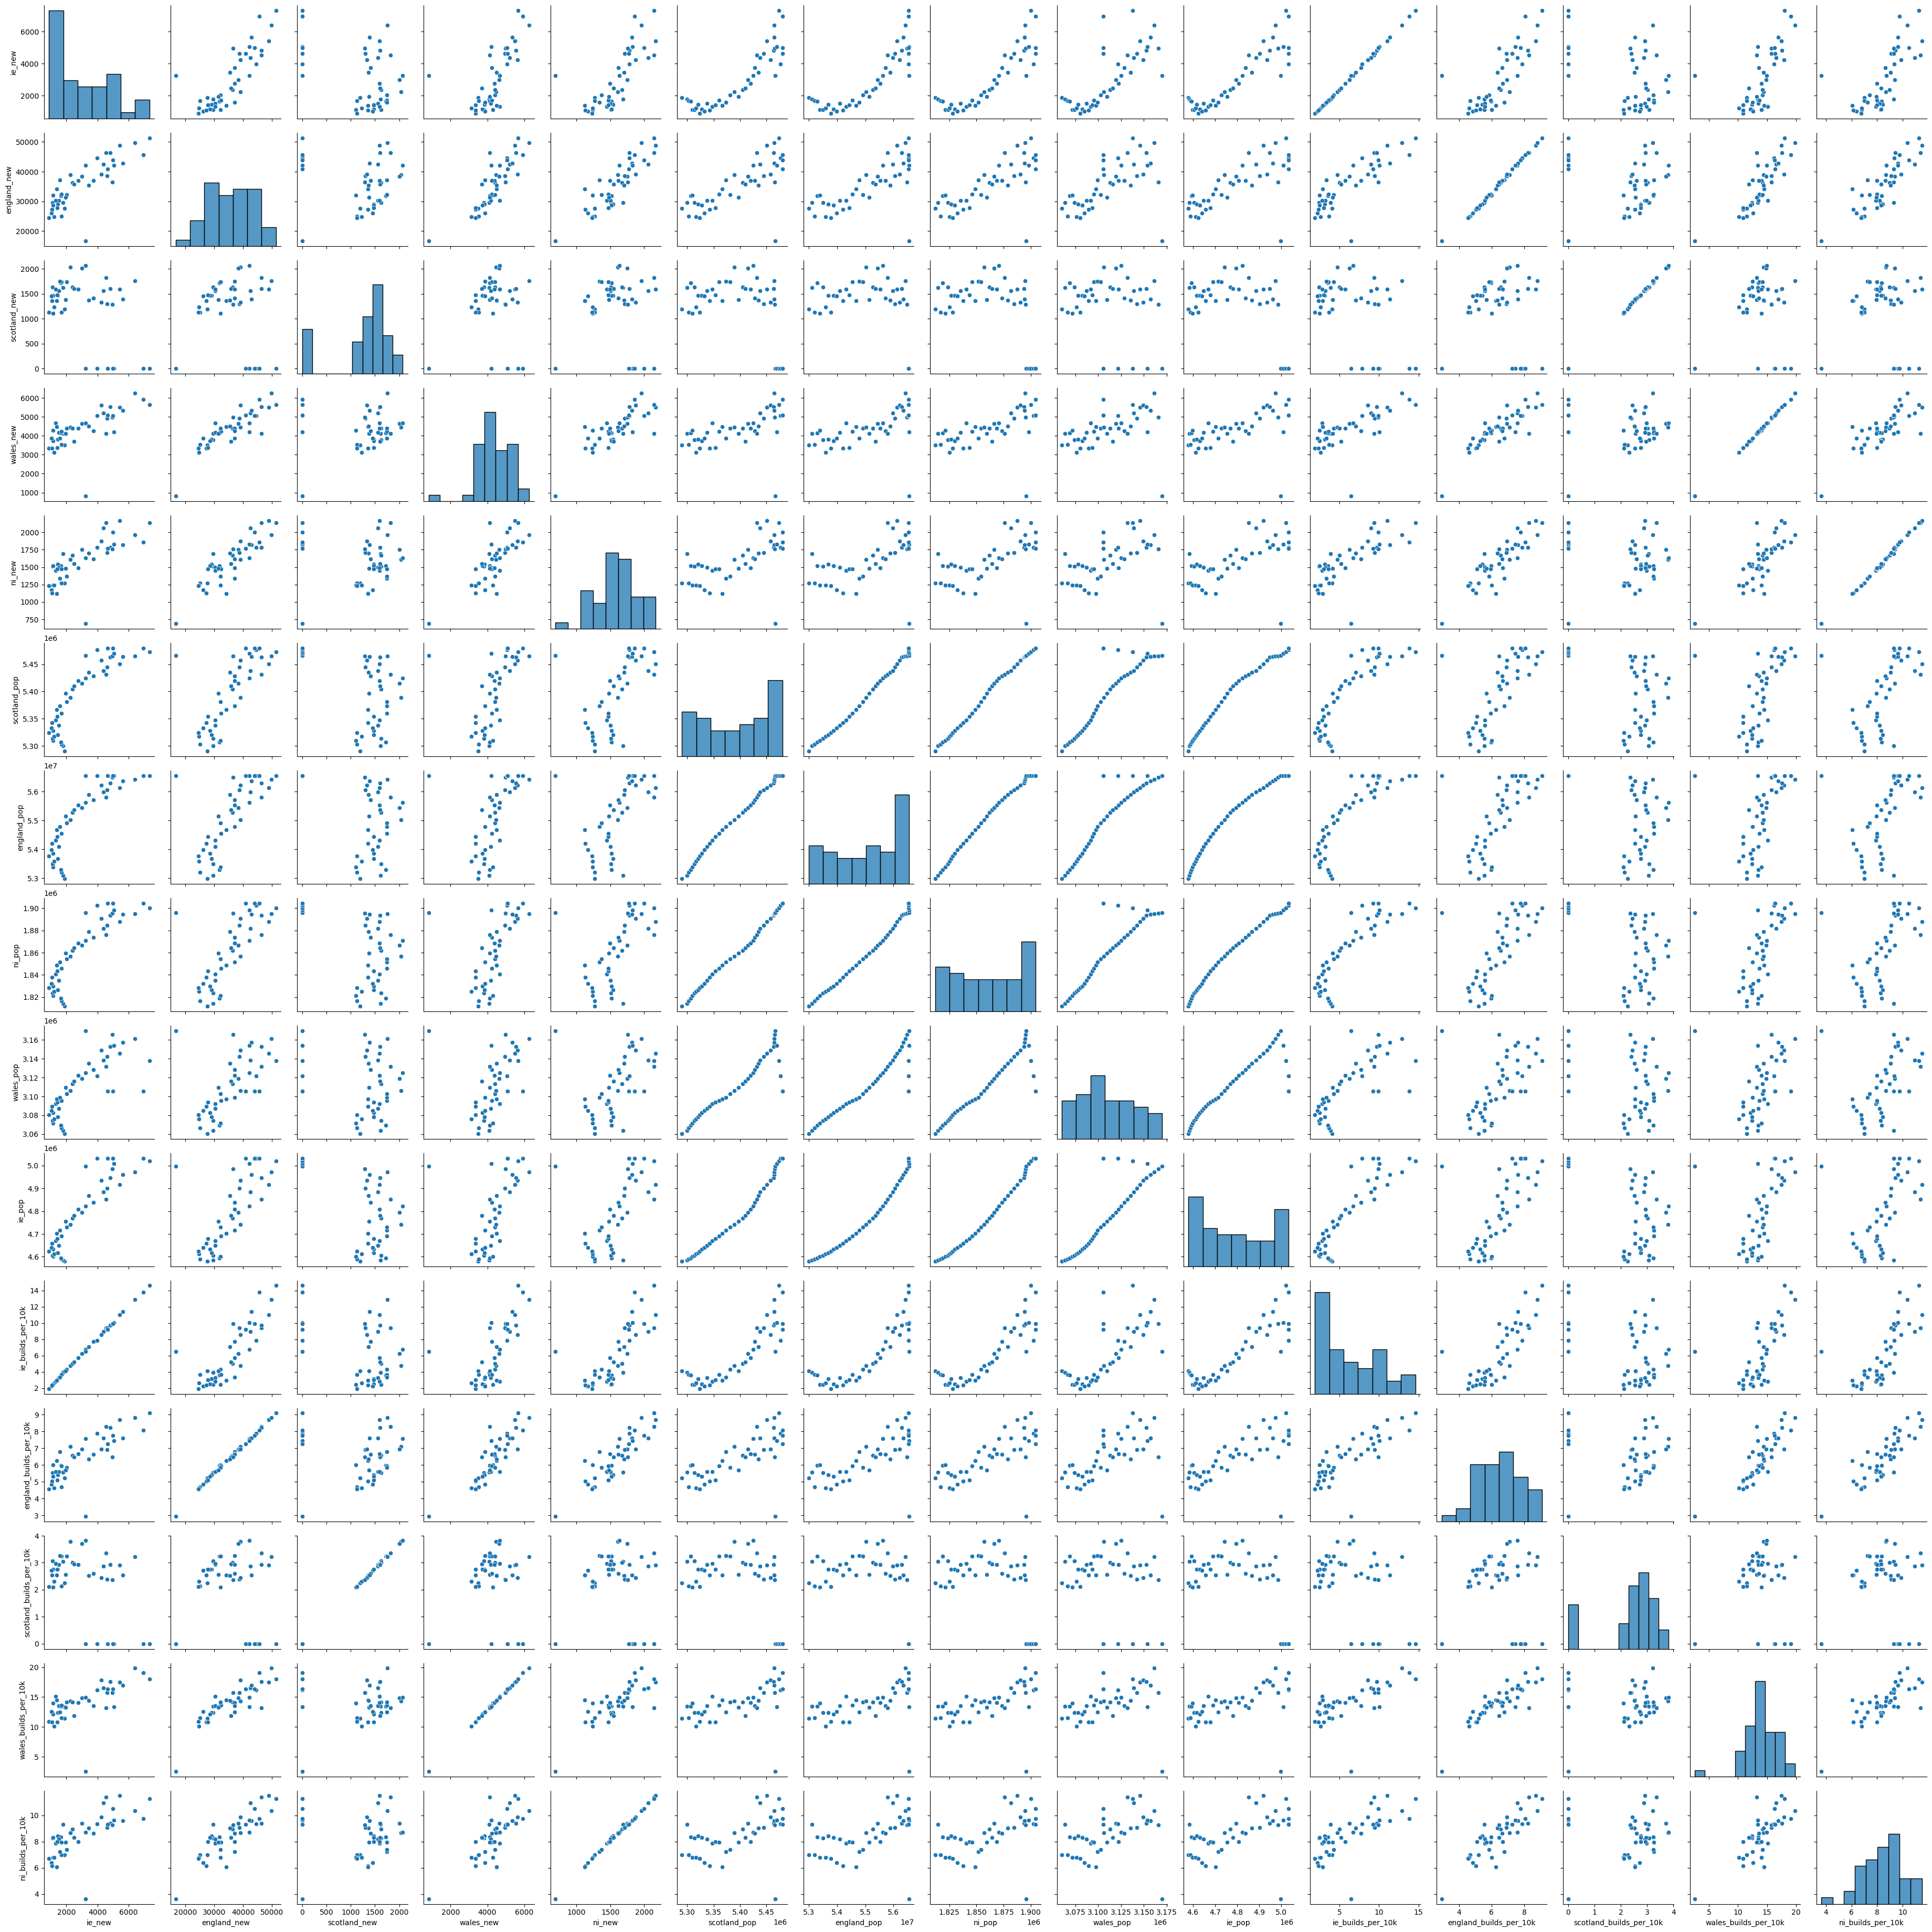

In [291]:
sns.pairplot(df_con_and_pop)

In [292]:
list_ie_cols = [col for col in df_con_and_pop.columns if ("ie_" in col) and ('10k' not in col)]
list_eng_cols = [col for col in df_con_and_pop.columns if ("england_" in col) and ('10k' not in col)]
list_scot_cols = [col for col in df_con_and_pop.columns if ("scotland_" in col) and ('10k' not in col)]
list_wales_cols = [col for col in df_con_and_pop.columns if ("wales_" in col) and ('10k' not in col)]
list_ni_cols = [col for col in df_con_and_pop.columns if ("ni_" in col) and ('10k' not in col)]

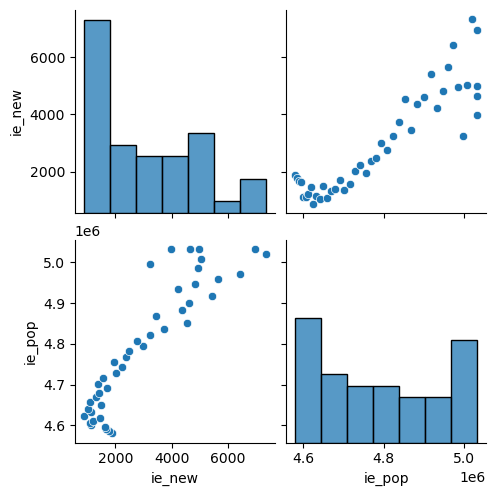

In [293]:
sns.pairplot(data=df_con_and_pop[list_ie_cols])

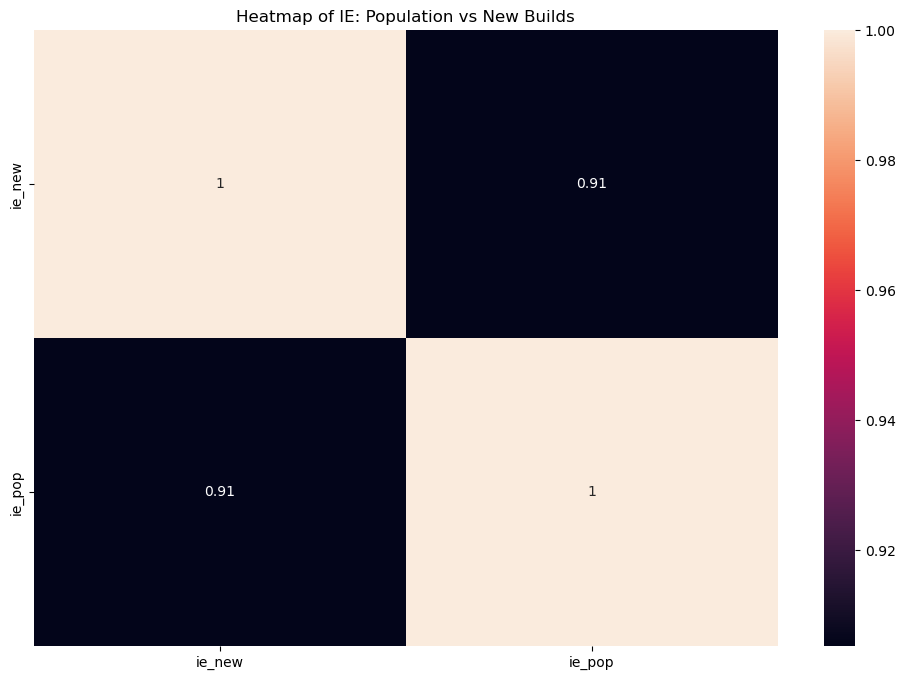

In [306]:
corr_matrix = df_con_and_pop[list_ie_cols].corr()
hp = sns.heatmap(corr_matrix, annot=True)
hp.set_title("Heatmap of IE: Population vs New Builds")
plt.show()

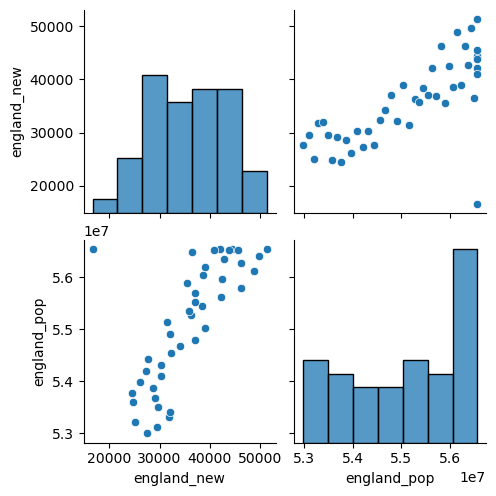

In [294]:
sns.pairplot(data=df_con_and_pop[list_eng_cols])

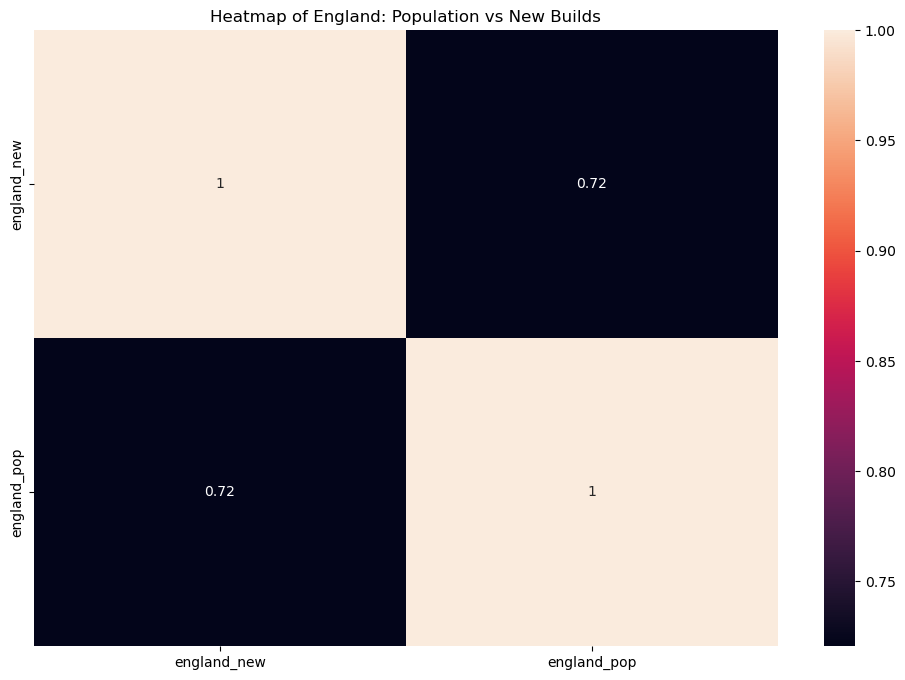

In [307]:
corr_matrix = df_con_and_pop[list_eng_cols].corr()
hp = sns.heatmap(corr_matrix, annot=True)
hp.set_title("Heatmap of England: Population vs New Builds")
plt.show()

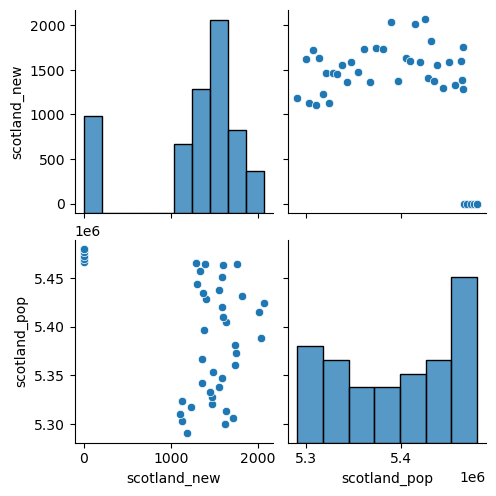

In [295]:
sns.pairplot(data=df_con_and_pop[list_scot_cols])

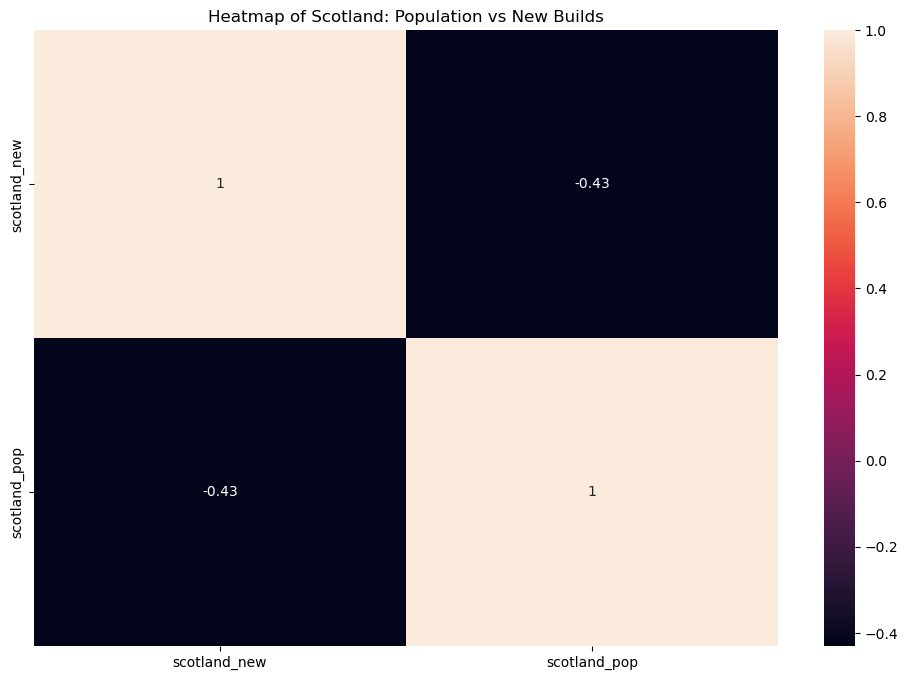

In [309]:
corr_matrix = df_con_and_pop[list_scot_cols].corr()
hp = sns.heatmap(corr_matrix, annot=True)
hp.set_title("Heatmap of Scotland: Population vs New Builds")
plt.show()

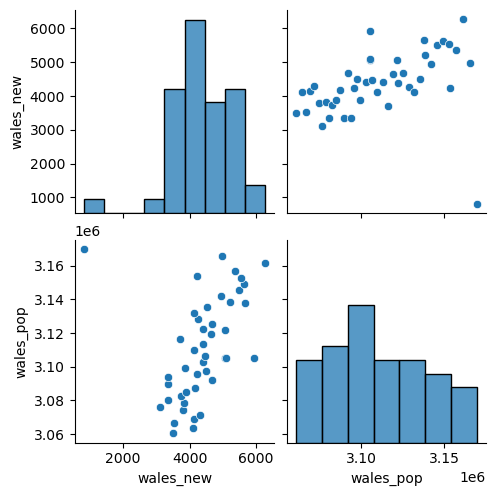

In [296]:
sns.pairplot(data=df_con_and_pop[list_wales_cols])

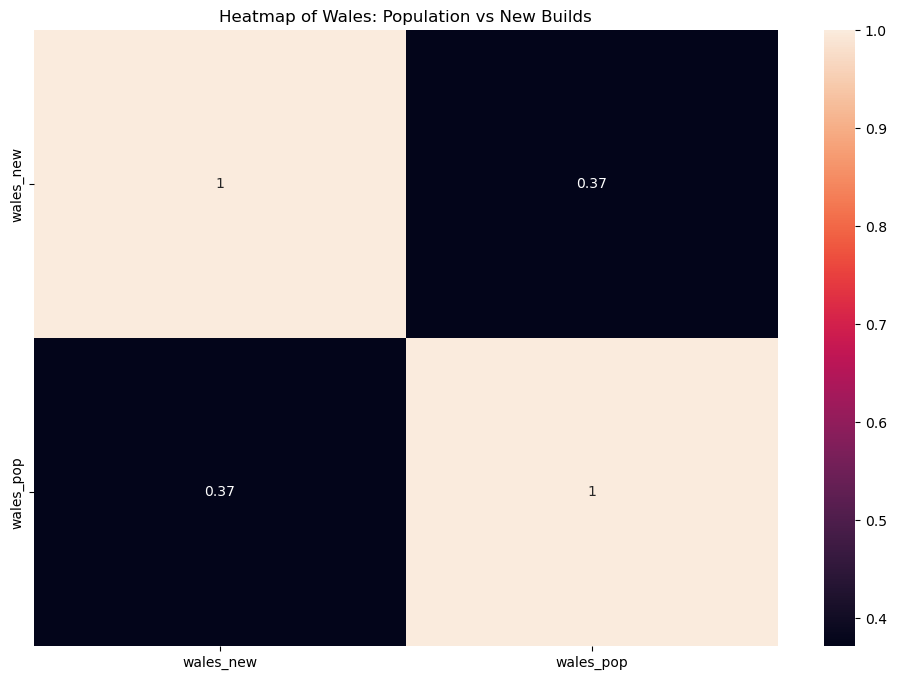

In [310]:
corr_matrix = df_con_and_pop[list_wales_cols].corr()
hp = sns.heatmap(corr_matrix, annot=True)
hp.set_title("Heatmap of Wales: Population vs New Builds")
plt.show()

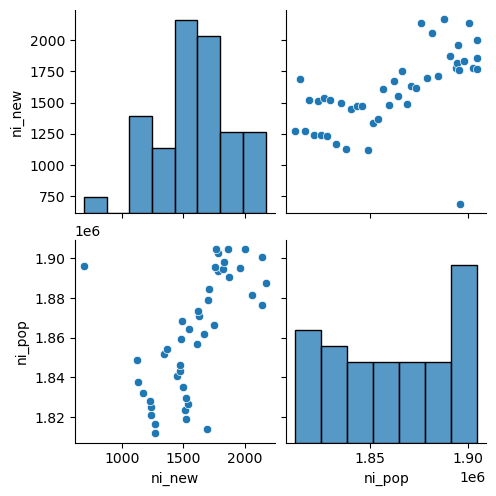

In [297]:
sns.pairplot(data=df_con_and_pop[list_ni_cols])

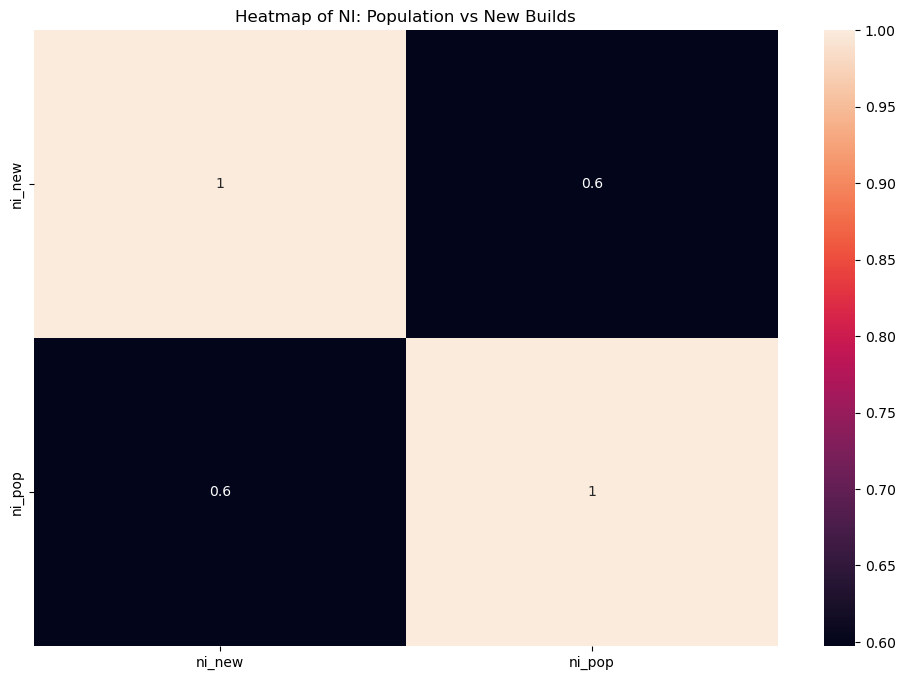

In [311]:
corr_matrix = df_con_and_pop[list_ni_cols].corr()
hp = sns.heatmap(corr_matrix, annot=True)
hp.set_title("Heatmap of NI: Population vs New Builds")
plt.show()

In [299]:
list_new_cols = [col for col in df_con_and_pop.columns if "new" in col]
list_pop_cols = [col for col in df_con_and_pop.columns if "pop" in col]
list_builds_per_10k_cols = [col for col in df_con_and_pop.columns if "10k" in col]

C:\Users\emers\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:blue'` for same effect.
  warnings.warn(msg, FutureWarning)
C:\Users\emers\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 20.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


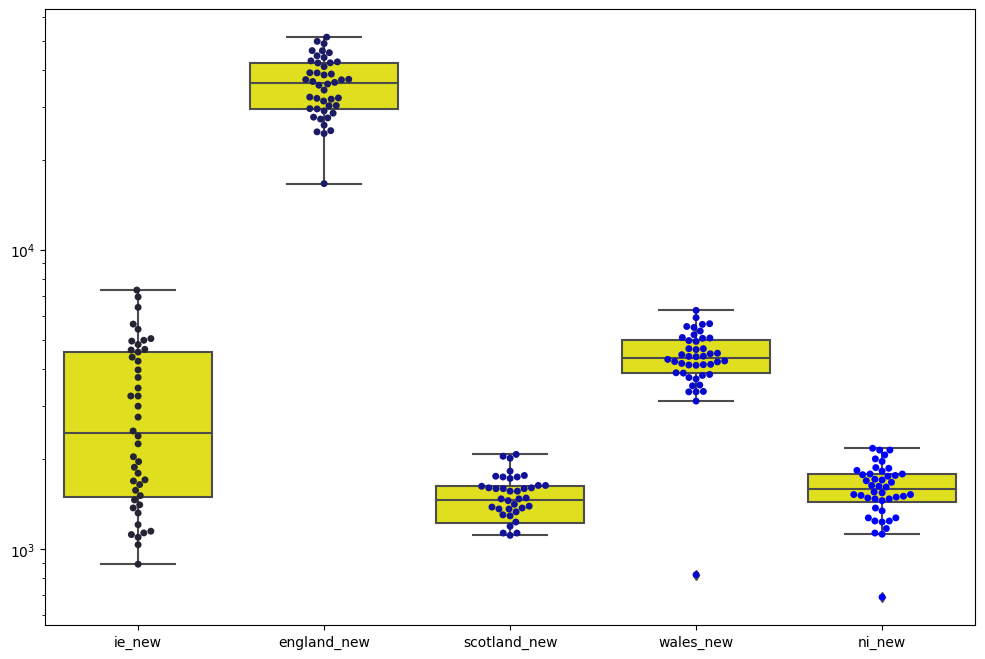

In [300]:
bp = sns.boxplot(data=df_con_and_pop[list_new_cols], color='yellow')
sns.swarmplot(data=df_con_and_pop[list_new_cols], color='blue')
bp.set_yscale('log')

C:\Users\emers\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:blue'` for same effect.
  warnings.warn(msg, FutureWarning)
C:\Users\emers\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 52.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\emers\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 18.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\emers\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


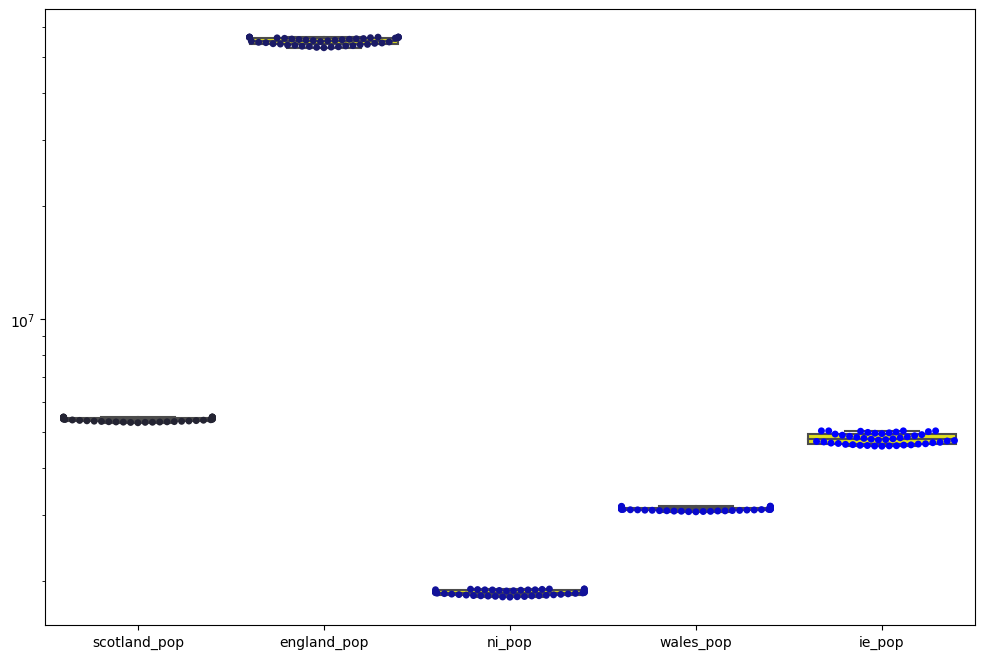

In [301]:
bp = sns.boxplot(data=df_con_and_pop[list_pop_cols], color='yellow')
sns.swarmplot(data=df_con_and_pop[list_pop_cols], color='blue')
bp.set_yscale('log')

C:\Users\emers\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:blue'` for same effect.
  warnings.warn(msg, FutureWarning)


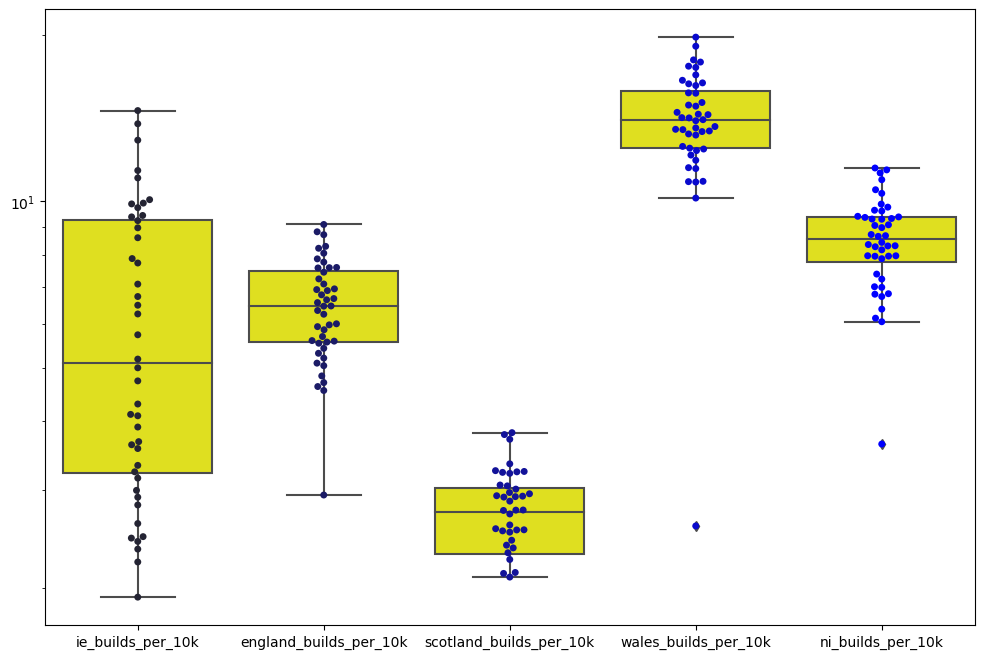

In [302]:
bp = sns.boxplot(data=df_con_and_pop[list_builds_per_10k_cols], color='yellow')
sns.swarmplot(data=df_con_and_pop[list_builds_per_10k_cols], color='blue')
bp.set_yscale('log')

In [303]:
pd.DataFrame({'min':df_con_and_pop.min(), 'max':df_con_and_pop.max()})

,min,max
year,2011,2021
quarter,Q1,Q4
yr_qtr,2011Q1,2021Q4
ie_new,889,7333
england_new,16640.0,51370.0
scotland_new,0.0,2070.0
wales_new,820.0,6270.0
ni_new,690.0,2170.0
scotland_pop,5290475.0,5479900.0
england_pop,52991025.0,56550000.0


In [416]:
from scipy import stats
# Additional Visualisation libraries
from statsmodels.graphics.gofplots import qqplot

from scipy.stats import sem

from scipy.stats import shapiro

from scipy.stats import norm

from scipy.stats import mannwhitneyu

from scipy.stats import levene

from scipy.stats import ttest_ind

from scipy.stats import kruskal

from scipy.stats import wilcoxon

In [367]:
def get_bootstrapped_series_confidence_interval(series):

    # Your non-normally distributed data
    data = series
    n_iterations = 1000
    n_sample = len(data)

    # Array to store bootstrap statistics
    bootstrap_stats = np.empty(n_iterations)

    # Perform bootstrapping
    for i in range(n_iterations):
        # Resample with replacement
        bootstrap_sample = np.random.choice(data, size=n_sample, replace=True)

        # Calculate the statistic of interest for the resampled data
        bootstrap_stat = np.mean(bootstrap_sample)  # Replace with your desired statistic

        # Store the bootstrap statistic
        bootstrap_stats[i] = bootstrap_stat

    # Calculate the confidence interval
    confidence_interval = np.percentile(bootstrap_stats, [2.5, 97.5])

    # Print the confidence interval
    print("Confidence Interval:", confidence_interval)
    return confidence_interval


In [396]:
def perform_normality_test(np_array, col_name):
    """
    Performs a Shapiro-Wilk normality test on a given sampling distribution
    
    
    Parameters
    ----------
    np_array : numpy.array
        Array containing the means of each sample taken
        
    Returns
    -------
    None
    
    """
#     qp = qqplot(np_array,norm,fit=True,line="45")
#     plt.title(f"QQ Plot for {col_name}")
#     plt.show()
    shapiro_test = shapiro(np_array)
#     print(f'Shapiro-Wilk test p-value: {shapiro_test.pvalue}')
#     if shapiro_test.pvalue >= 0.05:
#         print('Fail to reject H0 - Distribution is approximately Normal')
#     elif shapiro_test.pvalue <= 0.05:
#         print('Reject H0 - Distribution is not approximately Normal')
    if shapiro_test.pvalue >= 0.05:
        return [shapiro_test.pvalue, get_normal_confidence_interval(np_array), np.std(np_array)]
    else:
        return [shapiro_test.pvalue, get_bootstrapped_series_confidence_interval(np_array), np.std(np_array)]

In [417]:
def get_normal_confidence_interval(series):
    return st.t.interval(0.95, len(series)-1, loc=np.mean(series), scale=sem(series))

In [418]:
dict_cols_p_values = {}
for col in df_con_and_pop.drop(['year', 'quarter', 'yr_qtr'], axis=1).columns:
    dict_cols_p_values[col] = perform_normality_test(np.array(df_con_and_pop[col]), col)

Confidence Interval: [2530.78352273 3583.09261364]
Confidence Interval: [1113.375      1448.41477273]
Confidence Interval: [4065.28977273 4631.61363636]
Confidence Interval: [5377917.23011364 5413871.03693182]
Confidence Interval: [54756542.01704545 55474871.02272727]
Confidence Interval: [1853152.54261364 1870855.34090909]
Confidence Interval: [4751929.63125    4837783.86036932]
Confidence Interval: [5.14006814 7.30211582]
Confidence Interval: [2.0417761  2.69558564]
Confidence Interval: [13.07444828 14.8641237 ]


In [399]:
dict_cols_p_values

{'ie_new': [0.001220173784531653,
  array([2542.40113636, 3594.08636364]),
  1776.087246310908],
 'england_new': [0.7735965847969055,
  (33266.04153924455, 38036.23118802817),
  7755.329609052173],
 'scotland_new': [9.20722015962383e-07,
  array([1103.83522727, 1446.84090909]),
  600.4087364674554],
 'wales_new': [0.009182521142065525,
  array([4084.0625    , 4634.78409091]),
  917.7909834249836],
 'ni_new': [0.5813872218132019,
  (1494.0500532901685, 1682.7681285280134),
  306.8160774338607],
 'scotland_pop': [0.002371104434132576,
  array([5378328.21022727, 5415873.99147727]),
  62016.08902512819],
 'england_pop': [0.0020805373787879944,
  array([54795406.86079545, 55439746.05113637]),
  1171481.032971962],
 'ni_pop': [0.010115420445799828,
  array([1853883.73579545, 1870362.86931818]),
  29636.033896267614],
 'wales_pop': [0.20803548395633698,
  (3101686.6464983188, 3120320.1716834996),
  30294.21055125144],
 'ie_pop': [0.002485803794115782,
  array([4750537.56164773, 4840907.059232

In [402]:
df_cols_normal_test = pd.DataFrame.from_dict(dict_cols_p_values, orient='index', columns=['p_value', 'confidence_interval', 'std_dev'])

In [403]:
df_cols_normal_test['approx_normal'] = df_cols_normal_test['p_value'] >= 0.05

In [404]:
df_cols_normal_test = df_cols_normal_test[['p_value', 'approx_normal', 'std_dev', 'confidence_interval']]

In [405]:
df_cols_normal_test

,p_value,approx_normal,std_dev,confidence_interval
ie_new,1.220174e-03,False,1.776087e+03,"[2542.4011363636364, 3594.086363636364]"
england_new,7.735966e-01,True,7.755330e+03,"(33266.04153924455, 38036.23118802817)"
scotland_new,9.207220e-07,False,6.004087e+02,"[1103.8352272727273, 1446.840909090909]"
wales_new,9.182521e-03,False,9.177910e+02,"[4084.0625, 4634.784090909091]"
ni_new,5.813872e-01,True,3.068161e+02,"(1494.0500532901685, 1682.7681285280134)"
scotland_pop,2.371104e-03,False,6.201609e+04,"[5378328.210227273, 5415873.9914772725]"
england_pop,2.080537e-03,False,1.171481e+06,"[54795406.86079545, 55439746.05113637]"
ni_pop,1.011542e-02,False,2.963603e+04,"[1853883.7357954546, 1870362.8693181816]"
wales_pop,2.080355e-01,True,3.029421e+04,"(3101686.6464983188, 3120320.1716834996)"
ie_pop,2.485804e-03,False,1.540008e+05,"[4750537.561647727, 4840907.059232955]"


# Compare the mean number of houses built between IE & Wales

In [394]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html

# Step 1: Set up the null and alternative hypotheses
# Null hypothesis (H0): There is no difference between the number of builds in IE and Wales
# Alternative hypothesis (H1): There is a difference in the mean number of builds in IE & Wales.

# Step 2: Choose a significance level (alpha)
alpha = 0.05

# Step 3: Perform the hypothesis test

u_value, p_value = mannwhitneyu(df_con_and_pop['ie_new'], df_con_and_pop['wales_new'], alternative='two-sided')

# Step 4: Compare the p-value with the significance level
if p_value < alpha:
    print("Reject the null hypothesis. There is evidence of a statistically significant difference in distribution of new builds in IE & Wales.")
else:
    print("Fail to reject the null hypothesis. There is insufficient evidence of a statistically significant difference in distribution of new builds in IE & Wales.")

# Step 5: Construct a confidence interval

# Bootstrapping to estimate the confidence interval
n_iterations = 1000
bootstrap_diffs = np.empty(n_iterations)

for i in range(n_iterations):
    # Resample with replacement for both samples
    resample_ie = np.random.choice(df_con_and_pop['ie_new'], size=len(df_con_and_pop['ie_new']), replace=True)
    resample_wales = np.random.choice(df_con_and_pop['wales_new'], size=len(df_con_and_pop['wales_new']), replace=True)
    
    # Calculate the difference in medians (or other relevant statistic)
    bootstrap_diffs[i] = np.median(resample_ie) - np.median(resample_wales)

# Calculate the confidence interval
confidence_interval = np.percentile(bootstrap_diffs, [2.5, 97.5])

# Print the confidence interval
print("Confidence Interval for difference in medians:", confidence_interval)
print("U-value:", u_value)
print("P-value:", p_value)

Reject the null hypothesis. There is evidence of a statistically significant difference in distribution of new builds in IE & Wales.
Confidence Interval for difference in medians: [-2664.0125  -558.95  ]
U-value: 523.0
P-value: 0.00020764683940716018


### Interpretation: 
The confidence interval suggests that, at a 95% confidence level, the true difference in medians between the two samples is likely to be between -2664.0125 and -558.95. This interval does not include zero, indicating that there is evidence of a significant difference in medians.  
Additionally, the small p-value of < alpha (0.0002) indicates strong evidence against the null hypothesis and provides further support for the conclusion that there is a significant difference between the two groups.

# Compare the variance of builds per 10k between England & NI

In [407]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html

# Step 1: Set up the null and alternative hypotheses
# Null hypothesis (H0): There is no difference in variance of builds per 10k between England and NI.
# Alternative hypothesis (H1): There is a difference in the mean number of builds in IE & Wales.

# Step 2: Choose a significance level (alpha)
alpha = 0.05

# Step 3: Perform the hypothesis test
statistic, p_value = levene(df_con_and_pop['england_builds_per_10k'], df_con_and_pop['ni_builds_per_10k'])

# Step 4: Compare the p-value with the significance level
if p_value < alpha:
    print("Reject the null hypothesis. There is evidence of a statistically significant difference in variance of builds per 10k between England and NI.")
else:
    print("Fail to reject the null hypothesis. There is insufficient evidence of a statistically significant difference in variance of builds per 10k between England and NI.")

# Print the test statistic and p-value
print("Test Statistic:", statistic)
print("P-value:", p_value)


Fail to reject the null hypothesis. There is insufficient evidence of a statistically significant difference in variance of builds per 10k between England and NI.
Test Statistic: 0.6097570991554279
P-value: 0.4370234811016036


### Interpretation: 
The large p-value of 0.43 (> alpha) indicates evidence supporting the null hypothesis and provides support for the conclusion that there is no statistically significant difference between variance of builds per 10k between England and NI.

# Compare the mean builds per 10k between England & NI

In [412]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

# Step 1: Set up the null and alternative hypotheses
# Null hypothesis (H0): There is no difference between the mean number of builds per 10k in England and NI.
# Alternative hypothesis (H1): There is a difference in the mean number of builds per 10k in England and NI.

# Step 2: Choose a significance level (alpha)
alpha = 0.05

# Step 3: Perform the hypothesis test
t_statistic, p_value = ttest_ind(df_con_and_pop['england_builds_per_10k'], df_con_and_pop['ni_builds_per_10k'], equal_var=True)

# Step 4: Compare the p-value with the significance level
if p_value < alpha:
    print("Reject the null hypothesis. There is evidence of a statistically significant difference in mean builds per 10k between England and NI.")
else:
    print("Fail to reject the null hypothesis. There is insufficient evidence of a statistically significant difference in ean builds per 10k between England and NI.")

# Step 5: Construct a confidence interval

# https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_confidence_intervals/bs704_confidence_intervals5.html#:~:text=The%20confidence%20interval%20for%20the,meaningful%20difference%20between%20comparison%20groups.

# Calculate the means and standard deviations of the two samples
mean1 = np.mean(df_con_and_pop['england_builds_per_10k'])
mean2 = np.mean(df_con_and_pop['ni_builds_per_10k'])
std1 = np.std(df_con_and_pop['england_builds_per_10k'])
std2 = np.std(df_con_and_pop['ni_builds_per_10k'])
n1 = len(df_con_and_pop['england_builds_per_10k'])
n2 = len(df_con_and_pop['ni_builds_per_10k'])

# Calculate the pooled standard deviation
pooled_std = np.sqrt(((n1 - 1) * std1 ** 2 + (n2 - 1) * std2 ** 2) / (n1 + n2 - 2))

# Calculate the standard error of the difference in means
standard_error = pooled_std * np.sqrt(1 / n1 + 1 / n2)

# Calculate the margin of error
margin_of_error = t_statistic * standard_error

# Calculate the confidence interval for the difference in means
confidence_interval = (mean1 - mean2) - margin_of_error, (mean1 - mean2) + margin_of_error

# Print the confidence interval
print("Confidence Interval for Difference in Means:", confidence_interval)
print("T-statistic:", t_statistic)
print("P-value:", p_value)

Reject the null hypothesis. There is evidence of a statistically significant difference in mean builds per 10k between England and NI.
Confidence Interval for Difference in Means: (-0.023634521709736678, -4.112270942422905)
T-statistic: -6.668681572336858
P-value: 2.3678446703591154e-09


### Interpretation: 
The confidence interval suggests that, at a 95% confidence level, the true difference in medians between the two samples is likely to be between -4.1 and -0.02. This interval does not include zero, indicating that there is evidence of a significant difference in means of the samples.  
Additionally, the small p-value of 2.36e-09 (< alpha) indicates strong evidence against the null hypothesis and provides support for the conclusion that there is a statistically significant difference the means of builds per 10k between England and NI.

# Compare the mean number of houses built in IE, Scotland & Wales

In [414]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html

# Step 1: Set up the null and alternative hypotheses
# Null hypothesis (H0): There is no difference between the mean number of new builds in IE, Scotland and Wales.
# Alternative hypothesis (H1): There is a difference in the mean number of new builds in IE, Scotland and Wales.

# Step 2: Choose a significance level (alpha)
alpha = 0.05

# Step 3: Perform the hypothesis test
statistic, p_value = kruskal(df_con_and_pop['ie_new'], df_con_and_pop['wales_new'], df_con_and_pop['scotland_new'])

# Step 4: Compare the p-value with the significance level
alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis. There is evidence of a statistically significant difference in distributions among the groups.")
else:
    print("Fail to reject the null hypothesis. There is insufficient evidence of a statistically significant difference in distributions among the groups.")

# Bootstrapping to estimate the confidence interval
n_iterations = 1000
bootstrap_statistic = np.empty(n_iterations)

for i in range(n_iterations):
    # Resample with replacement for all three samples
    resample1 = np.random.choice(df_con_and_pop['ie_new'], size=len(df_con_and_pop['ie_new']), replace=True)
    resample2 = np.random.choice(df_con_and_pop['wales_new'], size=len(df_con_and_pop['wales_new']), replace=True)
    resample3 = np.random.choice(df_con_and_pop['scotland_new'], size=len(df_con_and_pop['scotland_new']), replace=True)
    
    # Perform the Kruskal-Wallis test on the resampled data
    bootstrap_statistic[i], _ = kruskal(resample1, resample2, resample3)

# Step 5: Calculate the confidence interval
confidence_interval = np.percentile(bootstrap_statistic, [2.5, 97.5])

# Print the confidence interval
print("Confidence Interval for Kruskal-Wallis Statistic:", confidence_interval)
print("Kruskal-Wallis Statistic:", statistic)
print("P-value:", p_value)

Reject the null hypothesis. There is evidence of a statistically significant difference in distributions among the groups.
Confidence Interval for Kruskal-Wallis Statistic: [50.84909834 75.9429242 ]
Kruskal-Wallis Statistic: 63.32551113042561
P-value: 1.7743527999728462e-14


### Interpretation: 
The confidence interval for the Kruskal-Wallis statistic, at a 95% confidence level, is between 50.8 and 75.9. The interval does not include zero, which indicates evidence of a statistically significant difference the means of new builds between IE, Wales & Scotland.
Additionally, the small p-value of 1.77e-14 (< alpha) indicates strong evidence against the null hypothesis and provides support for the conclusion that there is a statistically significant difference the means of new builds between IE, Wales & Scotland.

# Test if the number of new builds in IE has increased significantly

In [ ]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html

# Step 1: Set up the null and alternative hypotheses
# Null hypothesis (H0): 
# Alternative hypothesis (H1): 

# Step 2: Choose a significance level (alpha)
alpha = 0.05

# Step 3: Perform the hypothesis test


# Step 4: Compare the p-value with the significance level
alpha = 0.05

if p_value < alpha:
    print()
else:
    print()

# Step 5: Calculate the confidence interval
confidence_interval = np.percentile(bootstrap_statistic, [2.5, 97.5])

